# Setup

In [1]:
# Uncomment on first run
# %pip install matplotlib yfinance pandas-datareader

In [2]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
import importlib

In [3]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.cm as cm

import math
from IPython.display import display
import yfinance as yf

import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
## Rerun cell to reload imports

import src
try: 
    for module in [src.models, src.data, src.utils, src.train, src.verification, src.visualisation, src.evaluation]:
        if module:
            importlib.reload(module)
    print("Reloading")
except:
    print("Not reloading")

from src.models import *
from src.data import *
from src.utils import *
from src.train import *
from src.verification import *
from src.visualisation import *
from src.evaluation import *

Not reloading


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Load

In [6]:
trainval_start = "2006-04-02"
trainval_end = "2019-12-31"
test_start = "2020-01-01"
test_start = "2020-01-01"
test_end = "2022-12-31"

In [7]:
returns_df, close_df =  get_asset_dataset(trainval_start, test_end)

asset_names = list(returns_df.columns)
n_assets = len(asset_names)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [8]:
trainval_mask = (close_df.index >= trainval_start) & (close_df.index <= trainval_end)
trainval_indices = close_df[trainval_mask].index

val_size = int(0.2 * len(trainval_indices))
train_indices = trainval_indices[:-val_size]
val_indices = trainval_indices[-val_size:]

test_mask = (close_df.index >= test_start) & (close_df.index <= test_end)
test_indices = close_df[test_mask].index

/tmp/ipykernel_2762574/1227994262.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


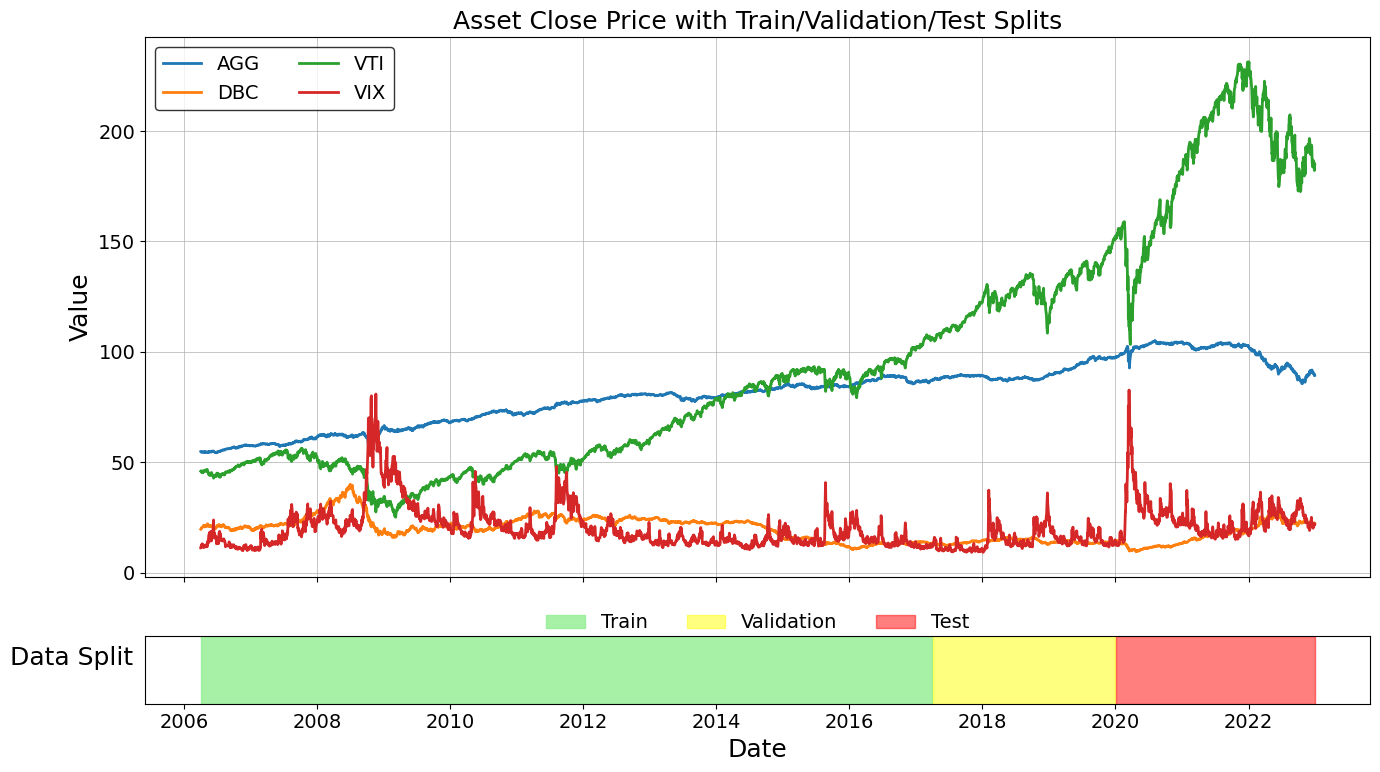

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
colors = cm.get_cmap('tab10')

plt.rcParams.update({
    "font.size": 16,            
    "axes.titlesize": 18,       
    "axes.labelsize": 18,       
    "xtick.labelsize": 14,      
    "ytick.labelsize": 14,     
    "legend.fontsize": 14,     
})

train_start = min(train_indices)
train_end = max(train_indices)
val_start = min(val_indices)
val_end = max(val_indices)
test_start = min(test_indices)
test_end = max(test_indices)

fig, (ax_main, ax_timeline) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [8, 1]},
    figsize=(14, 8)
)

for i, ticker in enumerate(close_df.columns):
    asset_color = colors(i)
    for idx, label in zip([train_indices, val_indices, test_indices], ["Train", "Val", "Test"]):
        plot_label = ticker if label == "Train" else "_nolegend_"
        ax_main.plot(
            close_df.loc[idx, ticker],
            color=asset_color,
            linewidth=2,
            label=plot_label
        )

ax_main.set_title("Asset Close Price with Train/Validation/Test Splits")
ax_main.set_ylabel("Value")
ax_main.grid(True, linewidth=0.5)
ax_main.legend(loc="upper left", fontsize="14", ncol=2, frameon=True, edgecolor="black")

ax_timeline.axvspan(train_start, train_end, color="lightgreen", alpha=0.8, label="Train")
ax_timeline.axvspan(val_start, val_end, color="yellow", alpha=0.5, label="Validation")
ax_timeline.axvspan(test_start, test_end, color="red", alpha=0.5, label="Test")

ax_timeline.set_yticks([])
ax_timeline.set_ylabel("Data Split", rotation=0, labelpad=40)
ax_timeline.yaxis.set_label_coords(-0.06, 0.5)
ax_timeline.grid(False)

ax_timeline.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_timeline.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

ax_timeline.legend(loc="center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.2))

plt.xlabel("Date")
plt.tight_layout(h_pad=1.0)
plt.show()


In [10]:
lookback = 50   
horizon = 5     
allocation_step = 5

X_train, y_train, train_idx = create_windows(returns_df, train_indices, lookback, horizon)
X_val, y_val, val_idx = create_windows(returns_df, val_indices, lookback, horizon)
X_test, y_test, test_idx = create_windows(returns_df, test_indices, lookback, horizon)

batch_size = 32

X_train_tensor_ = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor_ = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor_ = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

num_samples, seq_len, num_assets = X_train_tensor_.shape
flattened = X_train_tensor_.reshape(-1, num_assets)

mean = flattened.mean(dim=0)  
std = flattened.std(dim=0)    

std[std == 0] = 1.0

X_train_tensor = standardize(X_train_tensor_, mean, std)
X_val_tensor = standardize(X_val_tensor_, mean, std)
X_test_tensor = standardize(X_test_tensor_, mean, std)

saved_mean = mean
saved_std = std

In [11]:

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Experiments

In [12]:
def run_experiment(model, data, experiment={}):
    params = experiment.get("params", {})
    rebalance_freq = params.get("rebalance_freq", 5)
    x, y = data
    model.eval()
    n = y.shape[0]

    x = x.to(device)

    # print(rebalance_freq)

    portfolio_values,weights,holdings = get_portfolio_value(model, (x,y), rebalance_freq)

    weights = torch.tensor(weights).squeeze(1)
    holdings = torch.tensor(holdings).squeeze(1)


    # returns = portfolio_values.
    cum_returns = portfolio_values - 1

    returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]

    # Daily metrics
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe = sharpe_ratio(returns)

    metrics = {
        "expected_return": cum_returns[-1].item(),
        "sharpe_ratio": sharpe,
        "max_drawdown": max_drawdown(portfolio_values),
        "mean_entropy": mean_entropy(weights),
        "mean_return": mean_return,
        "std_return": std_return,
    }

    raw = {
        "weights": weights,
        "returns": returns,
        "cum_returns": cum_returns,
        "holdings": holdings,
    }

    return {"metrics": metrics, "raw": raw}

In [13]:
def default_linestyle_map(params):
    return "-"

def display_train_results(experiments):
    plt.figure(figsize=(10, 6))
    colors = cm.get_cmap('tab10')

    for idx, (label, experiment) in enumerate(experiments.items()):
        if "train_results" not in experiment:
            continue
        # label = label_from_params(experiment["params"], experiments)
        
        data = experiment["train_results"]
        epochs = list(range(1, len(data["train_losses"]) + 1))
        color = colors(idx % 10) 

        plt.plot(epochs, data["train_losses"], label=f"{label} - Train", linestyle='-', color=color)
        plt.plot(epochs, data["val_losses"], label=f"{label} - Val", linestyle='--', color=color)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map=default_linestyle_map, label_from_params=None, additional_detail=False):
    metrics_df  = pd.DataFrame({k: v['results'][dataset_key]["metrics"] for k, v in experiments.items()}).T
    metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)
    display(metrics_df)

    plt.figure(figsize=(10, 6))
    for label, params, cr in [(k, v["params"], v['results'][dataset_key]["raw"]["cum_returns"]) for k, v in experiments.items()]:

        print(cr.shape)
        plt.plot(dataset_idx[::5], cr[::5], label=label, linestyle=linestyle_map(params))

    plt.title(f"Cumulative Returns of Different Models ({dataset_key.title()})")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ncols = 2
    nrows = math.ceil(len(experiments.items()) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Loop through and plot
    for i, (label, weights) in enumerate([(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]):
        ax = axes[i]
        ax.stackplot(dataset_idx, weights.T.detach().numpy(), labels=asset_names)
        ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Proportion')
        ax.legend(loc='upper left')
        ax.grid(True)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    if additional_detail:

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
        axes = axes.flatten()

        # Loop through and plot
        for i, (label, holding) in enumerate([(k, v['results'][dataset_key]["raw"]["holdings"]) for k, v in experiments.items()]):
            ax = axes[i]
            ax.plot(dataset_idx, holding.detach().numpy(), label=asset_names)
            ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Proportion')
            ax.legend(loc='upper left')
            ax.grid(True)

        # Hide any unused axes
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))

        for params, weights in [(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]:
            if "epochs" not in params:
                continue
            plt.plot(dataset_idx, entropy(weights).detach().numpy(), label=label)

        plt.axhline(np.log(n_assets), color='gray', linestyle='--', label='Max Entropy (Uniform)')
        plt.title(f'Allocation Entropy Over Time ({dataset_key.title()})')
        plt.xlabel('Date')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metrics_df    

<!-- # Standard Training -->

In [14]:
    
def standard_model_fn(params):
    if params["model"] == "CNN":
        return FinalCNN().to(device)
    if params["model"] == "CNN_Causal":
        return CNNAllocatorCausal(4, lookback).to(device)
    elif params["model"] == "MLP":
        return SimpleAssetAllocationModel(4*lookback).to(device)
    elif params["model"] == "LSTM":
        hidden_size = params["lstm_hidden_size"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "LSTM_Unrolled":
        hidden_size = params["lstm_hidden_size"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM_Unrolled(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "Transformer":
        return Transformer(input_size=50,  output_size=4, d_model=2, nhead=2, num_layers=2, dim_head=4).to(device)

    raise Exception("Model not found")

In [15]:

def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


In [16]:
def hyperparam_search(experiments, metric="val_expected_return"):
    params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T
    results_df = params_df
    for df_name in ["val", "test"]:
        df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
        df = df.add_prefix(f'{df_name}_')
        results_df = pd.concat([results_df, df], axis=1)

    metric = "val_expected_return"
    params = params_df.columns 
    group_by_params = [p for p in params if p!= "seed"]
    agg_results_df = results_df.groupby(group_by_params)[metric].mean().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})
    print("Hyperparam Search over seeds")
    display(agg_results_df)
    best_params = agg_results_df[group_by_params].iloc[0].to_dict()

    for col, val in best_params.items():
        results_df = results_df[results_df[col] == val]

    results_df = results_df.sort_values(metric, ascending=False)[params].iloc[0]
    return results_df.to_dict()


In [17]:
def robust_loss_fn_fn(params):
    if params["loss"] == "Standard":

        def loss_fn(x, y, model, epoch, _):

            β   = 0.1#risk_penalty  # e.g. 0.5 or tune via validation

            w0 = model(x)                                  # [B, A]
            w  = w0.unsqueeze(1).repeat(1, horizon, 1)     # [B, T, A]
            r  = (w * y).sum(dim=2)                        # [B, T]



            μ  = r.mean(dim=1) 
            σ  = r.std(dim=1, unbiased=False)              # [B]



            mv = μ - β * σ
            return -mv.mean(), {"standard": μ.mean().item()}


        return loss_fn

    elif params["loss"] == "CROWN-IBP" or params["loss"] == "IBP":
        lambda_entropy = params["lambda_entropy"]
        true_alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        warmup = params["warmup"]
        # eps_vector = torch.tensor(robust_eps, dtype=torch.float32, device=device)

        def loss_fn(x, y, model, epoch, bounded_model):

            alpha = true_alpha * (min(epoch, warmup)/ warmup)
            β   = 0.1#risk_penalty  # e.g. 0.5 or tune via validation

            w0 = model(x)                                  # [B, A]
            w  = w0.unsqueeze(1).repeat(1, horizon, 1)     # [B, T, A]
            r  = (w * y).sum(dim=2)                        # [B, T]

            width = 0

            if true_alpha > 0:
                perturbation = PerturbationLpNorm(norm=np.inf, eps=robust_eps)
                x_perturbed = BoundedTensor(x, perturbation)
                ub, lb = bounded_model.compute_bounds(x=(x_perturbed,), method=params["loss"])
                ub = ub.unsqueeze(1).repeat(1, horizon, 1)
                lb = lb.unsqueeze(1).repeat(1, horizon, 1)

                width = (ub - lb).mean().item()

                wr = torch.min(y * ub, y * lb).sum(dim=2)  
            else:
                wr = torch.zeros_like(r)

            μ  = r.mean(dim=1) 
            wr = wr.mean(dim=1)                             
            σ  = r.std(dim=1, unbiased=False)              


            mv = μ * (1-alpha) + alpha * wr - β * σ
            return -mv.mean(), {"standard": μ.mean().item(), "robust": wr.mean().item(), "width": width}

        return loss_fn

    elif params["loss"] == "PGD":
        true_alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        warmup = params["warmup"]

        def pgd_attack_loss(x, y):
                x = x.unsqueeze(1).repeat(1, horizon, 1)   
                loss = (x * y).sum(dim=2).mean(1)
                return loss

        def loss_fn(x, y, model, epoch, bounded_model):
            alpha = true_alpha * (min(epoch, warmup)/ warmup)
           

            model.eval()
            aw = model(pgd_attack(model, x, y, robust_eps, pgd_attack_loss, n_steps=10))
            aw = aw.unsqueeze(1).repeat(1, horizon, 1)    
            ar = (aw * y).sum(dim=2)
            model.train()

            β   = 0.1

            w0 = model(x)       
                     
            w  = w0.unsqueeze(1).repeat(1, horizon, 1)     
            r  = (w * y).sum(dim=2) 
            
                       
            
            ar = torch.zeros_like(r)
            μ  = r.mean(dim=1) 
            μa  = ar.mean(dim=1)
            σ  = r.std(dim=1, unbiased=False)
            
            mv = μ * (1-alpha) + alpha * μa - β * σ
            return -mv.mean(), {"standard": μ.mean().item(), "robust": μa.mean().item()}
        
        return loss_fn



    
    elif params["loss"] in ["MTL-IBP", "Exp-IBP", "CC-IBP"]:
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps = robust_eps
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)
        def pgd_attack_loss(x, y):
            loss = ((1 + y).prod(1) * x).sum(1)
            return loss
        def loss_fn(x, y, model):
            model.eval()
            output_adv = model(pgd_attack(model, x, y, eps_vector, pgd_attack_loss, n_steps=10))
            model.train()
            
            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
            asset_returns = ((1 + y).prod(1)-1)

            weights = model(x)
            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            if params["loss"] == "CC-IBP":
                returns = torch.min(asset_returns * (output_adv * alpha + ub * (1-alpha)), asset_returns * (output_adv * alpha + lb * (1-alpha))).sum(1)
                loss = returns.mean()

                return loss + entropy_loss

            else:
                worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)
                robust_loss = -worst_returns.mean() 
                adv_returns = (output_adv * asset_returns).sum(1)
                adv_loss = -adv_returns.mean() 

                if params["loss"] == "MTL-IBP":
                    loss = (adv_loss *(1 - alpha)) + (robust_loss * alpha) + entropy_loss
                elif params["loss"] == "Exp-IBP":
                    loss = (adv_loss **(1 - alpha)) + (robust_loss ** alpha) + entropy_loss

                return loss
        return loss_fn
    
    raise Exception("not foiund")

In [18]:
def get_bounded_model2(model):

    model = model.to(device)

    beta_crown_args = {
                "enable_alpha_crown": True,   
                "enable_beta_crown": True,    
                "optimizer": "adam",          
                "iteration": 5,              
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            }

    bound_opts = {
            "optimize_bound_args": beta_crown_args,
            "conv_mode": "matrix"
        }
    return BoundedModule(model, X_train_tensor, bound_opts=bound_opts)

# Standard Performance

In [19]:
import torch
import torch.nn as nn
import numpy as np



--------------------
Test RESULTS
--------------------


/tmp/ipykernel_2762574/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy  \
Fixed                    0.326       0.0629       0.0861         1.19   
Fixed (Annual)           0.211       0.0497         0.14         1.16   
1/N                      0.443       0.0325        0.186         1.38   
1/N (Annual)             0.205       0.0194        0.195         1.36   
Inv Baseline             0.103       0.0383        0.111        0.941   
Min Variance             0.295       0.0751       0.0977         1.24   

               mean_return std_return  
Fixed             0.000429    0.00681  
Fixed (Annual)    0.000294    0.00593  
1/N               0.000591     0.0182  
1/N (Annual)      0.000265     0.0136  
Inv Baseline      0.000163    0.00425  
Min Variance      0.000395    0.00526

(701,)
(701,)
(701,)
(701,)
(701,)
(701,)


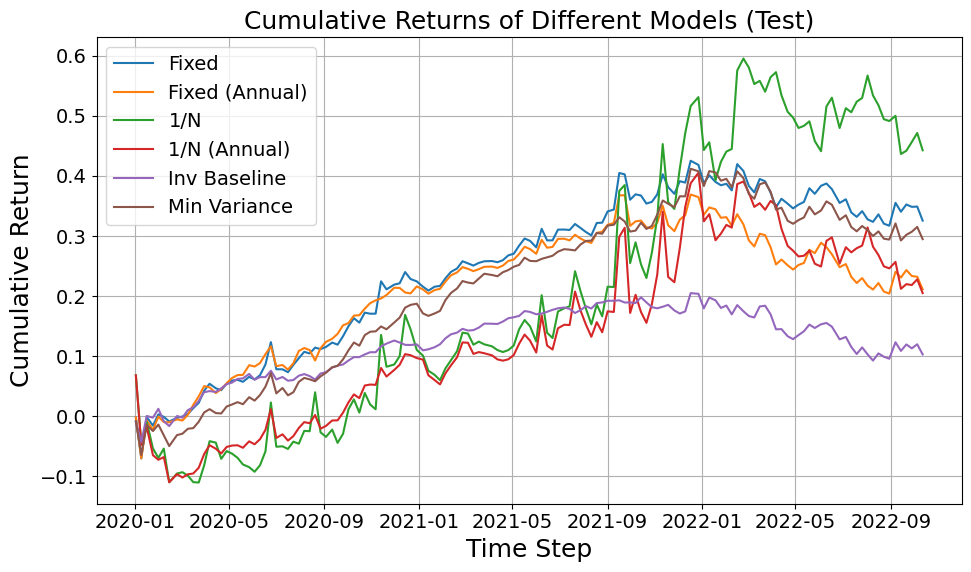

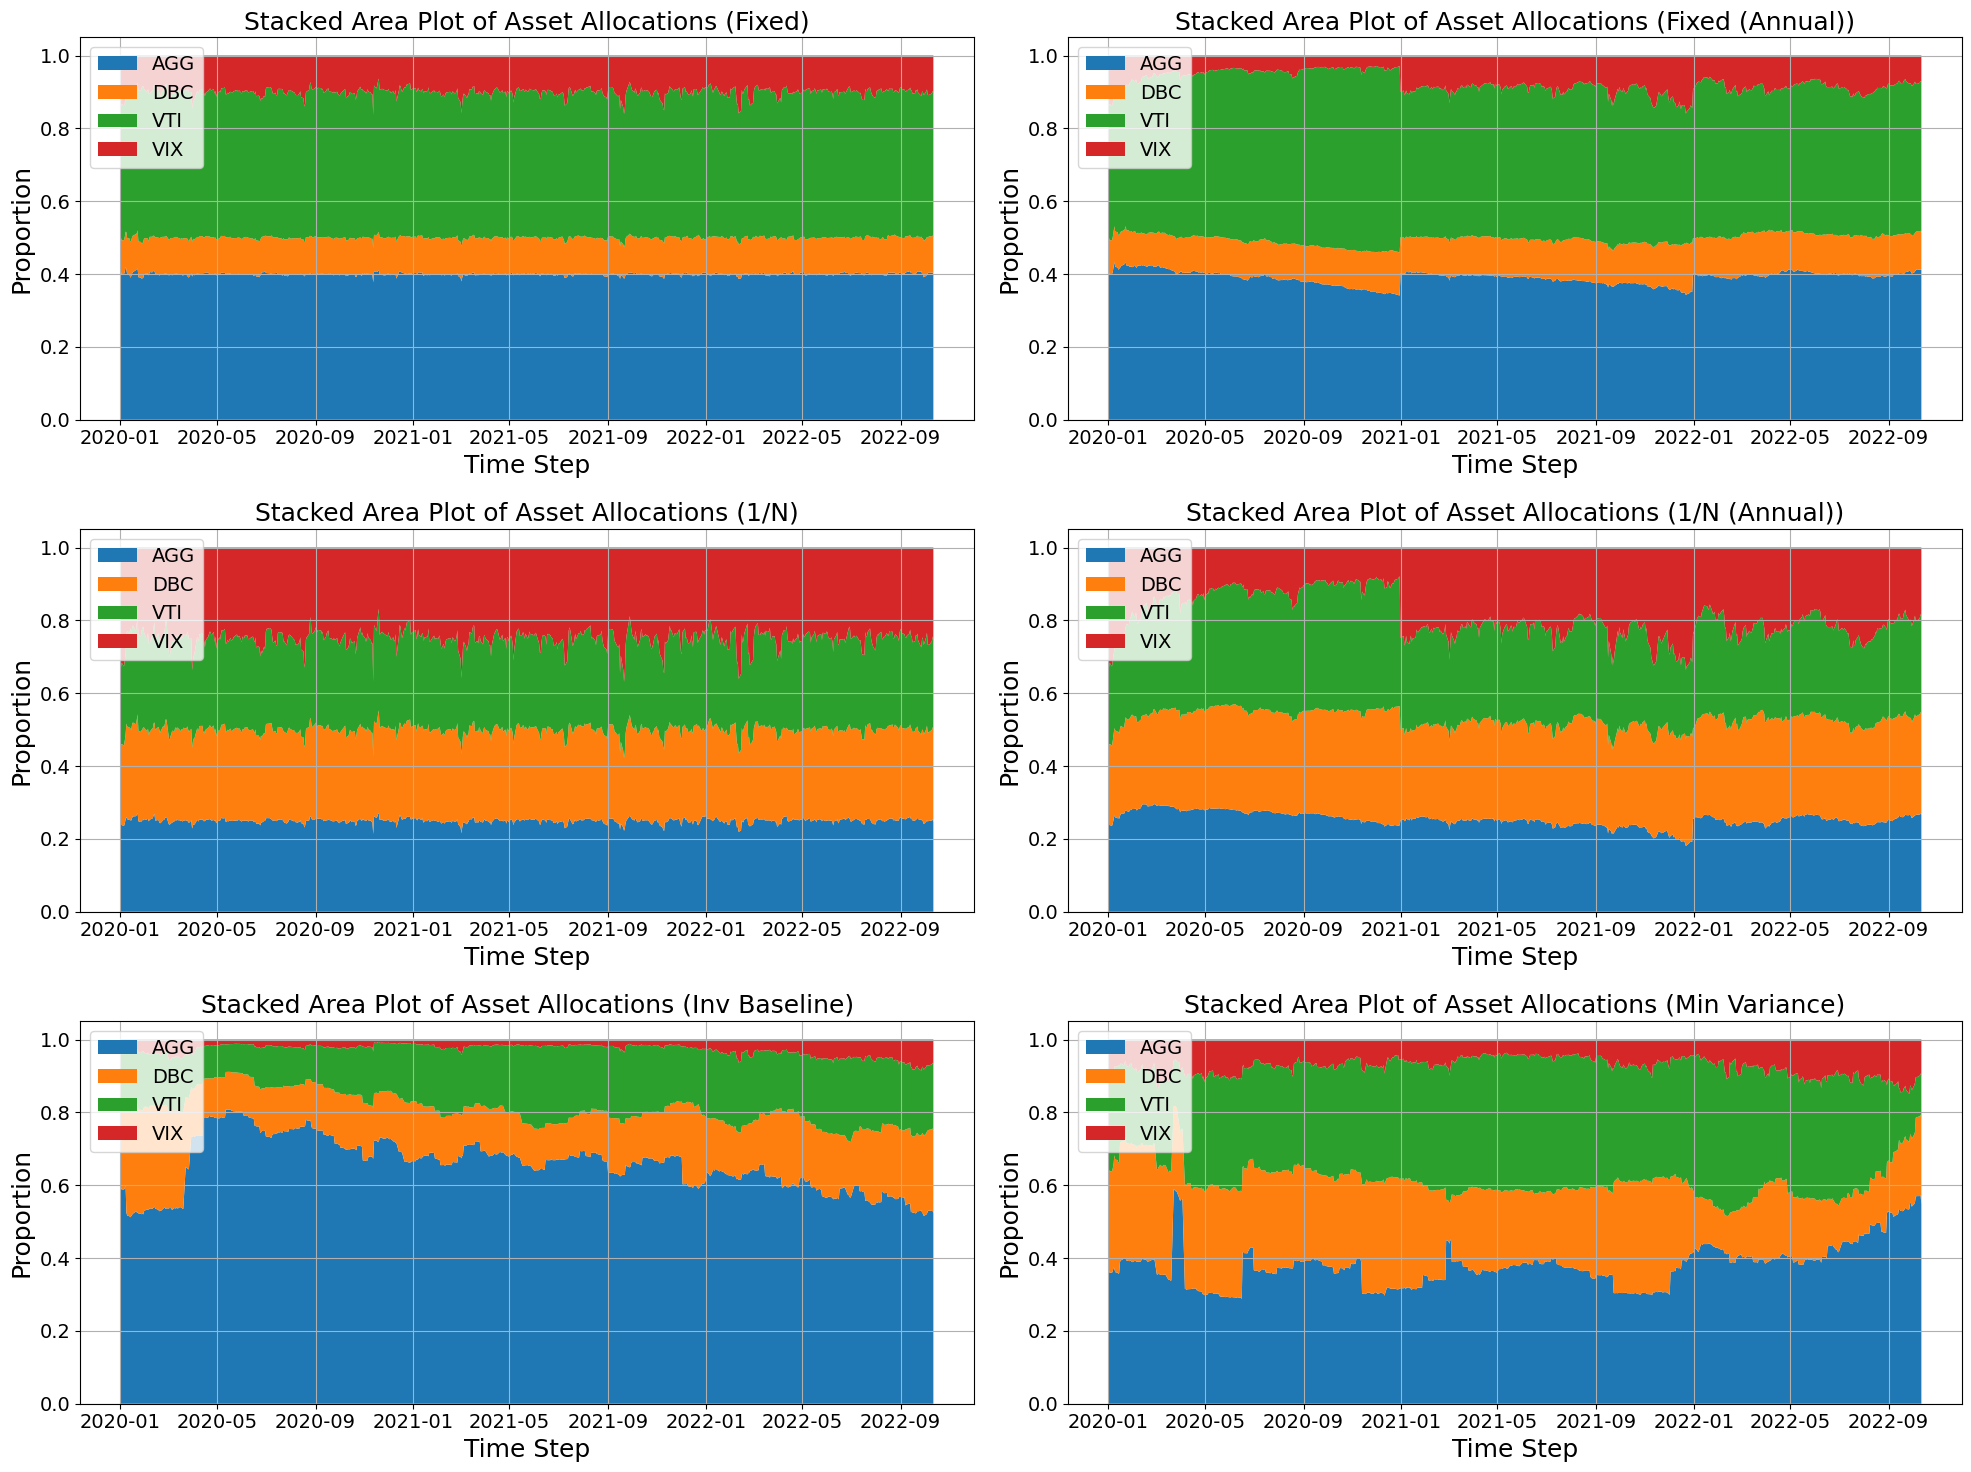

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_2762574/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return sharpe_ratio max_drawdown mean_entropy  \
Fixed                    0.464       0.0755       0.0966         1.19   
Fixed (Annual)           0.229       0.0366        0.165          1.2   
1/N                      0.735       0.0474         0.24         1.38   
1/N (Annual)             0.222       0.0243        0.351         1.38   
Inv Baseline             0.196        0.147       0.0245        0.885   
Min Variance             0.235        0.083       0.0779         1.23   

               mean_return std_return  
Fixed             0.000632    0.00837  
Fixed (Annual)    0.000373     0.0102  
1/N                0.00113     0.0238  
1/N (Annual)      0.000665     0.0274  
Inv Baseline      0.000284    0.00193  
Min Variance      0.000347    0.00418

(637,)
(637,)
(637,)
(637,)
(637,)
(637,)


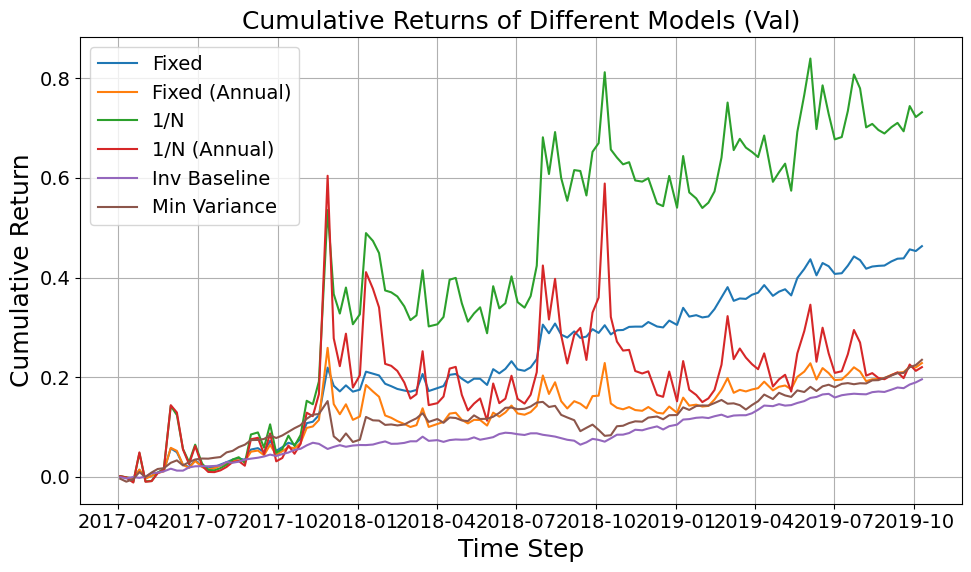

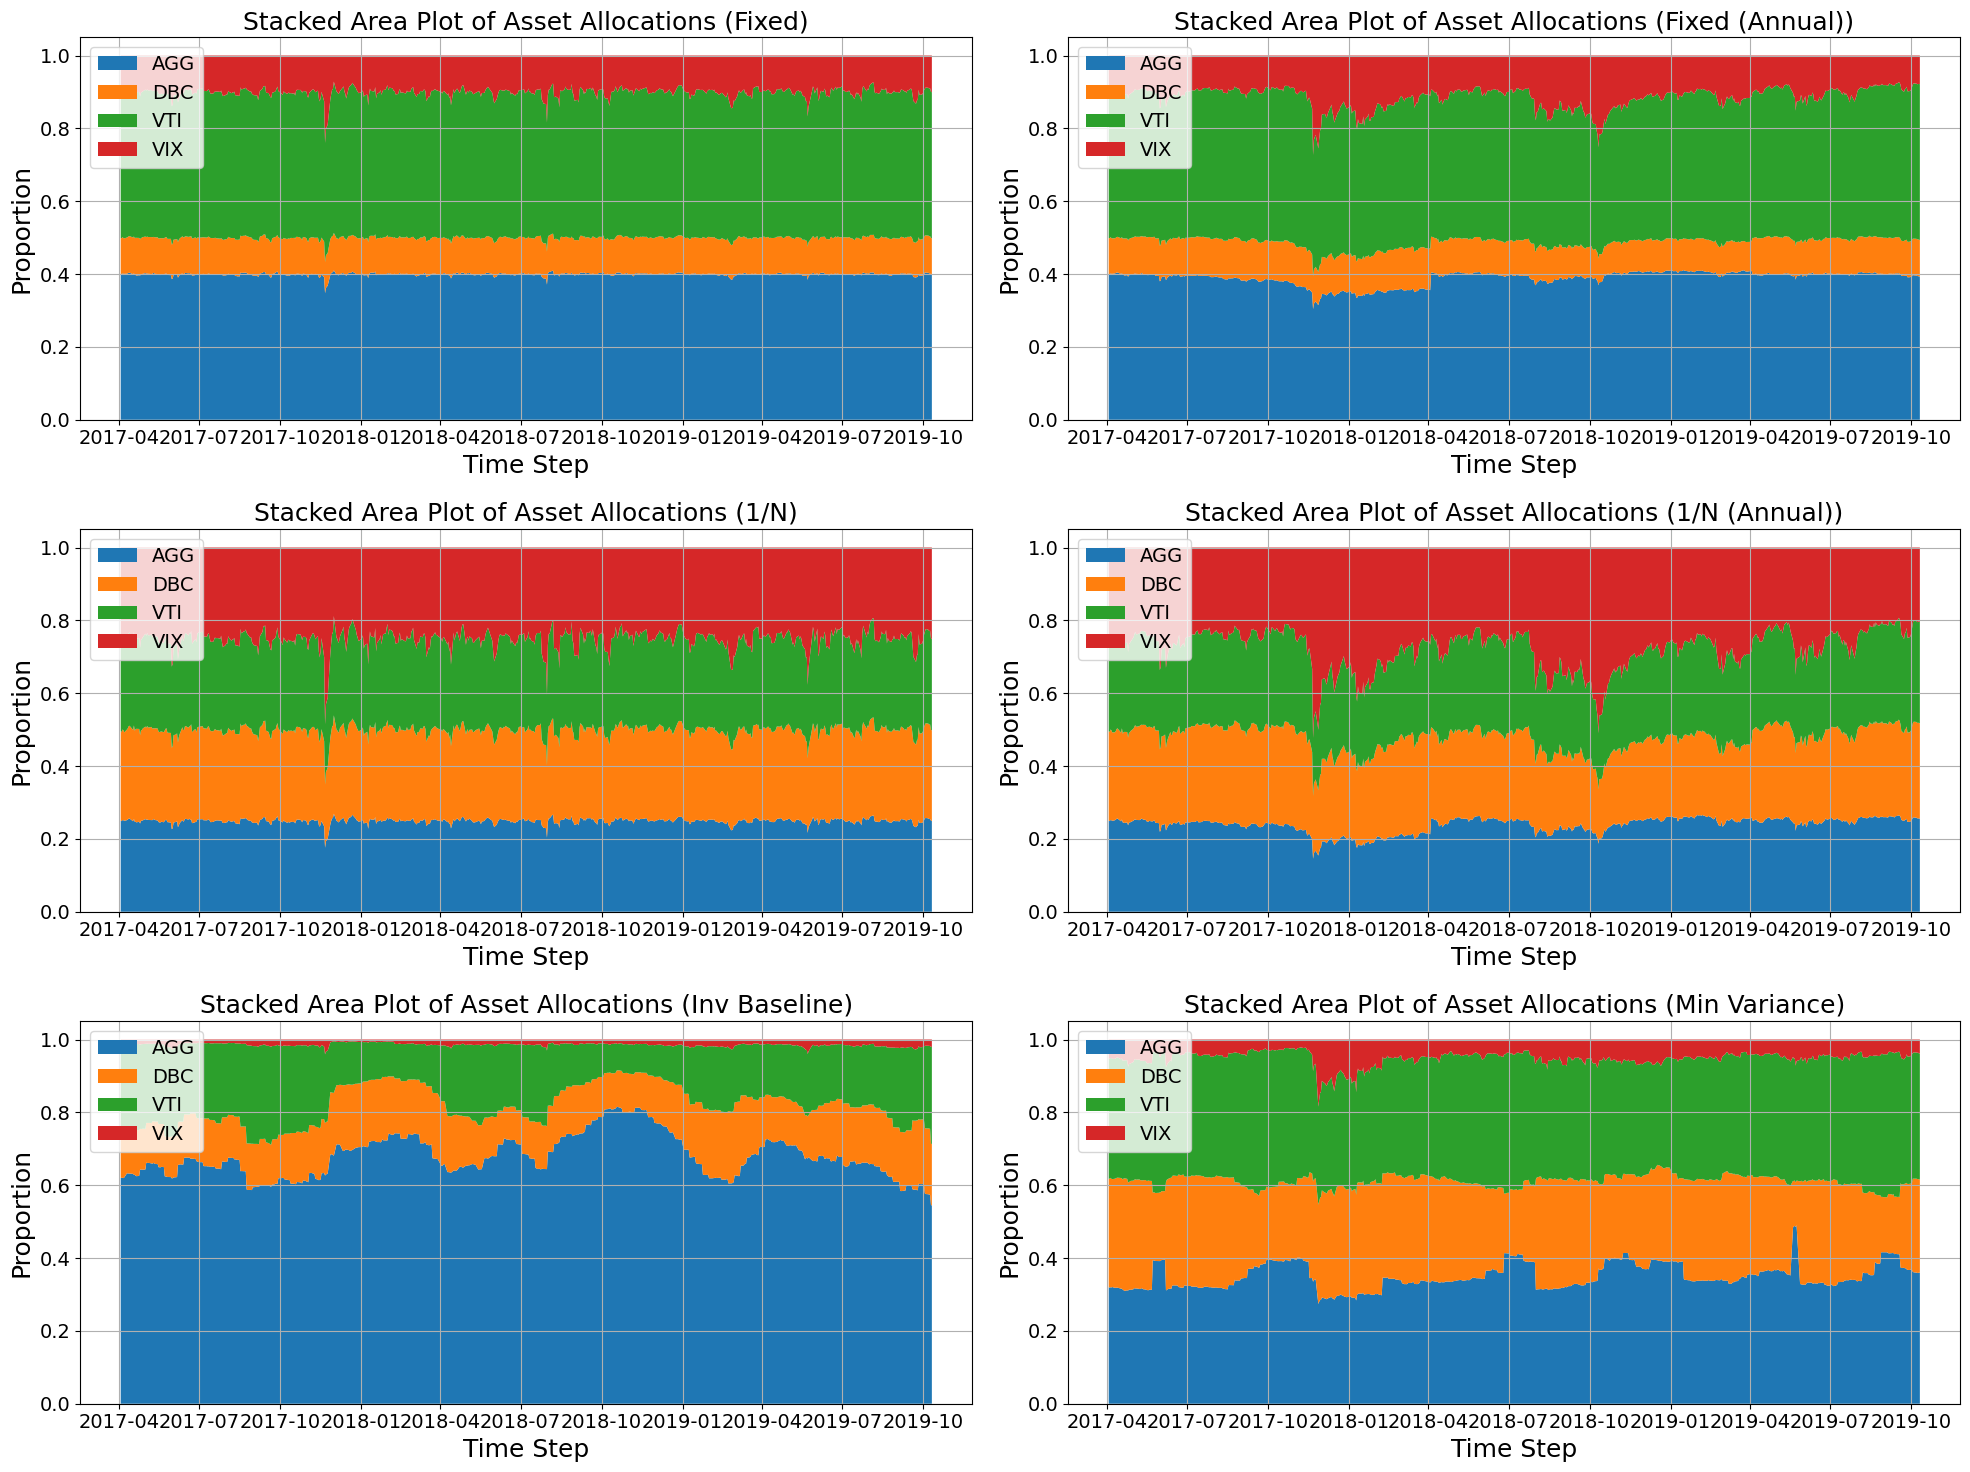

In [20]:
experiments = {}

experiments["Fixed"] = {"model": FixedWeightModel(torch.tensor([0.4, 0.1, 0.4, 0.1])), "params": { "rebalance_freq": 5}, "results": {}}
experiments["Fixed (Annual)"] = {"model": FixedWeightModel(torch.tensor([0.4, 0.1, 0.4, 0.1])), "params": { "rebalance_freq": 252}, "results": {}}
experiments["1/N"] = {"model": UniformModel(), "params": { "rebalance_freq": 5}, "results": {}}
experiments["1/N (Annual)"] = {"model": UniformModel(), "params": { "rebalance_freq": 252}, "results": {}}
experiments["1/N"] = {"model": UniformModel(), "params": { "rebalance_freq": 5}, "results": {}}
experiments["1/N (Annual)"] = {"model": UniformModel(), "params": { "rebalance_freq": 252}, "results": {}}
experiments["Inv Baseline"] = {"model": InverseVolModel(saved_mean, saved_std), "params": {"rebalance_freq": 5}, "results": {}}
experiments["Min Variance"] = {"model": MinVarianceModel(saved_mean, saved_std), "params": {"label": "Uniform Baseline", "rebalance_freq": 5}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor[:], y_test_tensor[:][:, 0:1, :].squeeze(1)), experiment)

for dataset_key, dataset_idx in zip(["test", "val"], [test_idx[:], val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

baselines = experiments.copy()

In [21]:


seeds = [10, 5, 6]

alphas = [0.0625, 0.1250, 0.25, 0.3750, 0.5, 0.75, 1]

params_grids = [
    {
    "seed": seeds,
    "epochs": [60],
    "lambda_entropy": [0.000],
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["Standard"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],

},
{
    "seed": seeds,
    "epochs": [100],
    "lambda_entropy": [0.025],
    "model": ["LSTM_Unrolled"],
    "lstm_hidden_layers" : [1],
    "lstm_hidden_size": [8],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "loss": ["Standard"],
    "jitter": [1.5],
}
]


def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, robust_loss_fn_fn, dataset_fn, device=device)

experiments = {k: v for k,v in experiments.items() if v["params"]["checkpoint"] == v["params"]["epochs"] }

for model_name, experiment in experiments.items():
    model = experiment["model"]
   
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=5,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=6,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_hidden_layers=1,lstm_hidden_size=8,learning_rate=0.001,rebalance_freq=5,loss=Standard,jitter=1.5,checkpoint=100.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=5,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_hidden_layers=1,lstm_hidden_size=8,learning_rate=0.001,rebalance_freq=5,loss=Sta

In [22]:
import matplotlib.pyplot as plt
import numpy as np


to_plot = {
    "LSTM": experiments["seed=10 epochs=100 lambda_entropy=0.025 model=LSTM_Unrolled checkpoint=100"],
    "LSTM2": experiments["seed=5 epochs=100 lambda_entropy=0.025 model=LSTM_Unrolled checkpoint=100"],
    "LSTM3": experiments["seed=6 epochs=100 lambda_entropy=0.025 model=LSTM_Unrolled checkpoint=100"],
    "CNN": experiments["seed=10 epochs=60 lambda_entropy=0.0 model=CNN checkpoint=60"],
    "CNN2": experiments["seed=5 epochs=60 lambda_entropy=0.0 model=CNN checkpoint=60"],
    "CNN3": experiments["seed=6 epochs=60 lambda_entropy=0.0 model=CNN checkpoint=60"],
    "1/N": baselines["1/N"],
    "Fixed": baselines["Fixed"],
    "Inverse Volatility": baselines["Inv Baseline"],
    "Min Variance": baselines["Min Variance"],
}

# to_plot = experiments | baselines
crs = { ek: e["results"]["test"]["raw"]["cum_returns"][::5] for ek, e in to_plot.items() }

cumulative_returns_dict = crs

time_points = test_indices[:-55][::5]#range(1, len(next(iter(cumulative_returns_dict.values()))) + 1)

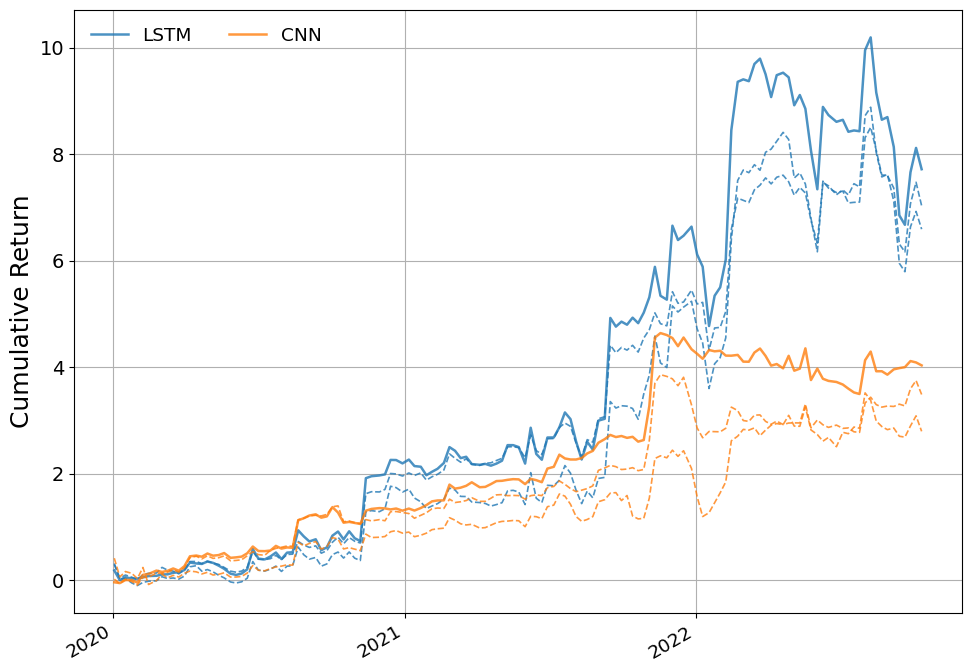

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

cr = cumulative_returns_dict
tp = time_points

lstm_keys = [k for k in cr if k.startswith("LSTM")]
cnn_keys  = [k for k in cr if k.startswith("CNN")]
baseline_keys = [k for k in cr if k not in (*lstm_keys, *cnn_keys)]

best_lstm = max(lstm_keys, key=lambda k: cr[k][-1])
best_cnn  = max(cnn_keys,  key=lambda k: cr[k][-1])

plt.figure(figsize=(10, 7))

for k in lstm_keys:
    ls = "-" if k == best_lstm else "--"
    lbl = "LSTM" if k == best_lstm else None
    plt.plot(tp, cr[k],
             color="C0", linestyle=ls,
             linewidth=1.8 if ls=="-" else 1.2,
             alpha=0.8,
             label=lbl)


for k in cnn_keys:
    ls = "-" if k == best_cnn else "--"
    lbl = "CNN" if k == best_cnn else None
    plt.plot(tp, cr[k],
             color="C1", linestyle=ls,
             linewidth=1.8 if ls=="-" else 1.2,
             alpha=0.8,
             label=lbl)



ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize="small")

plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend(fontsize="small", frameon=False, ncol=2)
plt.tight_layout()
plt.show()


# Impact of Robustness on return variablity

### Standard Performance Of Robust + Standard Models 

In [24]:
seeds = [10, 5, 6]

alphas = [0.0625, 0.1250, 0.25, 0.3750, 0.5, 0.75, 1]

params_grids = [
    # Standard Models
    {
    "seed": [10],
    "epochs": [60],
    "lambda_entropy": [0.000], # Removed from loss function
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["Standard"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],

},
# Robust Models
    {
    "seed": seeds,
    "epochs": [60],
    "lambda_entropy": [0.000],
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["CROWN-IBP"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    "robust_eps": [0.01],
    "alpha": alphas,
    "warmup": [20]
},
]


def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, robust_loss_fn_fn, dataset_fn, device=device)

for model_name, experiment in experiments.items():
    model = experiment["model"]
   
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=Standard,jitter=1.5,weight_decay=1e-05,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.0625,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.125,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN

/tmp/ipykernel_2762574/3805463404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')
/tmp/ipykernel_2762574/3805463404.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


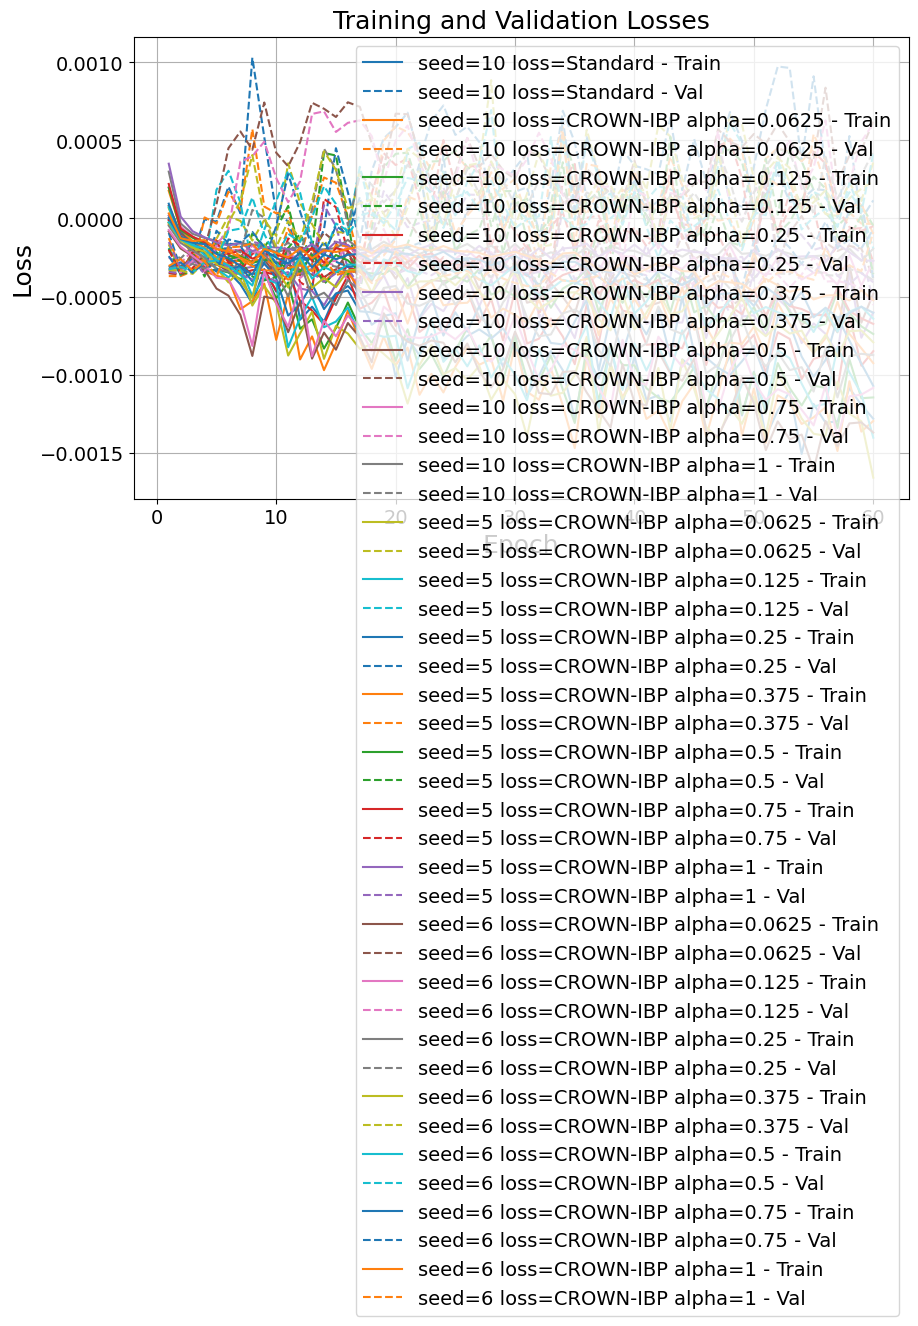

In [25]:
display_train_results(experiments)

Dataset test, Seed: 10


/tmp/ipykernel_2762574/1161597947.py:15: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(range(len(cum_returns)), cum_returns, label=label)


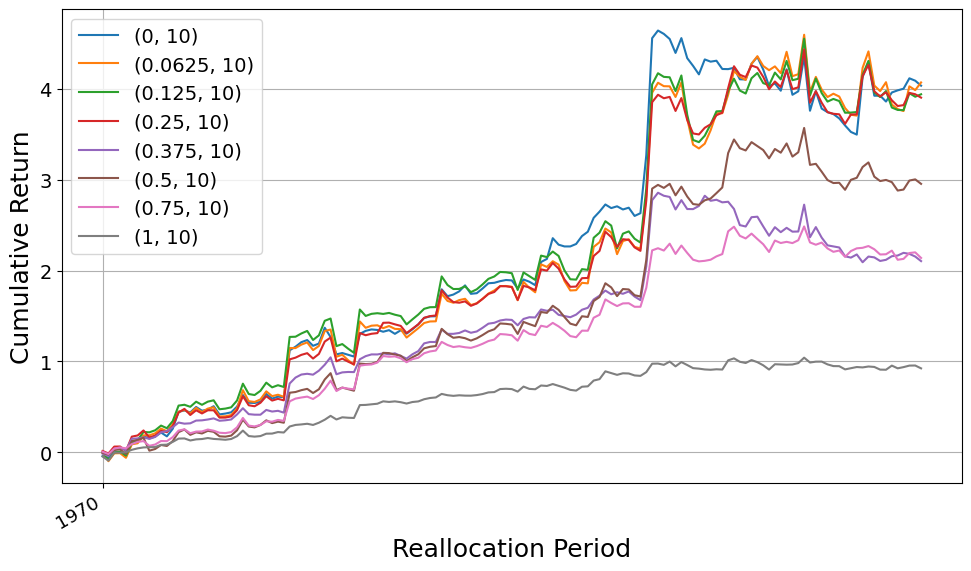

Dataset val, Seed: 10


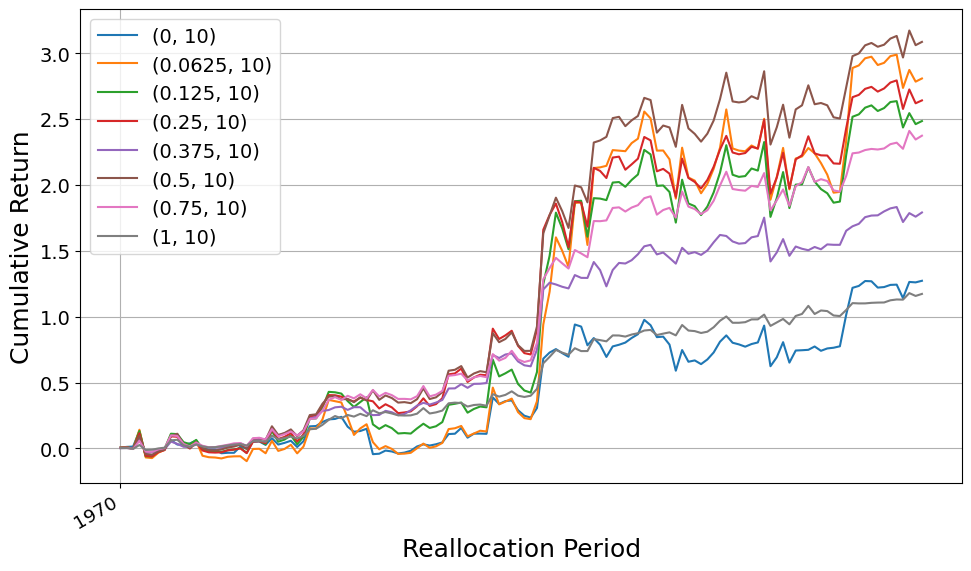

Dataset test, Seed: 5


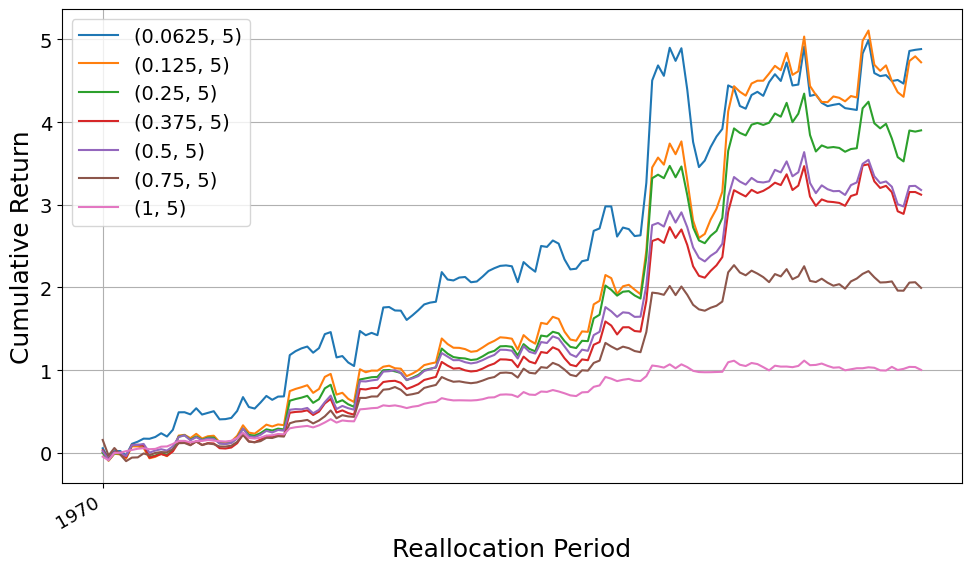

Dataset val, Seed: 5


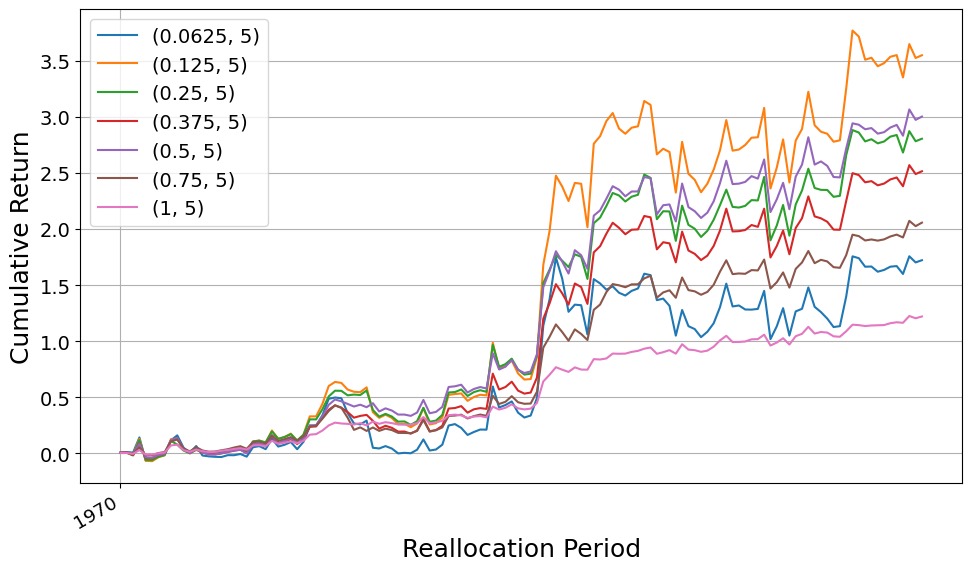

Dataset test, Seed: 6


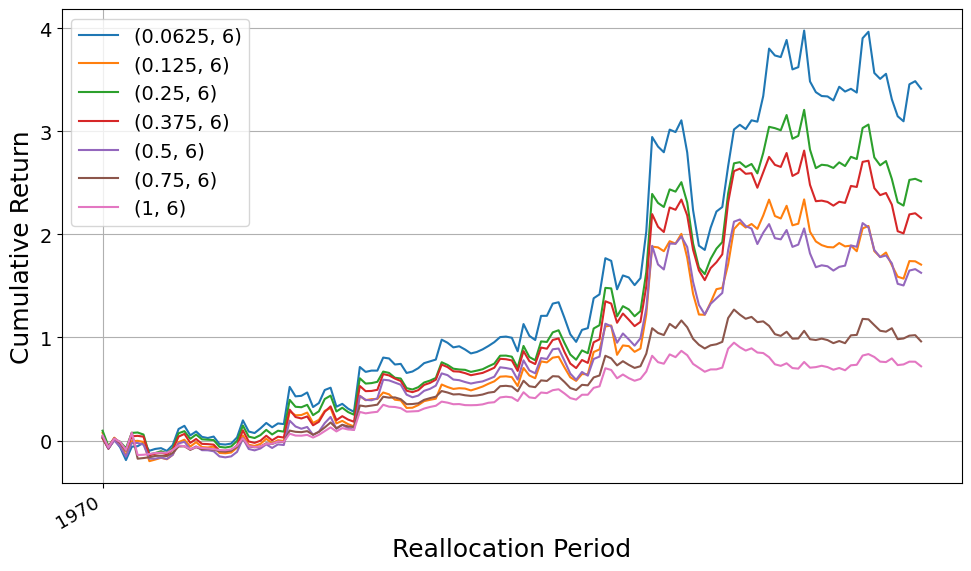

Dataset val, Seed: 6


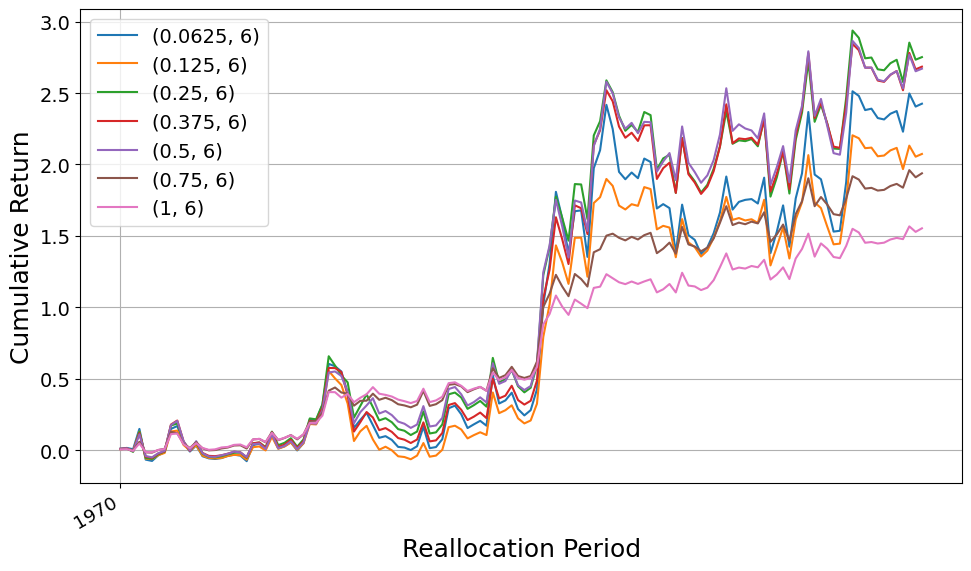

In [26]:
import matplotlib.pyplot as plt
import numpy as np

for seed in seeds:
    for dataset in ["test", "val"]:
        print(f"Dataset {dataset}, Seed: {seed}")
        crs = { (e["params"].get("alpha",0), e["params"]["seed"]) : e["results"][dataset]["raw"]["cum_returns"][::5] for ek, e in experiments.items() if seed == e["params"]["seed"]}

        cumulative_returns_dict = crs

        time_points = test_indices[50:-5][::5]#range(1, len(next(iter(cumulative_returns_dict.values()))) + 1)

        plt.figure(figsize=(10, 6))
        for label, cum_returns in cumulative_returns_dict.items():
            plt.plot(range(len(cum_returns)), cum_returns, label=label)

        plt.xlabel("Reallocation Period")
        plt.ylabel("Cumulative Return")
        # plt.ylim(bottom=0)  # Ensure returns start at zero or above
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [27]:
# Hyperparam search
best_per_alpha = {}
for alpha in [0] + alphas:
    alpha_exps = { ek: e for ek, e in experiments.items() if e["params"].get("alpha", 0) == alpha and e["params"]["seed"]  == 10}

    best_params = hyperparam_search(alpha_exps)

    alpha_seed_exps = { ek: e for ek, e in alpha_exps.items() if e["params"]["seed"] == best_params["seed"]}

    assert len(alpha_seed_exps) == 1

    best_per_alpha[alpha] = list(alpha_seed_exps.values())[0]

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate      loss  jitter  \
0      60             0.0   CNN          0.001  Standard     1.5   

   weight_decay  checkpoint  mean_val_expected_return  
0       0.00001          60                  1.280182

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate       loss  jitter  \
0      60             0.0   CNN          0.001  CROWN-IBP     1.5   

   weight_decay  robust_eps   alpha  warmup  checkpoint  \
0       0.00001        0.01  0.0625      20          60   

   mean_val_expected_return  
0                   2.83122

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate       loss  jitter  \
0      60             0.0   CNN          0.001  CROWN-IBP     1.5   

   weight_decay  robust_eps  alpha  warmup  checkpoint  \
0       0.00001        0.01  0.125      20          60   

   mean_val_expected_return  
0                  2.504178

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate       loss  jitter  \
0      60             0.0   CNN          0.001  CROWN-IBP     1.5   

   weight_decay  robust_eps  alpha  warmup  checkpoint  \
0       0.00001        0.01   0.25      20          60   

   mean_val_expected_return  
0                  2.660498

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate       loss  jitter  \
0      60             0.0   CNN          0.001  CROWN-IBP     1.5   

   weight_decay  robust_eps  alpha  warmup  checkpoint  \
0       0.00001        0.01  0.375      20          60   

   mean_val_expected_return  
0                  1.800158

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate       loss  jitter  \
0      60             0.0   CNN          0.001  CROWN-IBP     1.5   

   weight_decay  robust_eps  alpha  warmup  checkpoint  \
0       0.00001        0.01    0.5      20          60   

   mean_val_expected_return  
0                  3.104201

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate       loss  jitter  \
0      60             0.0   CNN          0.001  CROWN-IBP     1.5   

   weight_decay  robust_eps  alpha  warmup  checkpoint  \
0       0.00001        0.01   0.75      20          60   

   mean_val_expected_return  
0                  2.384534

Hyperparam Search over seeds


epochs  lambda_entropy model  learning_rate       loss  jitter  \
0      60             0.0   CNN          0.001  CROWN-IBP     1.5   

   weight_decay  robust_eps  alpha  warmup  checkpoint  \
0       0.00001        0.01      1      20          60   

   mean_val_expected_return  
0                  1.176625

/tmp/ipykernel_2762574/3969507025.py:6: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(range(len(cum_returns)), cum_returns, label=label)


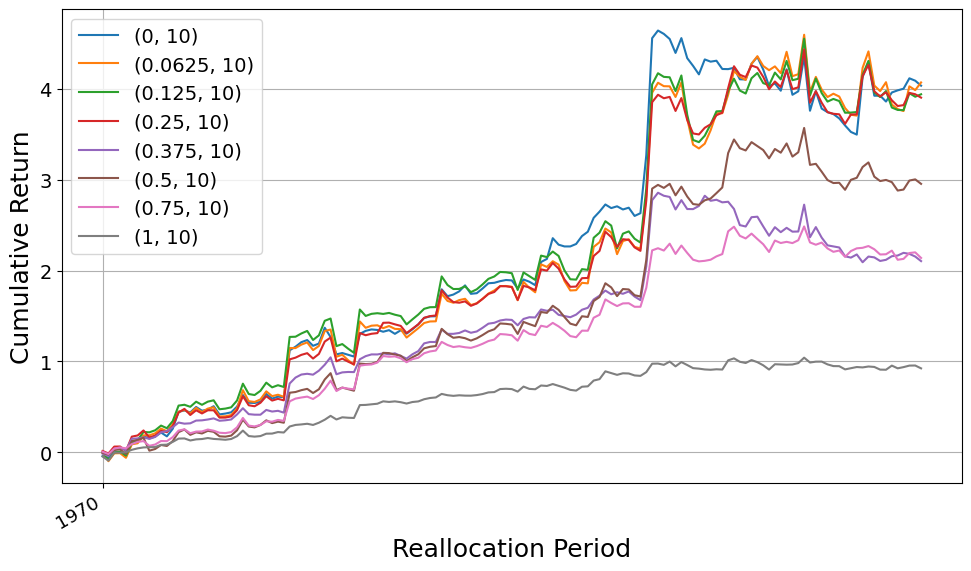

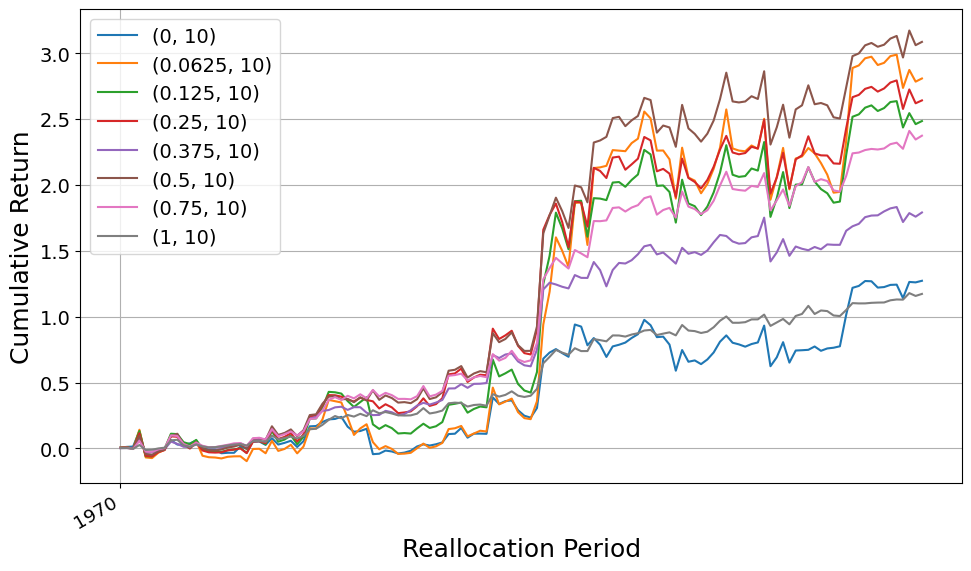

In [28]:

for dataset in ["test", "val"]:
    cumulative_returns_dict = { (e["params"].get("alpha",0), e["params"]["seed"]) : e["results"][dataset]["raw"]["cum_returns"][::5] for ek, e in best_per_alpha.items()}

    plt.figure(figsize=(10, 6))
    for label, cum_returns in cumulative_returns_dict.items():
        plt.plot(range(len(cum_returns)), cum_returns, label=label)

    plt.xlabel("Reallocation Period")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Allocation distribution

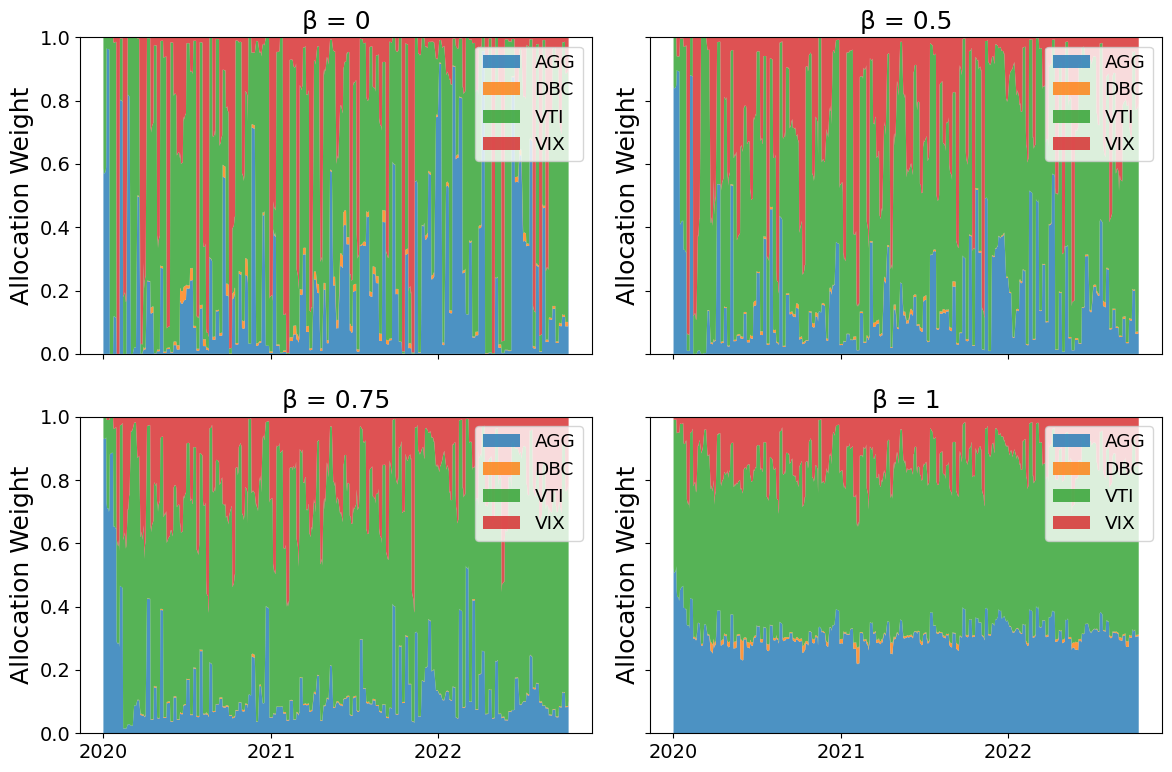

In [29]:
robust_weights = { e["params"].get("alpha", 0): e["results"]["test"]["raw"]["weights"] for ek,e in best_per_alpha.items() if e["params"].get("alpha", 0) in [0,0.5,0.75, 1]}

weights_dict = robust_weights

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()


for ax, (label, weights) in zip(axes, robust_weights.items()):
   ax.stackplot(test_indices[:-55] ,
                weights[:, 0],
                weights[:, 1],
                weights[:, 2],
           weights[:, 3],
                labels=asset_names,
                alpha=0.8)
   ax.set_title(f"β = {label}")
   ax.set_ylabel("Allocation Weight")
   ax.set_ylim(0, 1)
   ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=1, maxticks=6))
   ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
   ax.legend(loc='upper right', fontsize='small')


fig.tight_layout()
plt.show()


In [30]:
mean_entropies = { e["params"].get("alpha",0): entropy(e["results"]["test"]["raw"]["weights"]).mean() for ek,e in best_per_alpha.items()}
mean_entropies

{0: tensor(0.6059),
 0.0625: tensor(0.5771),
 0.125: tensor(0.5884),
 0.25: tensor(0.6460),
 0.375: tensor(0.6000),
 0.5: tensor(0.7764),
 0.75: tensor(0.7853),
 1: tensor(0.9763)}

In [31]:
import numpy as np

def performance_metrics(daily_returns):

    r = np.asarray(daily_returns, dtype=float)
    n = len(r)
    if n == 0:
        raise ValueError("daily_returns array is empty")
    
    cumulative_return = np.prod(1 + r) - 1
    years = n / 252.0
    annual_return = (1 + cumulative_return) ** (1 / years) - 1
    
    vol_daily = np.std(r, ddof=0)
    annual_volatility = vol_daily * np.sqrt(252)
    
    if annual_volatility != 0:
        sharpe_ratio = annual_return / annual_volatility
    else:
        sharpe_ratio = np.nan

    wealth_index = np.cumprod(1 + r)
    running_max = np.maximum.accumulate(wealth_index)
    drawdowns = (running_max - wealth_index) / running_max
    max_drawdown = np.max(drawdowns)
    
    return {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }


#### Main Results Table

In [32]:
metrics = { e["params"].get("alpha",0): performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in experiments.items()}

pd.DataFrame([ {"beta": k} | v for k,v in metrics.items()])

beta  annual_return  annual_volatility  sharpe_ratio  max_drawdown
0  0.0000       0.816723           0.492078      1.659741      0.268146
1  0.0625       0.691750           0.645461      1.071715      0.322758
2  0.1250       0.394771           0.576886      0.684314      0.283347
3  0.2500       0.521704           0.599086      0.870833      0.292686
4  0.3750       0.501418           0.586649      0.854716      0.289369
5  0.5000       0.394346           0.568968      0.693089      0.277069
6  0.7500       0.259150           0.349645      0.741181      0.234970
7  1.0000       0.195234           0.305312      0.639458      0.200379

### Robustness Of Robust + Standard Models

In [33]:
def get_robustness(experiments, test_eps, test_delta, extra_args ={}, force_run=False):
    results = {}
    default_params = {
        "config": "jamie.yaml",
        "device": "cuda",
        "start": "0",
        "end": "151",
        "conv_mode": "matrix",
    } | extra_args


    model_paths = []

    to_model = {
    }
    namer = {

    }
    params = {}
    for k,v  in experiments.items():

        robust_cnn_path = os.path.join(experiment_path, model_file_name(v["params"]))
        model_paths.append(robust_cnn_path)
        namer[robust_cnn_path] = v["params"].get("alpha", 0)
        params[robust_cnn_path] = v["params"]
        to_model[robust_cnn_path] = v["model"]



    for model_path in model_paths:
        results[model_path] = {}

        
        for eps in test_eps:
            results[model_path][eps] = {}
            for delta in test_delta:
                path = model_path[:-4] + f"_e={eps}_d={delta}"
                for k,v in extra_args.items():
                    path+="_{k}={v}"
                output_path = path + "_output.pkl"
                results_path = path + "_results.txt" 
                cex_path = path + "_cex.json"
                debug_path = path + "_debug.txt"  

                if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
                    print(f"No results found, running at {eps}, {delta}")
                    args = default_params | {
                        "epsilon": eps,
                        "delta": delta,
                        "output_file": output_path,
                        "results_file": results_path,
                        "cex_path": cex_path,
                        "load_model": model_path,
                    }
                    run_abcrown_from_dict_ipython(args, debug_path)

                
                if os.path.isfile(output_path) and os.path.isfile(results_path) and os.path.isfile(cex_path):
                    print("loading results")
                    with open(output_path, "rb") as f:
                        output_data = pickle.load(f)
                    with open(results_path, "rb") as f:
                        results_data = pickle.load(f)  
                    with open(cex_path, "r") as f:
                        cex_data = json.load(f)
                else:
                    print("failed to load results")
                    output_data = None
                    results_data = None    

                results[model_path][eps][delta] = {"results_data": results_data, "output_data": output_data, "cex_data": cex_data}

    to_df = []
    for model_path, model_path_dict in results.items():
        for eps, eps_dict in model_path_dict.items():
            for delta, delta_dict in eps_dict.items():

                Xc_test_tensor = X_test_tensor.clone()
                c = 0


                for i in range(0,Xc_test_tensor.shape[0], 5):
                    if i // 5 in delta_dict["results_data"]["summary"]["unsafe-pgd"]:
                        avd = torch.tensor(delta_dict["cex_data"]["x"][c]).reshape(50,4)
                        c += 1
                        Xc_test_tensor[i] = avd

                true_run = run_experiment(to_model[model_path], (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
                fake_run = run_experiment(to_model[model_path], (Xc_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

                cp = round((fake_run["metrics"]["expected_return"] - true_run["metrics"]["expected_return"]) / true_run["metrics"]["expected_return"], 2)
                band_width = np.mean(np.abs(fake_run["raw"]["cum_returns"] - true_run["raw"]["cum_returns"]))
                

                params_i = params[model_path]
                summary_agg = {}
                if delta_dict["results_data"] is not None:
                    summary = delta_dict["results_data"]["summary"]
                    for k, v in summary.items():
                        summary_agg[k] = len(v)

                

                to_df.append({
                    "model_path": namer[model_path],
                    "eps": eps,
                    "delta": delta,
                    "cp": cp,
                    # "seed": seed,
                    "band_width": band_width,
                    "fake": fake_run["metrics"]["expected_return"],
                    "true": true_run["metrics"]["expected_return"],
                    "fake_returns": fake_run["raw"]["cum_returns"],
                    "true_returns": true_run["raw"]["cum_returns"],
                    "summary":  delta_dict["results_data"]["summary"],
                    "adv_X": delta_dict["cex_data"]["x"]
                } | summary_agg | params_i)

    # df = pd.DataFrame(to_df)
    return to_df


#### Main Results Table

In [34]:
test_eps = [0.1]
test_delta = [0.225]
to_df = get_robustness(best_per_alpha, test_eps, test_delta)

metrics = { e["params"].get("alpha",0): performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in best_per_alpha.items()}

for item in to_df:
    alpha = item["model_path"]
    robust = item.get("safe-incomplete",0)+item.get("safe-complete",0)
    nonrobust = item.get("unsafe-pgd",0)
    unknown = item.get("unknown",0)


    robsut_per =  robust / (robust+nonrobust+unknown)
    cp = item["cp"]
    band_width = item["band_width"]

    metrics[alpha] = metrics[alpha] | {"robust": robsut_per, "cp": cp, "band_width": band_width}

df = pd.DataFrame([ {"beta": k} | v for k,v in metrics.items()])
df

loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results


beta  annual_return  annual_volatility  sharpe_ratio  max_drawdown  \
0  0.0000       0.816723           0.492078      1.659741      0.268146   
1  0.0625       0.794423           0.521165      1.524320      0.297068   
2  0.1250       0.777702           0.509233      1.527203      0.312894   
3  0.2500       0.762433           0.461551      1.651895      0.288271   
4  0.3750       0.510782           0.298076      1.713596      0.209736   
5  0.5000       0.643431           0.406779      1.581772      0.253170   
6  0.7500       0.505595           0.272606      1.854671      0.168614   
7  1.0000       0.287203           0.166412      1.725858      0.093561   

     robust    cp  band_width  
0  0.119205 -0.93    2.086618  
1  0.298013 -0.60    1.137306  
2  0.417219 -0.57    1.279018  
3  0.562914 -0.61    1.067857  
4  0.900662 -0.07    0.067307  
5  0.900662 -0.09    0.094190  
6  1.000000  0.00    0.000000  
7  1.000000  0.00    0.000000

## Sensitivity to pertubation magnitude

In [82]:
def get_robustness(experiments, test_eps, test_delta, extra_args ={}, force_run=False):
    results = {}
    default_params = {
        "config": "default_params.yaml",
        "device": "cuda",
        "start": "0",
        "end": "151",
        "conv_mode": "matrix",
    } | extra_args


    model_paths = []

    to_model = {
    }
    namer = {

    }
    params = {}
    for k,v  in experiments.items():

        robust_cnn_path = os.path.join(experiment_path, model_file_name(v["params"]))
        model_paths.append(robust_cnn_path)
        namer[robust_cnn_path] = v["params"].get("alpha", 0)
        params[robust_cnn_path] = v["params"]
        to_model[robust_cnn_path] = v["model"]



    for model_path in model_paths:
        results[model_path] = {}

        
        for eps in test_eps:
            results[model_path][eps] = {}
            for delta in test_delta:
                path = model_path[:-4] + f"_e={eps}_d={delta}"
                path = path.replace("lstm_hidden_layers=1,lstm_hidden_size=8,", "")
                for k,v in extra_args.items():
                    path+="_{k}={v}"
                output_path = path + "_output.pkl"
                results_path = path + "_results.txt" 
                cex_path = path + "_cex.json"
                debug_path = path + "_debug.txt"  

                if not os.path.isfile(output_path) or not os.path.isfile(results_path) or force_run:
                    print(f"No results found, running at {eps}, {delta}")
                    args = default_params | {
                        "epsilon": eps,
                        "delta": delta,
                        "output_file": output_path,
                        "results_file": results_path,
                        "cex_path": cex_path,
                        "load_model": model_path,
                    }
                    run_abcrown_from_dict_ipython(args, debug_path)

                
                if os.path.isfile(output_path) and os.path.isfile(results_path) and os.path.isfile(cex_path):
                    print("loading results")
                    with open(output_path, "rb") as f:
                        output_data = pickle.load(f)
                    with open(results_path, "rb") as f:
                        results_data = pickle.load(f)  
                    with open(cex_path, "r") as f:
                        cex_data = json.load(f)
                else:
                    print("failed to load results")
                    output_data = None
                    results_data = None    

                results[model_path][eps][delta] = {"results_data": results_data, "output_data": output_data, "cex_data": cex_data}

    to_df = []
    for model_path, model_path_dict in results.items():
        for eps, eps_dict in model_path_dict.items():
            for delta, delta_dict in eps_dict.items():

                Xc_test_tensor = X_test_tensor.clone()
                c = 0


                for i in range(0,Xc_test_tensor.shape[0], 5):
                    if i // 5 in delta_dict["results_data"]["summary"]["unsafe-pgd"]:
                        avd = torch.tensor(delta_dict["cex_data"]["x"][c]).reshape(50,4)
                        c += 1
                        Xc_test_tensor[i] = avd

                true_run = run_experiment(to_model[model_path], (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
                fake_run = run_experiment(to_model[model_path], (Xc_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

                cp = round((fake_run["metrics"]["expected_return"] - true_run["metrics"]["expected_return"]) / true_run["metrics"]["expected_return"], 2)
                band_width = np.mean(np.abs(fake_run["raw"]["cum_returns"] - true_run["raw"]["cum_returns"]))
                

                params_i = params[model_path]
                summary_agg = {}
                if delta_dict["results_data"] is not None:
                    summary = delta_dict["results_data"]["summary"]
                    for k, v in summary.items():
                        summary_agg[k] = len(v)

                

                to_df.append({
                    "model_path": namer[model_path],
                    "eps": eps,
                    "delta": delta,
                    "cp": cp,
                    # "seed": seed,
                    "band_width": band_width,
                    "fake": fake_run["metrics"]["expected_return"],
                    "true": true_run["metrics"]["expected_return"],
                    "fake_returns": fake_run["raw"]["cum_returns"],
                    "true_returns": true_run["raw"]["cum_returns"],
                    "summary":  delta_dict["results_data"]["summary"],
                    "adv_X": delta_dict["cex_data"]["x"]
                } | summary_agg | params_i)

    return to_df


loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results


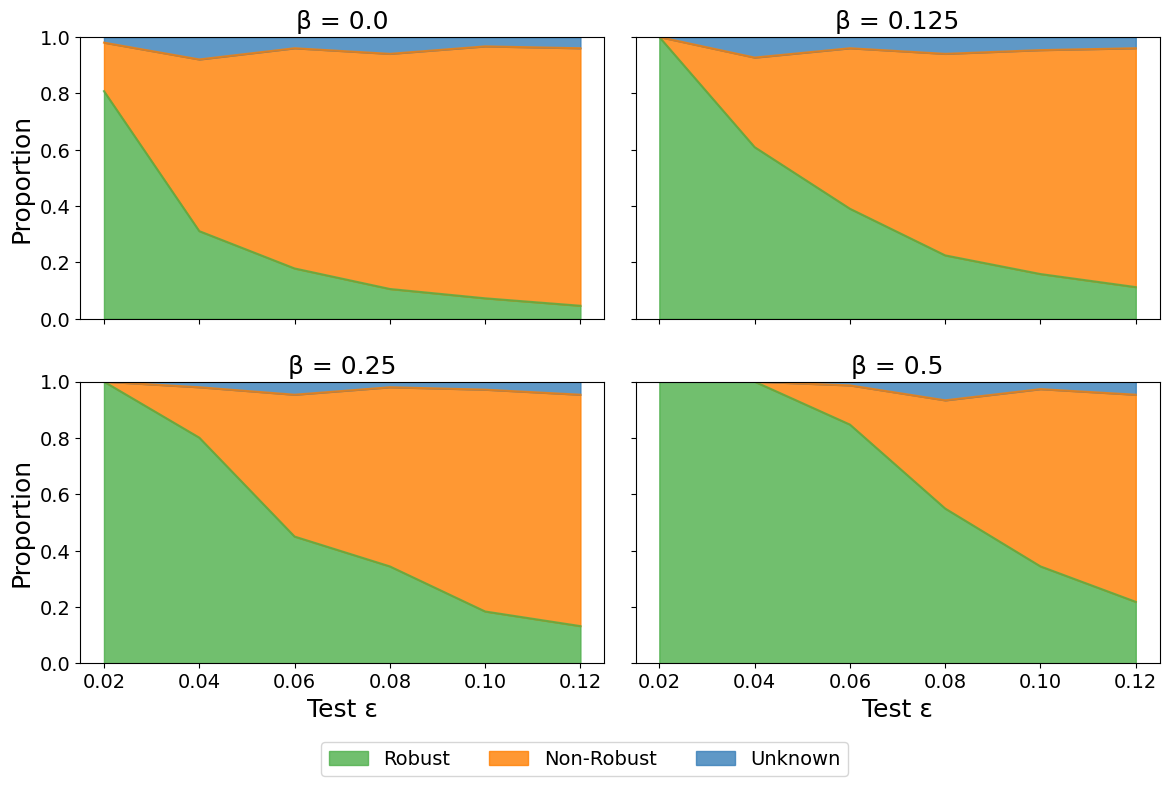

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

filtered = {k: v for k,v in best_per_alpha.items() if v["params"].get("alpha", 0) in [0, 0.125, 0.25, 0.5]}

test_eps = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12]
test_delta = [0.1]

to_df = get_robustness(filtered, test_eps, test_delta)
df = pd.DataFrame(to_df)

col_renames = {
    'unknown': 'Unknown',
    'safe-incomplete': 'Robust',
    'unsafe-pgd': 'Non-Robust'
}

palette = plt.get_cmap('Set1')
colors = {
    'Robust':     palette(2),  
    'Non-Robust': palette(4),  
    'Unknown':    palette(1)   
}

models = df['model_path'].unique()
cols = 2
rows = (len(models) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, model in zip(axes, models):
    sub = (
        df[df['model_path'] == model]
        .set_index('eps')[['unsafe-pgd','safe-incomplete','unknown']]
    )
    prop = sub.div(sub.sum(axis=1), axis=0).rename(columns=col_renames)
    prop = prop[['Robust', 'Non-Robust', 'Unknown']]
    prop.plot(
        kind='area',
        stacked=True,
        ax=ax,
        legend=False,
        color=[colors[c] for c in prop.columns],
        alpha=0.8
    )
    ax.set_title(f"β = {model}")
    ax.set_xlabel('Test ε')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1)

for ax in axes[len(models):]:
    fig.delaxes(ax)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()



## Counterfactual Return Comparison

In [37]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

loading results
loading results
loading results


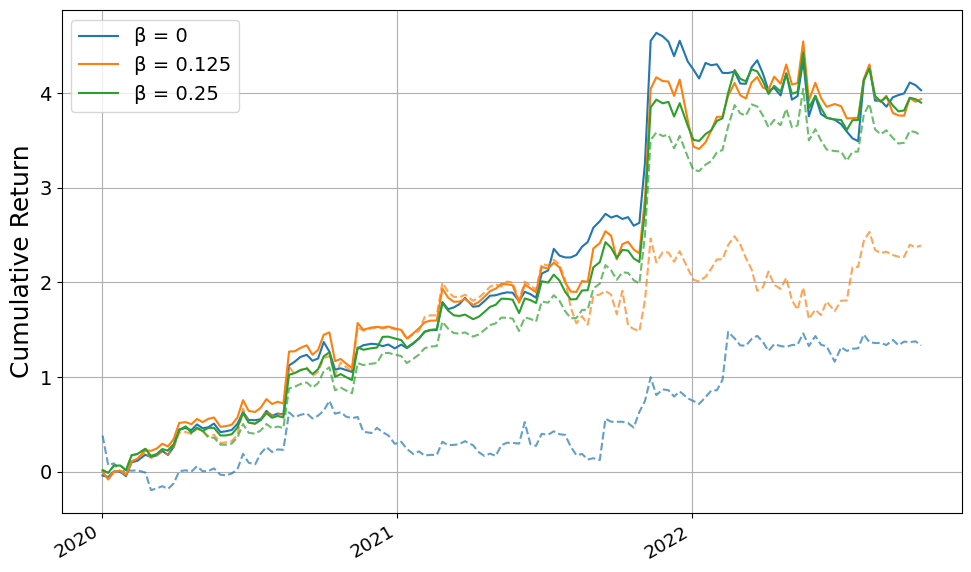

In [38]:
filtered = {k: v for k,v in best_per_alpha.items() if v["params"].get("alpha", 0) in [0, 0.125, 0.25]}

test_eps = [0.1]
test_delta = [0.3]

to_df = get_robustness(filtered, test_eps, test_delta)
plt.figure(figsize=(10, 6))
for j, row in enumerate(to_df):

    crs_fake = row["fake_returns"][::5]
    crs =row["true_returns"][::5]


    time_idx = test_indices[:-55][::5]
    

    plt.plot(time_idx, crs, label=f"β = {row['model_path']}", color=colors[j])
    plt.plot(time_idx, crs_fake, color=colors[j], alpha=0.7, linestyle='--')


plt.ylabel("Cumulative Return")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

plt.grid(True)
plt.tight_layout()
plt.show()

## Robustness vs Counterfactual return

loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
151
151
151
151
151
151
151
151


seed  annual_return  annual_volatility  sharpe_ratio  max_drawdown  \
0.0000 10  10.0       0.816723           0.492078      1.659741      0.268146   
0.0625 10  10.0       0.794423           0.521165      1.524320      0.297068   
0.1250 10  10.0       0.777702           0.509233      1.527203      0.312894   
0.2500 10  10.0       0.762433           0.461551      1.651895      0.288271   
0.3750 10  10.0       0.510782           0.298076      1.713596      0.209736   
0.5000 10  10.0       0.643431           0.406779      1.581772      0.253170   
0.7500 10  10.0       0.505595           0.272606      1.854671      0.168614   
1.0000 10  10.0       0.287203           0.166412      1.725858      0.093561   

             beta    robust    cp  band_width  
0.0000 10  0.0000  0.119205 -0.93    2.086618  
0.0625 10  0.0625  0.298013 -0.60    1.137306  
0.1250 10  0.1250  0.417219 -0.57    1.279018  
0.2500 10  0.2500  0.562914 -0.61    1.067857  
0.3750 10  0.3750  0.900662 -0.07    0.067307  
0.5000 10  0.5000  0.900662 -0.09    0.094190  
0.7500 10  0.7500  1.000000  0.00    0.000000  
1.0000 10  1.0000  1.000000  0.00    0.000000

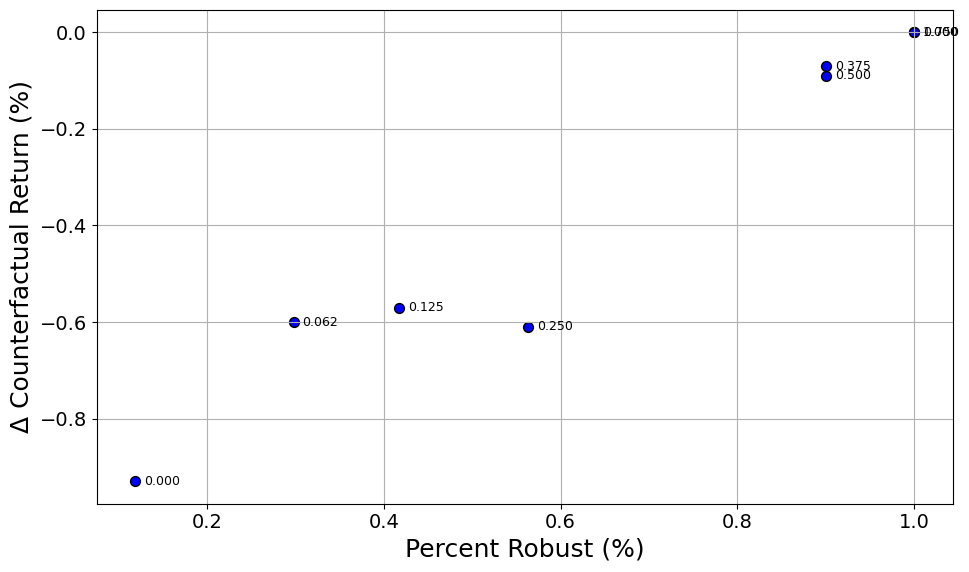

In [39]:
filtered = {k: v for k,v in best_per_alpha.items() if v["params"].get("alpha", 0) or True}

test_eps = [0.1]
test_delta = [0.225]

to_df = get_robustness(filtered, test_eps, test_delta)

metrics = { (e["params"].get("alpha",0),e["params"]["seed"]) : {"seed": e["params"]["seed"]} | performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in filtered.items()}

for item in to_df:
    alpha = item["model_path"]
    seed = item["seed"]
    robust = item.get("safe-incomplete",0)
    nonrobust = item.get("unsafe-pgd",0)
    unknown = item.get("unknown",0)

    robsut_per =  robust / (robust+nonrobust+unknown)

    print(robust+nonrobust+unknown)
    cp = item["cp"]
    band_width = item["band_width"]

    metrics[(alpha, seed)] = metrics[(alpha, seed)] | {"beta": alpha, "robust": robsut_per, "cp": cp, "band_width": band_width}


df_eps_02 = pd.DataFrame(metrics).T

display(df_eps_02)
plt.figure(figsize=(10, 6))
plt.scatter(
    df_eps_02['robust'],
    df_eps_02['cp'],
    s=50,
    color='blue',
    edgecolor='k'
)
for i, row in df_eps_02.iterrows():
    plt.text(
        row['robust'] + 0.01,
        row['cp'],
        f"{row['beta']:.3f}",
        fontsize=9,
        va='center'
    )
plt.xlabel('Percent Robust (%)')
plt.ylabel('Δ Counterfactual Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

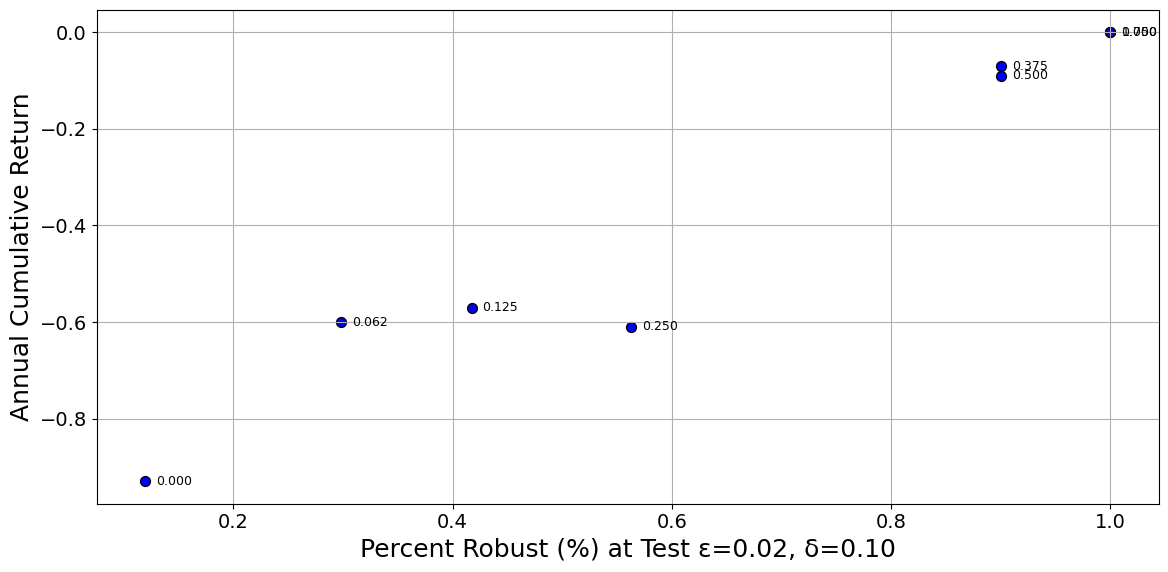

In [40]:
plt.figure(figsize=(12, 6))
plt.scatter(
    df_eps_02['robust'],
    df_eps_02['cp'],
    s=50,
    color='blue',
    edgecolor='k'
)
for i, row in df_eps_02.iterrows():
    plt.text(
        row['robust'] + 0.01,
        row['cp'],
        f"{row['beta']:.3f}",
        fontsize=9,
        va='center'
    )
plt.xlabel('Percent Robust (%) at Test ε=0.02, δ=0.10')
plt.ylabel('Annual Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# Alternative specificaitons

In [41]:

seeds = [10, 5, 6]

alphas = [0, 0.0625, 0.1250, 0.25, 0.3750, 0.5, 0.75, 1]

params_grids = [

    {
    "seed": seeds,
    "epochs": [60],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["CROWN-IBP"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    "robust_eps": [0.01],
    "alpha": alphas,
    "warmup": [20]
},


]


def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, robust_loss_fn_fn, dataset_fn, device=device)

experiments = {k: v for k,v in experiments.items() if v["params"]["checkpoint"] == v["params"]["epochs"] }

for model_name, experiment in experiments.items():
    model = experiment["model"]
   
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)



Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.0625,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.125,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model

In [42]:
test_eps = [0.1]
test_delta = [0.0025]
to_df = get_robustness(experiments, test_eps, test_delta, extra_args={"robustness_type": "MR"})

loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results


In [43]:


metrics = { (e["params"].get("alpha",0), e["params"]["seed"]): performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in experiments.items()}

for item in to_df:
    alpha = item["model_path"]
    seed = item["seed"]
    robust = item.get("safe-incomplete",0)
    nonrobust = item.get("unsafe-pgd",0)
    unknown = item.get("unknown",0)


    robsut_per =  robust / (robust+nonrobust+unknown)
    cp = item["cp"]
    band_width = item["band_width"]

    metrics[(alpha,seed)] = metrics[(alpha,seed)] | {"robust": robsut_per, "cp": cp, "band_width": band_width}

df_MR = pd.DataFrame([ {"beta": k[0], "seed": k[1]}| v for k,v in metrics.items()]) 

In [44]:
df_MR

beta  seed  annual_return  annual_volatility  sharpe_ratio  \
0   0.0000    10       1.464674           0.604637      2.422404   
1   0.0625    10       0.794423           0.521165      1.524320   
2   0.1250    10       0.777702           0.509233      1.527203   
3   0.2500    10       0.762433           0.461551      1.651895   
4   0.3750    10       0.510782           0.298076      1.713596   
5   0.5000    10       0.643431           0.406779      1.581772   
6   0.7500    10       0.505595           0.272606      1.854671   
7   1.0000    10       0.287203           0.166412      1.725858   
8   0.0000     5       0.628335           0.569237      1.103821   
9   0.0625     5       0.857259           0.552554      1.551449   
10  0.1250     5       0.871240           0.582263      1.496300   
11  0.2500     5       0.772760           0.525195      1.471376   
12  0.3750     5       0.647307           0.465043      1.391931   
13  0.5000     5       0.662288           0.444993      1.488311   
14  0.7500     5       0.409246           0.345586      1.184208   
15  1.0000     5       0.306490           0.176306      1.738394   
16  0.0000     6       0.204551           0.628034      0.325700   
17  0.0625     6       0.691750           0.645461      1.071715   
18  0.1250     6       0.394771           0.576886      0.684314   
19  0.2500     6       0.521704           0.599086      0.870833   
20  0.3750     6       0.501418           0.586649      0.854716   
21  0.5000     6       0.394346           0.568968      0.693089   
22  0.7500     6       0.259150           0.349645      0.741181   
23  1.0000     6       0.195234           0.305312      0.639458   

    max_drawdown    robust    cp  band_width  
0       0.357133  0.432624 -0.92    4.178220  
1       0.297068  0.539007 -0.96    1.710460  
2       0.312894  0.638298 -0.96    1.633597  
3       0.288271  0.652482 -0.93    1.583843  
4       0.209736  0.794326 -0.72    0.852451  
5       0.253170  0.716312 -0.79    0.937444  
6       0.168614  0.893617 -0.37    0.379881  
7       0.093561  0.971631 -0.14    0.061968  
8       0.305316  0.432624 -1.23    1.383560  
9       0.288564  0.432624 -1.04    2.206606  
10      0.323972  0.517730 -1.00    1.777082  
11      0.297312  0.560284 -0.97    1.502240  
12      0.263333  0.638298 -0.90    1.131904  
13      0.254726  0.702128 -0.81    0.999044  
14      0.192941  0.829787 -0.52    0.421387  
15      0.108255  0.964539 -0.15    0.070912  
16      0.392463  0.340426 -1.65    1.250539  
17      0.322758  0.432624 -1.19    1.776213  
18      0.283347  0.503546 -1.31    1.009358  
19      0.292686  0.517730 -1.15    1.300883  
20      0.289369  0.617021 -1.01    0.943478  
21      0.277069  0.687943 -0.98    0.685039  
22      0.234970  0.893617 -0.46    0.170855  
23      0.200379  0.943262 -0.27    0.072527

In [45]:


metrics = { (e["params"].get("alpha",0), e["params"]["seed"]): performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in experiments.items()}

for item in to_df:
    alpha = item["model_path"]
    robust = item.get("safe-incomplete",0)
    nonrobust = item.get("unsafe-pgd",0)
    unknown = item.get("unknown",0)

    robsut_per =  robust / (robust+nonrobust+unknown)
    cp = item["cp"]
    band_width = item["band_width"]

    print(robust)

    metrics[(alpha,seed)] = metrics[(alpha,seed)] | {"robust": robsut_per, "cp": cp, "band_width": band_width}

df_spike = pd.DataFrame([ {"beta": k[0], "seed": k[1]} | v for k,v in metrics.items()])

metrics

61
76
90
92
112
101
126
137
61
61
73
79
90
99
117
136
48
61
71
73
87
97
126
133


{(0, 10): {'annual_return': 1.4646742131495305,
  'annual_volatility': 0.6046366549213227,
  'sharpe_ratio': 2.422403936691729,
  'max_drawdown': 0.3571329051147799},
 (0.0625, 10): {'annual_return': 0.7944227123178327,
  'annual_volatility': 0.521165432111609,
  'sharpe_ratio': 1.5243196562348074,
  'max_drawdown': 0.29706790589619825},
 (0.125, 10): {'annual_return': 0.7777021098786225,
  'annual_volatility': 0.5092330128586893,
  'sharpe_ratio': 1.5272028526053802,
  'max_drawdown': 0.31289382334469623},
 (0.25, 10): {'annual_return': 0.762433469881002,
  'annual_volatility': 0.4615507390784,
  'sharpe_ratio': 1.6518952421209177,
  'max_drawdown': 0.28827132191983457},
 (0.375, 10): {'annual_return': 0.5107824217193493,
  'annual_volatility': 0.2980762819067467,
  'sharpe_ratio': 1.7135963265911505,
  'max_drawdown': 0.2097357831761307},
 (0.5, 10): {'annual_return': 0.6434312355580425,
  'annual_volatility': 0.406778838720272,
  'sharpe_ratio': 1.5817716515988884,
  'max_drawdown':

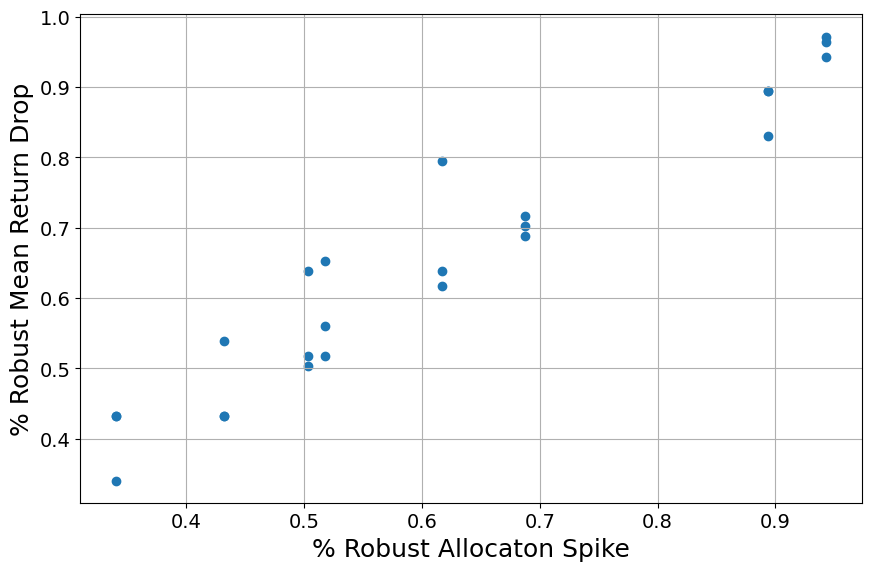

0.9607139024776127


In [46]:
import pandas as pd
import matplotlib.pyplot as plt

merged = pd.merge(
    df_spike[['beta', 'robust']], 
    df_MR[['beta', 'robust']], 
    on='beta', 
    suffixes=('_df1', '_df2')
)

corr = merged['robust_df1'].corr(merged['robust_df2'])

plt.figure(figsize=(9, 6))
plt.scatter(merged['robust_df1'], merged['robust_df2'], marker='o')
plt.xlabel('% Robust Allocaton Spike')
plt.ylabel('% Robust Mean Return Drop')
plt.grid(True)  

plt.tight_layout()
plt.show()

print(corr)

In [47]:
df_spike

beta  seed  annual_return  annual_volatility  sharpe_ratio  \
0   0.0000    10       1.464674           0.604637      2.422404   
1   0.0625    10       0.794423           0.521165      1.524320   
2   0.1250    10       0.777702           0.509233      1.527203   
3   0.2500    10       0.762433           0.461551      1.651895   
4   0.3750    10       0.510782           0.298076      1.713596   
5   0.5000    10       0.643431           0.406779      1.581772   
6   0.7500    10       0.505595           0.272606      1.854671   
7   1.0000    10       0.287203           0.166412      1.725858   
8   0.0000     5       0.628335           0.569237      1.103821   
9   0.0625     5       0.857259           0.552554      1.551449   
10  0.1250     5       0.871240           0.582263      1.496300   
11  0.2500     5       0.772760           0.525195      1.471376   
12  0.3750     5       0.647307           0.465043      1.391931   
13  0.5000     5       0.662288           0.444993      1.488311   
14  0.7500     5       0.409246           0.345586      1.184208   
15  1.0000     5       0.306490           0.176306      1.738394   
16  0.0000     6       0.204551           0.628034      0.325700   
17  0.0625     6       0.691750           0.645461      1.071715   
18  0.1250     6       0.394771           0.576886      0.684314   
19  0.2500     6       0.521704           0.599086      0.870833   
20  0.3750     6       0.501418           0.586649      0.854716   
21  0.5000     6       0.394346           0.568968      0.693089   
22  0.7500     6       0.259150           0.349645      0.741181   
23  1.0000     6       0.195234           0.305312      0.639458   

    max_drawdown    robust    cp  band_width  
0       0.357133       NaN   NaN         NaN  
1       0.297068       NaN   NaN         NaN  
2       0.312894       NaN   NaN         NaN  
3       0.288271       NaN   NaN         NaN  
4       0.209736       NaN   NaN         NaN  
5       0.253170       NaN   NaN         NaN  
6       0.168614       NaN   NaN         NaN  
7       0.093561       NaN   NaN         NaN  
8       0.305316       NaN   NaN         NaN  
9       0.288564       NaN   NaN         NaN  
10      0.323972       NaN   NaN         NaN  
11      0.297312       NaN   NaN         NaN  
12      0.263333       NaN   NaN         NaN  
13      0.254726       NaN   NaN         NaN  
14      0.192941       NaN   NaN         NaN  
15      0.108255       NaN   NaN         NaN  
16      0.392463  0.340426 -1.65    1.250539  
17      0.322758  0.432624 -1.19    1.776213  
18      0.283347  0.503546 -1.31    1.009358  
19      0.292686  0.517730 -1.15    1.300883  
20      0.289369  0.617021 -1.01    0.943478  
21      0.277069  0.687943 -0.98    0.685039  
22      0.234970  0.893617 -0.46    0.170855  
23      0.200379  0.943262 -0.27    0.072527

In [48]:
filtered = {k: v for k,v in best_per_alpha.items() if v["params"].get("alpha", 0) in [0.25]}

test_eps = [0.1]
test_delta = [0.225]
to_df_allocation_spikes = get_robustness(filtered, test_eps, test_delta)

loading results


In [49]:
filtered = {k: v for k,v in best_per_alpha.items() if v["params"].get("alpha", 0) in [0.25]}

test_eps = [0.1, 0.01]
test_delta = [0.01, 0.001, 0]

test_eps = [0.1]
test_delta = [0.01]

to_df_MR = get_robustness(filtered, test_eps, test_delta, extra_args={"robustness_type": "MR"}, force_run=False)

loading results


In [50]:
filtered = {k: v for k,v in experiments.items() if v["params"]["seed"] == 6 and v["params"].get("alpha",0) == 0.25 }



In [51]:
keys = ['safe-incomplete', 'unsafe-pgd', 'unknown']


for MR_ in to_df_MR: 
    for Alloc_ in to_df_allocation_spikes: 
        print(f'MRdelta={MR_["delta"]}, Alloc_={Alloc_["delta"]}')
        print(MR_["summary"])
        print
        counts = {
            k1: {
                k2: len(set( MR_["summary"][k1]).intersection(Alloc_["summary"][k2]))
                for k2 in keys
            }
            for k1 in keys
        }

        # Turn it into a DataFrame
        df = pd.DataFrame(counts).T[keys]
        df.index.name = 'Allocation'   # rows come from dict1’s keys
        df.columns.name = 'MR'
        print(df)

MRdelta=0.01, Alloc_=0.225
defaultdict(<class 'list'>, {'safe-incomplete': [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 71, 72, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 112, 113, 115, 117, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150], 'unsafe-pgd': [3, 7, 17, 22, 41, 54, 68, 73, 90, 103, 111, 114, 116, 118], 'unknown': [70, 80, 123, 142]})
MR               safe-incomplete  unsafe-pgd  unknown
Allocation                                           
safe-incomplete               83          32       18
unsafe-pgd                     2          11        1
unknown                        0

In [52]:
test_eps = [0.1]
test_delta_MR = [0.001]
test_delta_alloc = [0.1]

to_df_MR = get_robustness(filtered, test_eps, test_delta_MR, extra_args={"robustness_type": "MR"}, force_run=False)
to_df_allocation_spikes = get_robustness(filtered, test_eps, test_delta_alloc, force_run=False)

loading results
loading results


[32, 98, 99, 40, 41, 107, 44, 13, 77, 49, 89, 122, 93, 94]
Before -0.00041605817386880517
After tensor(-0.0004)


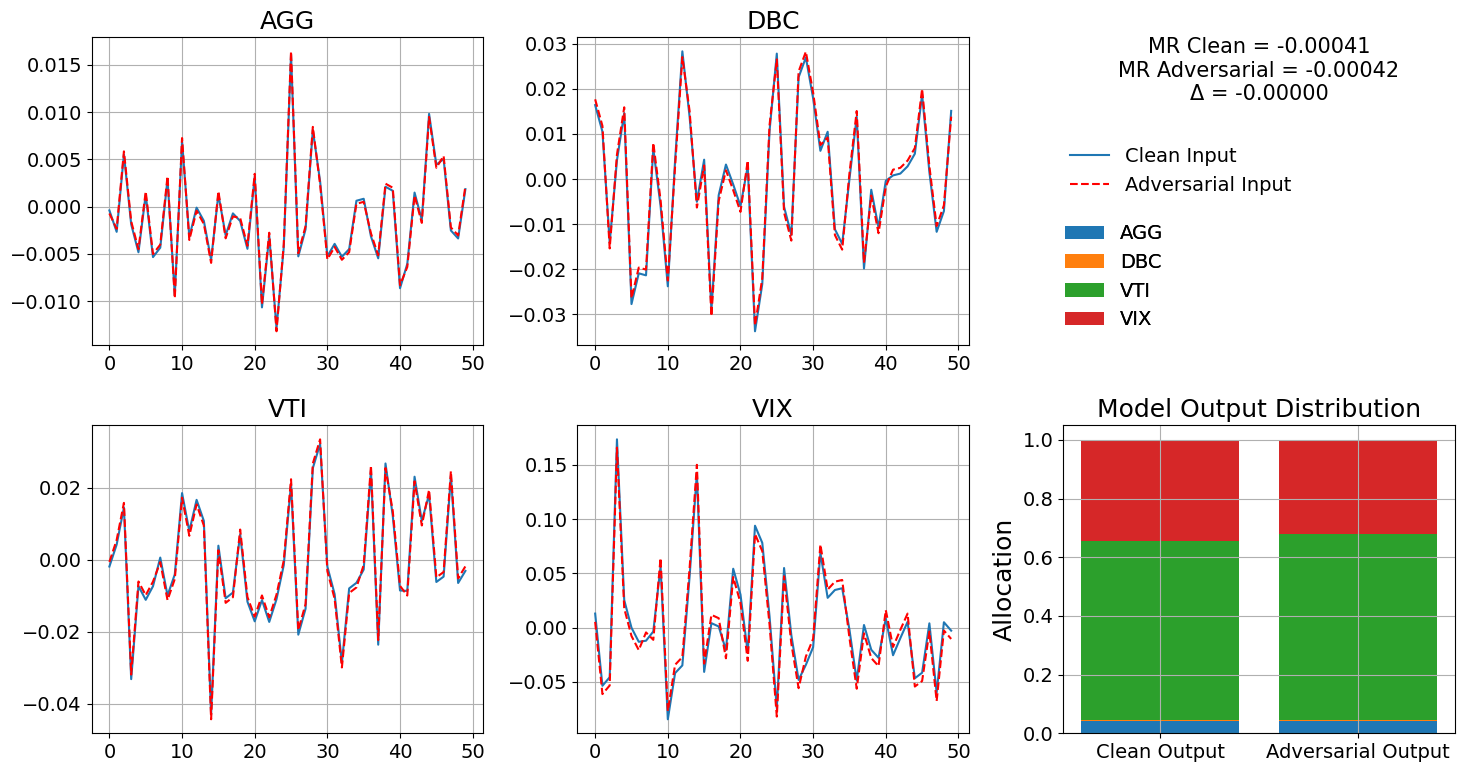

In [53]:

for MR_ in to_df_MR: 
    for Alloc_ in to_df_allocation_spikes: 

        if MR_["delta"] != 0.001 or Alloc_["delta"] != 0.1:
            continue


        print(list(set(Alloc_["summary"]["safe-incomplete"]).intersection(MR_["summary"]["unsafe-pgd"])))



        for i in list(set(MR_["summary"]["safe-incomplete"]).intersection(Alloc_["summary"]["unsafe-pgd"])):


        
            adv_X = torch.tensor(Alloc_["adv_X"][Alloc_["summary"]["unsafe-pgd"].index(i)]).reshape(50,4)

          
            
            o_X = X_test_tensor[::5][i]
            y = y_test_tensor[::5][i]


            t1 = adv_X.unsqueeze(0).to(device)
            t2 = o_X.unsqueeze(0).to(device)




            w1 =model(t1).detach().cpu()
            w2 =model(t2).detach().cpu()

            MR_delta = (y.mean(0)*w1).mean() - (y.mean(0)*w2).mean()

          

            if MR_delta > 0:

                print("Before", (y.mean(0)*w2).mean().item())
                print("After",  (y.mean(0)*w1).mean())
    

                adv_X = destandardize(adv_X.unsqueeze(1), saved_mean, saved_std).squeeze(1)
                o_X = destandardize(o_X.unsqueeze(1), saved_mean, saved_std).squeeze(1)


                categories = asset_names
                colors = ['C0', 'C1', 'C2', 'C4']
                before = w1.numpy()[0]
                after = w2.numpy()[0]


                categories  = asset_names
                colors      = ['C0', 'C1', 'C2', 'C3']
              
                mr_clean = (y.mean(0)*w1).mean().item()
                mr_adv   = (y.mean(0)*w2).mean().item()
                delta    = mr_adv - mr_clean

                fig = plt.figure(figsize=(15, 8))
                gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1])

                axes = [
                    fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1])
                ]

                handles = []
                for i, ax in enumerate(axes):
                    h_clean, = ax.plot(o_X[:, i], label='Clean Input')
                    h_adv,   = ax.plot(adv_X[:, i], linestyle='--', label='Adversarial Input', color='red')
                    if i == 0:
                        handles = [h_clean, h_adv]
                    ax.set_title(asset_names[i])
                    ax.grid(True)

                # Stacked bar chart in bottom-right cell only
                ax_stack = fig.add_subplot(gs[1, 2])
                bottom_before = bottom_after = 0
                bars = []
                for val_b, val_a, color in zip(before, after, colors):
                    bar_b = ax_stack.bar(0, val_b, bottom=bottom_before, color=color)
                    bar_a = ax_stack.bar(1, val_a, bottom=bottom_after, color=color)
                    bars.append(bar_b[0])
                    bottom_before += val_b
                    bottom_after  += val_a

                ax_stack.set_xticks([0, 1])
                ax_stack.set_xticklabels(['Clean Output', 'Adversarial Output'])
                ax_stack.set_ylabel('Allocation')
                ax_stack.set_title('Model Output Distribution')
                ax_stack.grid(True)

                ax_leg = fig.add_subplot(gs[0, 2])
                ax_leg.axis('off')

                legend1_loc = 'upper center'           
                legend1_bbox = (0.3,0.7)            
                legend2_loc = 'upper right'          
                legend2_bbox = (0.3,0.45) 

                textstr = f"MR Clean = {mr_clean:.5f}\nMR Adversarial = {mr_adv:.5f}\n\u0394 = {delta:.5f}"
                ax_leg.text(0.5, 1, textstr, ha='center', va='top', fontsize=15)

                legend1 = ax_leg.legend(handles, ['Clean Input', 'Adversarial Input'],
                                        loc=legend1_loc, bbox_to_anchor=legend1_bbox, frameon=False)
                ax_leg.add_artist(legend1)

                legend2 = ax_leg.legend(bars, categories,
                                        loc=legend2_loc, bbox_to_anchor=legend2_bbox, frameon=False)
                ax_leg.add_artist(legend2)

                plt.tight_layout()
                plt.show()

                break

            

[32, 98, 99, 40, 41, 107, 44, 13, 77, 49, 89, 122, 93, 94]
tensor([[ 0.1000,  0.1000,  0.1000, -0.1000],
        [ 0.1000, -0.1000,  0.1000, -0.1000],
        [ 0.1000, -0.1000,  0.1000, -0.1000],
        [ 0.1001, -0.1000,  0.1000, -0.1000],
        [ 0.0998, -0.1000, -0.1000, -0.1000],
        [ 0.1000, -0.1000, -0.1000, -0.1000],
        [-0.0998, -0.1000, -0.1000,  0.1000],
        [-0.1001, -0.1000, -0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000, -0.1000],
        [ 0.1000,  0.1000,  0.1000, -0.1000],
        [ 0.1000,  0.1000,  0.1000, -0.1000],
        [ 0.0999,  0.1000, -0.1000,  0.1000],
        [ 0.1000, -0.1000, -0.1000,  0.1000],
        [-0.0999, -0.1000, -0.1000,  0.1000],
        [ 0.0999, -0.1000, -0.1000,  0.1000],
        [-0.1000, -0.1000, -0.1000,  0.1000],
        [ 0.1001, -0.1000, -0.1000, -0.1000],
        [ 0.0999, -0.1000,  0.1000, -0.1000],
        [ 0.1000, -0.1000,  0.1000, -0.1000],
        [ 0.0999, -0.1000,  0.1000, -0.1000],
        [ 0.1001, -0.

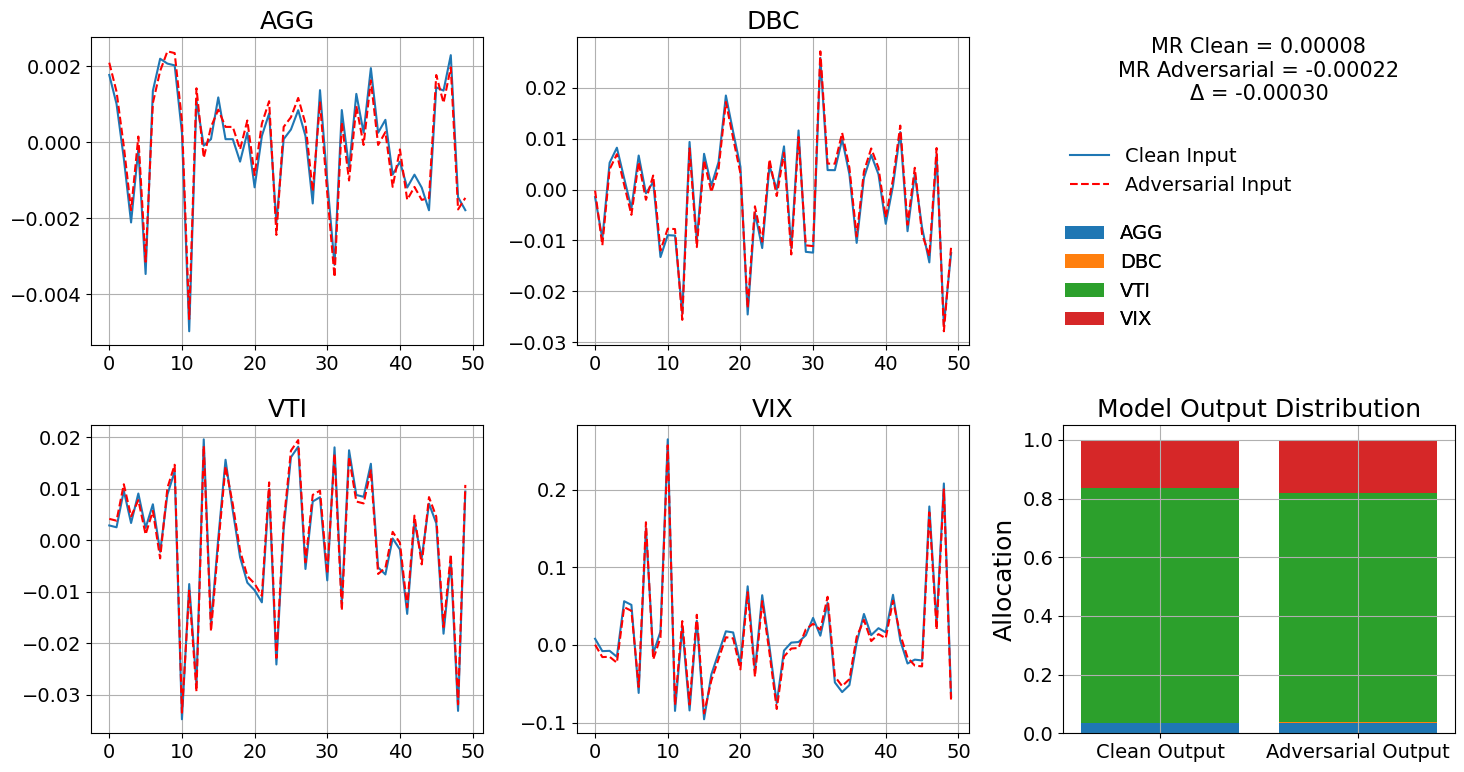

In [54]:

for MR_ in to_df_MR: 
    for Alloc_ in to_df_allocation_spikes: 

        if MR_["delta"] != 0.001 or Alloc_["delta"] != 0.1:
            continue


        print(list(set(Alloc_["summary"]["safe-incomplete"]).intersection(MR_["summary"]["unsafe-pgd"])))



        for i in list(set(Alloc_["summary"]["safe-incomplete"]).intersection(MR_["summary"]["unsafe-pgd"])):


        
            adv_X = torch.tensor(MR_["adv_X"][MR_["summary"]["unsafe-pgd"].index(i)]).reshape(50,4)

          
            
            o_X = X_test_tensor[::5][i]
            y = y_test_tensor[::5][i]

            print(adv_X - o_X)

            

            # print(adv_X.unsqueeze(0).shape)

            t1 = o_X.unsqueeze(0).to(device)
            t2 = adv_X.unsqueeze(0).to(device)

            # print(torch.max(torch.abs(o_X -adv_X)))



            w1 =model(t1).detach().cpu()
            w2 =model(t2).detach().cpu()

            MR_delta = (y.mean(0)*w1).mean() - (y.mean(0)*w2).mean()

          

            if True:

                print("Before", (y.mean(0)*w1).mean().item())
                print("After",  (y.mean(0)*w2).mean())
                # break

       

                adv_X = destandardize(adv_X.unsqueeze(1), saved_mean, saved_std).squeeze(1)
                o_X = destandardize(o_X.unsqueeze(1), saved_mean, saved_std).squeeze(1)


                categories = asset_names
                colors = ['C0', 'C1', 'C2', 'C4']
                before = w1.numpy()[0]
                after = w2.numpy()[0] 


                categories  = asset_names
                colors      = ['C0', 'C1', 'C2', 'C3']
               
                mr_clean = (y.mean(0)*w1).mean().item()
                mr_adv   = (y.mean(0)*w2).mean().item()
                delta    = mr_adv - mr_clean

                fig = plt.figure(figsize=(15, 8))
                gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1])

                axes = [
                    fig.add_subplot(gs[0, 0]),
                    fig.add_subplot(gs[0, 1]),
                    fig.add_subplot(gs[1, 0]),
                    fig.add_subplot(gs[1, 1])
                ]

                handles = []
                for i, ax in enumerate(axes):
                    h_clean, = ax.plot(o_X[:, i], label='Clean Input')
                    h_adv,   = ax.plot(adv_X[:, i], linestyle='--', label='Adversarial Input', color='red')
                    if i == 0:
                        handles = [h_clean, h_adv]
                    ax.set_title(asset_names[i])
                    ax.grid(True)

                ax_stack = fig.add_subplot(gs[1, 2])
                bottom_before = bottom_after = 0
                bars = []
                for val_b, val_a, color in zip(before, after, colors):
                    bar_b = ax_stack.bar(0, val_b, bottom=bottom_before, color=color)
                    bar_a = ax_stack.bar(1, val_a, bottom=bottom_after, color=color)
                    bars.append(bar_b[0])
                    bottom_before += val_b
                    bottom_after  += val_a

                ax_stack.set_xticks([0, 1])
                ax_stack.set_xticklabels(['Clean Output', 'Adversarial Output'])
                ax_stack.set_ylabel('Allocation')
                ax_stack.set_title('Model Output Distribution')
                ax_stack.grid(True)

                ax_leg = fig.add_subplot(gs[0, 2])
                ax_leg.axis('off')

                legend1_loc = 'upper center'           
                legend1_bbox = (0.3,0.7)            
                legend2_loc = 'upper right'           
                legend2_bbox = (0.3,0.45) 

                textstr = f"MR Clean = {mr_clean:.5f}\nMR Adversarial = {mr_adv:.5f}\n\u0394 = {delta:.5f}"
                ax_leg.text(0.5, 1, textstr, ha='center', va='top', fontsize=15)

                legend1 = ax_leg.legend(handles, ['Clean Input', 'Adversarial Input'],
                                        loc=legend1_loc, bbox_to_anchor=legend1_bbox, frameon=False)
                ax_leg.add_artist(legend1)

                legend2 = ax_leg.legend(bars, categories,
                                        loc=legend2_loc, bbox_to_anchor=legend2_bbox, frameon=False)
                ax_leg.add_artist(legend2)

                plt.tight_layout()
                plt.show()

                break

            

# Robustify larger model

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim


def pgd_attack_loss(allocations, returns):

    horizon = returns.size(1)
    alloc_expanded = allocations.unsqueeze(1).repeat(1, horizon, 1)
    per_step = (alloc_expanded * returns).sum(dim=2) 
    mean_return = per_step.mean(dim=1)             
    return -mean_return


def pgd_attack(model, X, returns, epsilon=0.3, alpha=0.01, num_iter=40, device='cuda'):

    model.eval()
    X_adv = X.detach().clone().to(device)
    X_orig = X_adv.clone()
    returns = returns.to(device)

    X_adv = X_adv + torch.empty_like(X_adv).uniform_(-epsilon, epsilon)
    X_adv = torch.clamp(X_adv, 0.0, 1.0)

    for _ in range(num_iter):
        X_adv.requires_grad_()
        alloc = model(X_adv)
        loss = pgd_attack_loss(alloc, returns).mean()

        model.zero_grad()
        loss.backward()
        grad = X_adv.grad.data

        X_adv = X_adv.detach() + alpha * torch.sign(grad)
        delta = torch.clamp(X_adv - X_orig, -epsilon, epsilon)
        X_adv = torch.clamp(X_orig + delta, 0.0, 1.0).detach()

    model.train()
    return X_adv


In [56]:

def pgd_ibp_loss_fn_fn(params):

    # true_alpha         = params.get('alpha',    0.5)
    warmup             = params.get('warmup',   20)
    beta               = params.get('beta',     0.1)
    ibp_eps            = params.get('robust_eps',   None)
    pgd_eps =ibp_eps
    ibp_method         = params.get('ibp_method',  'IBP')
    ibp_weight         = params.get('ibp_weight',   None)
    # pgd_eps            = params.get('pgd_eps',    0.05)
    pgd_alpha          = params.get('pgd_alpha',  0.2)
    pgd_iters          = params.get('pgd_iters',  8)
    this_robust_loss_weight = params.get('alpha', None)

    def loss_fn(x, returns, model, epoch, bounded_model):
        B, horizon, _ = returns.shape
        # Natural allocations & stats
        alloc_n = model(x)
        r_n     = (alloc_n.unsqueeze(1).repeat(1, horizon, 1) * returns).sum(dim=2)
        natural_mean    = r_n.mean(dim=1)
        natural_std     = r_n.std(dim=1, unbiased=False)
        # natural loss includes variance penalty
        # natural_loss = -(natural_mean - beta * natural_std).mean()

        extras = {
            'natural_mean': natural_mean.mean().item(),
            'natural_std':  natural_std.mean().item(),
            # 'natural_loss': natunatural_meanral_loss.item()
        }

        # mv = μ * (1-alpha) + alpha * wr - β * σ

        # if no robustness, skip
        if this_robust_loss_weight == 0:
            extras['robust_weight'] = 0.0

            # mv = μ * (1-alpha) + alpha * wr - β * σ

            loss = natural_mean - beta * natural_std
            return -loss.mean(), extras

        extras['robust_weight'] = this_robust_loss_weight

        # warmup mix for natural vs robust
        robust_loss_weight = this_robust_loss_weight * min(epoch, warmup) / warmup
        extras['robust_loss_weight'] = robust_loss_weight

        # IBP component
        if ibp_weight > 0:
            perturb = PerturbationLpNorm(norm=np.inf, eps=ibp_eps)
            x_bnd   = BoundedTensor(x, perturb)
            ub, lb  = bounded_model.compute_bounds(x=(x_bnd,), method=ibp_method)
            ub = ub.unsqueeze(1).repeat(1, horizon, 1)
            lb = lb.unsqueeze(1).repeat(1, horizon, 1)
            wr_steps = torch.min(returns * lb, returns * ub).sum(dim=2)
            ibp_mean = wr_steps.mean(dim=1)
            extras['ibp_mean'] = ibp_mean.mean().item()
        else:
            ibp_mean = torch.zeros_like(natural_mean)
            extras['ibp_mean'] = 0.0

        # PGD component
        if ibp_weight < 1:
            X_adv = pgd_attack(model, x, returns,
                               epsilon=pgd_eps, alpha=pgd_alpha,
                               num_iter=pgd_iters, device=x.device)
            alloc_p = model(X_adv)
            r_p     = (alloc_p.unsqueeze(1).repeat(1, horizon, 1) * returns).sum(dim=2)
            pgd_mean  = r_p.mean(dim=1)
            extras['pgd_mean'] = pgd_mean.mean().item()
        else:
            pgd_mean = torch.zeros_like(natural_mean)
            extras['pgd_mean'] = 0.0

        # mix IBP & PGD
        robust_mean = ibp_weight * ibp_mean + (1 - ibp_weight) * pgd_mean
        extras['robust_mean'] = robust_mean.mean().item()

        # robust loss (no variance term)
        # robust_loss = - robust_mean.mean()
        # extras['robust_loss'] = robust_loss.item()

        # final combined
        loss = (1 - robust_loss_weight) * natural_mean + robust_loss_weight * robust_mean - beta * natural_std
        return -loss.mean(), extras

    return loss_fn

<!-- # Attempt Robustify LSTM -->

### PGD-IBP CNN

In [57]:



PGD_IBP_params_grids = [
     {
    "seed": [10],
    "epochs": [60],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],warmup
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["CROWN-IBP"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    "robust_eps": [0.01],
    "alpha": [0.25],
    "warmup": [20]
}
]



def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    print(jitter)
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def switch(params):
    if params["loss"] == "PGD-IBP":
        return pgd_ibp_loss_fn_fn(params)
    return robust_loss_fn_fn(params)

experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(standard_model_fn, experiment_path, PGD_IBP_params_grids, switch, dataset_fn, device=device)

for model_name, experiment in experiments.items():
    model = experiment["model"]
   
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# model = experiments[""]
bounded_model = get_bounded_model2(model)

Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=CROWN-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,warmup=20,checkpoint=60.pth
Dropout operation CANNOT be parsed during conversion when the model is in eval() mode!
Set model to train() mode!


In [58]:
def pgd_ibp_loss_fn_fn(params):

    warmup             = params.get('warmup',   20)
    beta               = params.get('beta',     0.1)
    ibp_eps            = params.get('robust_eps',   None)
    pgd_eps =ibp_eps

    print("ibp_eps", ibp_eps)
    print("pgd_eps", pgd_eps)
    ibp_method         = params.get('ibp_method',  'IBP')
    ibp_weight         = params.get('ibp_weight',   None)
    # pgd_eps            = params.get('pgd_eps',    0.05)
    pgd_alpha          = params.get('pgd_alpha',  0.2)
    pgd_iters          = params.get('pgd_iters',  8)
    this_robust_loss_weight = params.get('alpha', None)

    def loss_fn(x, returns, model, epoch, bounded_model):
        B, horizon, _ = returns.shape
        # Natural allocations & stats
        alloc_n = model(x)
        r_n     = (alloc_n.unsqueeze(1).repeat(1, horizon, 1) * returns).sum(dim=2)
        natural_mean    = r_n.mean(dim=1)
        natural_std     = r_n.std(dim=1, unbiased=False)
        # natural loss includes variance penalty
        # natural_loss = -(natural_mean - beta * natural_std).mean()

        extras = {
            'natural_mean': natural_mean.mean().item(),
            'natural_std':  natural_std.mean().item(),
            # 'natural_loss': natunatural_meanral_loss.item()
        }

        # mv = μ * (1-alpha) + alpha * wr - β * σ

        # if no robustness, skip
        if this_robust_loss_weight == 0:
            extras['robust_weight'] = 0.0

            # mv = μ * (1-alpha) + alpha * wr - β * σ

            loss = natural_mean - beta * natural_std
            return -loss.mean(), extras

        extras['robust_weight'] = this_robust_loss_weight

        # warmup mix for natural vs robust
        robust_loss_weight = this_robust_loss_weight * min(epoch, warmup) / warmup
        extras['robust_loss_weight'] = robust_loss_weight

        # IBP component
        if ibp_weight > 0:
            perturb = PerturbationLpNorm(norm=np.inf, eps=ibp_eps)
            x_bnd   = BoundedTensor(x, perturb)
            ub, lb  = bounded_model.compute_bounds(x=(x_bnd,), method=ibp_method)
            ub = ub.unsqueeze(1).repeat(1, horizon, 1)
            lb = lb.unsqueeze(1).repeat(1, horizon, 1)
            wr_steps = torch.min(returns * lb, returns * ub).sum(dim=2)
            ibp_mean = wr_steps.mean(dim=1)
            extras['ibp_mean'] = ibp_mean.mean().item()
        else:
            ibp_mean = torch.zeros_like(natural_mean)
            extras['ibp_mean'] = 0.0

        # PGD component
        if ibp_weight < 1:
            X_adv = pgd_attack(model, x, returns,
                               epsilon=pgd_eps, alpha=pgd_alpha,
                               num_iter=pgd_iters, device=x.device)
            alloc_p = model(X_adv)
            r_p     = (alloc_p.unsqueeze(1).repeat(1, horizon, 1) * returns).sum(dim=2)
            pgd_mean  = r_p.mean(dim=1)
            extras['pgd_mean'] = pgd_mean.mean().item()
        else:
            pgd_mean = torch.zeros_like(natural_mean)
            extras['pgd_mean'] = 0.0

        # mix IBP & PGD
        robust_mean = ibp_weight * ibp_mean + (1 - ibp_weight) * pgd_mean
        extras['robust_mean'] = robust_mean.mean().item()

        # robust loss (no variance term)
        robust_loss = - robust_mean.mean()
        # extras['robust_loss'] = robust_loss.item()

        # final combined
        loss = (1 - robust_loss_weight) * natural_mean + robust_loss_weight * robust_mean - beta * natural_std
        return -loss.mean(), extras

    return loss_fn

x = X_test_tensor.to(device)
returns = y_test_tensor.to(device)




### Compare Bound width CROWN-IBP, CROWN, IBP

In [59]:
horizon = 5

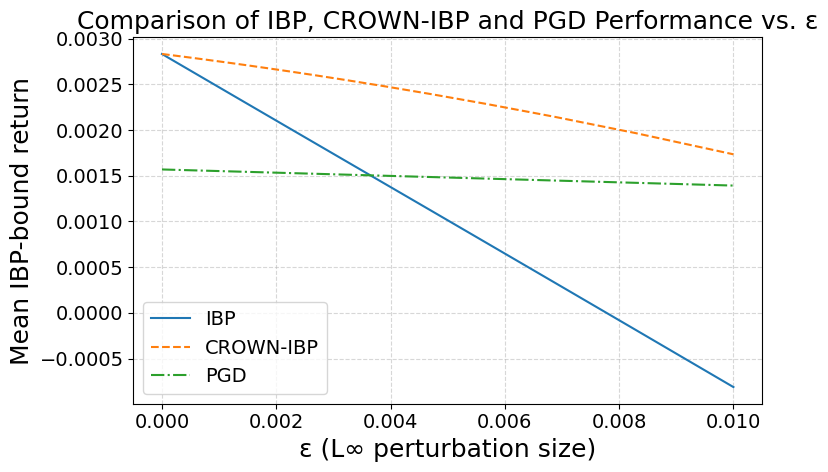

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch

N = 50
x = X_test_tensor.to(device)

epsilons = np.geomspace(1e-6, 0.01, num=N)

means_ibp       = []
means_crownibp  = []
means_pgd       = []

for eps in epsilons:
    perturb = PerturbationLpNorm(norm=np.inf, eps=eps)
    x_bnd   = BoundedTensor(x, perturb)
    ub, lb  = bounded_model.compute_bounds(x=(x_bnd,), method="IBP")
    ub = ub.unsqueeze(1).repeat(1, horizon, 1)
    lb = lb.unsqueeze(1).repeat(1, horizon, 1)
    wr_steps = torch.min(returns * lb, returns * ub).sum(dim=2)
    means_ibp.append(wr_steps.mean(dim=1).mean().item())

    perturb = PerturbationLpNorm(norm=np.inf, eps=eps)
    x_bnd   = BoundedTensor(x, perturb)
    ub, lb  = bounded_model.compute_bounds(x=(x_bnd,), method="CROWN-IBP")
    ub = ub.unsqueeze(1).repeat(1, horizon, 1)
    lb = lb.unsqueeze(1).repeat(1, horizon, 1)
    wr_steps = torch.min(returns * lb, returns * ub).sum(dim=2)
    means_crownibp.append(wr_steps.mean(dim=1).mean().item())

    X_adv   = pgd_attack(model, x, returns,
                         epsilon=eps, alpha=0.1,
                         num_iter=20, device=x.device)
    alloc_p = model(X_adv)
    r_p     = (alloc_p.unsqueeze(1)
                     .repeat(1, horizon, 1)
                     * returns).sum(dim=2)
    means_pgd.append(r_p.mean(dim=1).mean().cpu().detach().numpy())

plt.figure(figsize=(8, 5))
plt.plot(epsilons, means_ibp,       linestyle='-', label='IBP')
plt.plot(epsilons, means_crownibp,  linestyle='--', label='CROWN-IBP')
plt.plot(epsilons, means_pgd,       linestyle='-.', label='PGD')

plt.xlabel('ε (L∞ perturbation size)')
plt.ylabel('Mean IBP-bound return')
plt.title('Comparison of IBP, CROWN-IBP and PGD Performance vs. ε')
plt.legend(loc='best')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [61]:
means_crownibp[-1]

0.0017353070434182882

In [62]:
N = 50
epsilons = np.linspace(1e-6, 0.2, num=N)

means_ibp       = []
means_crownibp  = []
means_pgd       = []

for eps in epsilons:
    perturb = PerturbationLpNorm(norm=np.inf, eps=eps)
    x_bnd   = BoundedTensor(x, perturb)
    ub, lb  = bounded_model.compute_bounds(x=(x_bnd,), method="IBP")
    ub = ub.unsqueeze(1).repeat(1, horizon, 1)
    lb = lb.unsqueeze(1).repeat(1, horizon, 1)
    wr_steps = torch.min(returns * lb, returns * ub).sum(dim=2)
    means_ibp.append(wr_steps.mean(dim=1).mean().item())

    perturb = PerturbationLpNorm(norm=np.inf, eps=eps)
    x_bnd   = BoundedTensor(x, perturb)
    ub, lb  = bounded_model.compute_bounds(x=(x_bnd,), method="CROWN-IBP")
    ub = ub.unsqueeze(1).repeat(1, horizon, 1)
    lb = lb.unsqueeze(1).repeat(1, horizon, 1)
    wr_steps = torch.min(returns * lb, returns * ub).sum(dim=2)
    means_crownibp.append(wr_steps.mean(dim=1).mean().item())

    X_adv   = pgd_attack(model, x, returns,
                         epsilon=eps, alpha=0.1,
                         num_iter=20, device=x.device)
    alloc_p = model(X_adv)
    r_p     = (alloc_p.unsqueeze(1)
                     .repeat(1, horizon, 1)
                     * returns).sum(dim=2)
    means_pgd.append(r_p.mean(dim=1).mean().cpu().detach().numpy())

### PGD-IBP CNN

In [63]:

seeds = [10, 5, 6]

alphas = [0.0625, 0.1250, 0.25, 0.3750, 0.5, 0.75, 1]

CROWN_IBP_params_grids = [
    {
    "seed": [10],
    "epochs": [60, 61],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["Standard"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    # "robust_eps": [0.01],
    # "alpha": [0.25, 0.5],#, 0.75, 1],
    # "warmup": [20]
},
    {
    "seed": seeds,
    "epochs": [60],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],warmup
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["CROWN-IBP"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    "robust_eps": [0.01],
    "alpha": [0.25],
    "warmup": [20]
},
]



PGD_IBP_params_grids = [
        {
    "seed": [11, 6,5],
    "epochs": [60],
    "lambda_entropy": [0.000],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [0.001],
    "loss": ["PGD-IBP"],
    "jitter" : [1.5],
    "weight_decay": [1e-5],
    "robust_eps": [0.01],
    "alpha": [0.25],
    "ibp_weight": [0, 0.25, 0.5, 0.75, 1],
    "warmup": [20],
},
]



def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    print(jitter)
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def switch(params):
    if params["loss"] == "PGD-IBP":
        print("PGD_loss")
        return pgd_ibp_loss_fn_fn(params)
    return robust_loss_fn_fn(params)

experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
experiments = get_experiment_model(standard_model_fn, experiment_path, PGD_IBP_params_grids, switch, dataset_fn, device=device)

for model_name, experiment in experiments.items():
    model = experiment["model"]
   
    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=11,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=PGD-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,ibp_weight=0,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=11,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=PGD-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,ibp_weight=0.25,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=11,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=PGD-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,ibp_weight=0.5,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=11,epochs=60,lambda_entropy=0.0,model=CNN,learning_rate=0.001,loss=PGD-IBP,jitter=1.5,weight_decay=1e-05,robust_eps=0.01,alpha=0.25,ibp_weight=0.75,warmup=20,checkpoint=60.pth
Loading alpha-beta-CROWN/complete_verifier/train

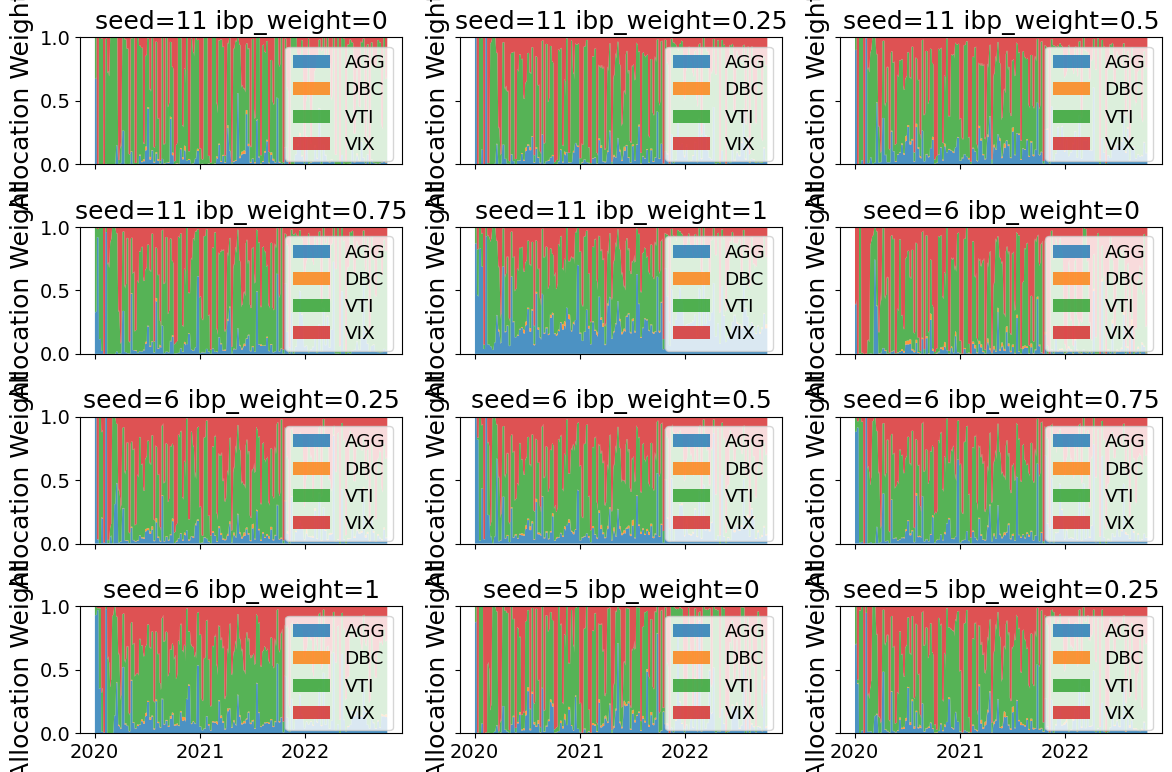

In [64]:
# robust_weights = { e["params"]["seed"]: e["results"]["test"]["raw"]["weights"] for ek,e in experiments.items()}
# robust_weights = {"Standard (Train ε=0)": standard_experiment["results"]["test"]["raw"]["weights"]}
# for eps in [0.001, 0.01, 0.015]:
#    robust_weights[ f'Robust (Train ε={eps})'] = robust_weights_[eps]
robust_weights = { ek: e["results"]["test"]["raw"]["weights"] for ek,e in experiments.items() }


weights_dict = robust_weights


asset_labels = asset_names
time_points = test_indices[:-55]  # 1 to 151 periods


fig, axes = plt.subplots(4, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()


for ax, (label, weights) in zip(axes, weights_dict.items()):
   # Create a stackplot: weights[:,0], weights[:,1], weights[:,2], weights[:,3]
   ax.stackplot(time_points,
                weights[:, 0],
                weights[:, 1],
                weights[:, 2],
           weights[:, 3],
                labels=asset_labels,
                alpha=0.8)
   ax.set_title(label)
   # ax.set_xlabel("Date")
   ax.set_ylabel("Allocation Weight")
   ax.set_ylim(0, 1)
   ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=1, maxticks=6))
   ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
   ax.legend(loc='upper right', fontsize='small')


fig.tight_layout()
plt.show()


test 6


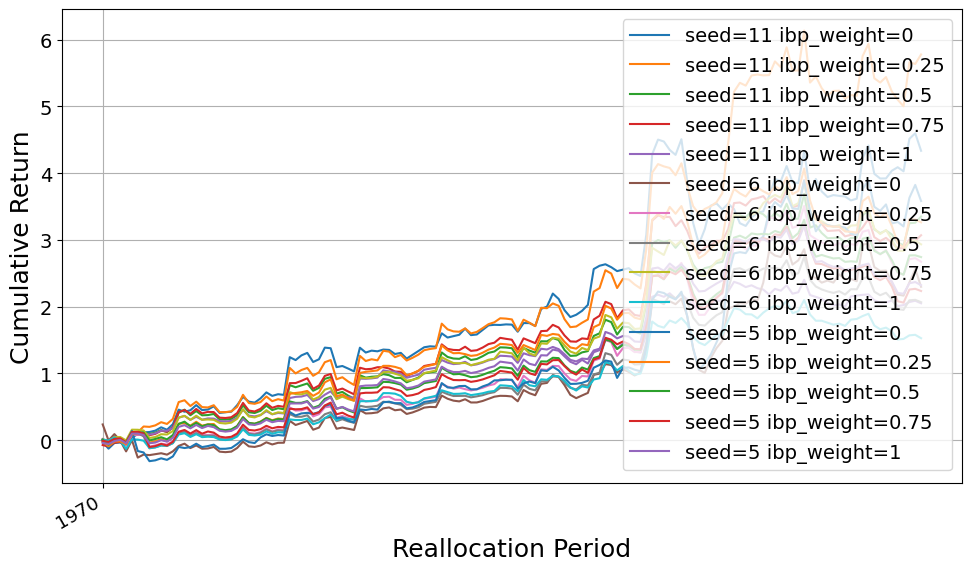

val 6


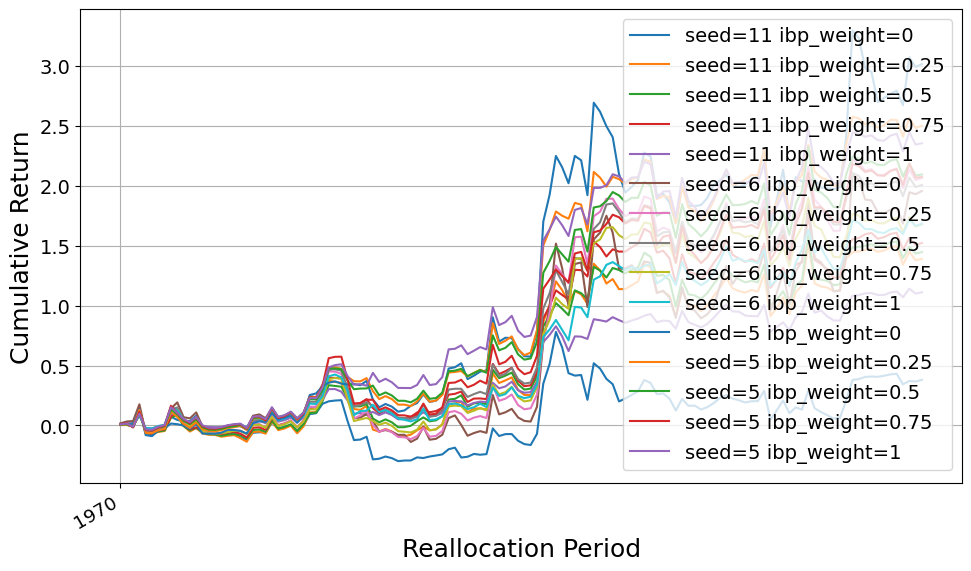

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# crs_ = { e["params"]["robust_eps"]: e["results"]["test"]["raw"]["cum_returns"] for ek,e in CNN_experiments.items() if (e["params"]["checkpoint"] == 75)}


# for seed in seeds:
for dataset in ["test", "val"]:
    print(dataset, seed)
    crs = { ek: e["results"][dataset]["raw"]["cum_returns"][::5] for ek, e in experiments.items()}
    # crs = { ek : e["results"][dataset]["raw"]["cum_returns"][::5] for ek, e in experiments.items() if seed == e["params"]["seed"]}

    cumulative_returns_dict = crs

    time_points = test_indices[50:-5][::5]#range(1, len(next(iter(cumulative_returns_dict.values()))) + 1)

    plt.figure(figsize=(10, 6))
    for label, cum_returns in cumulative_returns_dict.items():
        plt.plot(range(len(cum_returns)), cum_returns, label=label)

    plt.xlabel("Reallocation Period")
    plt.ylabel("Cumulative Return")
    # plt.ylim(bottom=0)  # Ensure returns start at zero or above
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [66]:
    # print(i)
filtered = {k:v for k,v in experiments.items() if v["params"].get("ibp_weight", None) == None}
metrics = { e["params"].get("robust_eps",0): performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in filtered.items()}
display(pd.DataFrame(metrics).T)

for i in [0,0.25,0.5,0.75,1]:
    print(i)
    filtered = {k:v for k,v in experiments.items() if v["params"].get("ibp_weight", -1) == i}
    metrics = { e["params"].get("robust_eps",0): performance_metrics(e["results"]["test"]["raw"]["returns"]) for ek, e in filtered.items()}
    display(pd.DataFrame(metrics).T)

Empty DataFrame
Columns: []
Index: []

0


annual_return  annual_volatility  sharpe_ratio  max_drawdown
0.01       0.730253           0.657648      1.110402      0.408527

0.25


annual_return  annual_volatility  sharpe_ratio  max_drawdown
0.01       0.700195           0.564808      1.239704      0.316129

0.5


annual_return  annual_volatility  sharpe_ratio  max_drawdown
0.01        0.60485            0.50546      1.196634      0.290963

0.75


annual_return  annual_volatility  sharpe_ratio  max_drawdown
0.01       0.532172           0.526362      1.011038      0.294272

1


annual_return  annual_volatility  sharpe_ratio  max_drawdown
0.01       0.563075           0.486409      1.157615       0.27236

In [67]:
metrics = { ek: (performance_metrics(e["results"]["test"]["raw"]["returns"]) | e["params"]) for ek, e in experiments.items() }

filtered = {k: v for k,v in metrics.items()}
df= pd.DataFrame(filtered).T

df

annual_return annual_volatility sharpe_ratio  \
seed=11 ibp_weight=0         0.845975          0.557406       1.5177   
seed=11 ibp_weight=0.25      0.979808          0.605824     1.617316   
seed=11 ibp_weight=0.5       0.696001          0.547909     1.270287   
seed=11 ibp_weight=0.75       0.70347          0.536342     1.311609   
seed=11 ibp_weight=1         0.494924          0.372821      1.32751   
seed=6 ibp_weight=0          0.423649          0.661223     0.640706   
seed=6 ibp_weight=0.25       0.588055           0.56165     1.047013   
seed=6 ibp_weight=0.5        0.488547          0.500944     0.975253   
seed=6 ibp_weight=0.75       0.637336          0.516956     1.232862   
seed=6 ibp_weight=1          0.392749          0.443289     0.885988   
seed=5 ibp_weight=0          0.730253          0.657648     1.110402   
seed=5 ibp_weight=0.25       0.700195          0.564808     1.239704   
seed=5 ibp_weight=0.5         0.60485           0.50546     1.196634   
seed=5 ibp_weight=0.75       0.532172          0.526362     1.011038   
seed=5 ibp_weight=1          0.563075          0.486409     1.157615   

                        max_drawdown seed epochs lambda_entropy model  \
seed=11 ibp_weight=0        0.290835   11     60            0.0   CNN   
seed=11 ibp_weight=0.25     0.337623   11     60            0.0   CNN   
seed=11 ibp_weight=0.5       0.31634   11     60            0.0   CNN   
seed=11 ibp_weight=0.75      0.30174   11     60            0.0   CNN   
seed=11 ibp_weight=1        0.197276   11     60            0.0   CNN   
seed=6 ibp_weight=0         0.401118    6     60            0.0   CNN   
seed=6 ibp_weight=0.25      0.300887    6     60            0.0   CNN   
seed=6 ibp_weight=0.5       0.277066    6     60            0.0   CNN   
seed=6 ibp_weight=0.75      0.282483    6     60            0.0   CNN   
seed=6 ibp_weight=1         0.215196    6     60            0.0   CNN   
seed=5 ibp_weight=0         0.408527    5     60            0.0   CNN   
seed=5 ibp_weight=0.25      0.316129    5     60            0.0   CNN   
seed=5 ibp_weight=0.5       0.290963    5     60            0.0   CNN   
seed=5 ibp_weight=0.75      0.294272    5     60            0.0   CNN   
seed=5 ibp_weight=1          0.27236    5     60            0.0   CNN   

                        learning_rate     loss jitter weight_decay robust_eps  \
seed=11 ibp_weight=0            0.001  PGD-IBP    1.5      0.00001       0.01   
seed=11 ibp_weight=0.25         0.001  PGD-IBP    1.5      0.00001       0.01   
seed=11 ibp_weight=0.5          0.001  PGD-IBP    1.5      0.00001       0.01   
seed=11 ibp_weight=0.75         0.001  PGD-IBP    1.5      0.00001       0.01   
seed=11 ibp_weight=1            0.001  PGD-IBP    1.5      0.00001       0.01   
seed=6 ibp_weight=0             0.001  PGD-IBP    1.5      0.00001       0.01   
seed=6 ibp_weight=0.25          0.001  PGD-IBP    1.5      0.00001       0.01   
seed=6 ibp_weight=0.5           0.001  PGD-IBP    1.5      0.00001       0.01   
seed=6 ibp_weight=0.75          0.001  PGD-IBP    1.5      0.00001       0.01   
seed=6 ibp_weight=1             0.001  PGD-IBP    1.5      0.00001       0.01   
seed=5 ibp_weight=0             0.001  PGD-IBP    1.5      0.00001       0.01   
seed=5 ibp_weight=0.25          0.001  PGD-IBP    1.5      0.00001       0.01   
seed=5 ibp_weight=0.5           0.001  PGD-IBP    1.5      0.00001       0.01   
seed=5 ibp_weight=0.75          0.001  PGD-IBP    1.5      0.00001       0.01   
seed=5 ibp_weight=1             0.001  PGD-IBP    1.5      0.00001       0.01   

                        alpha ibp_weight warmup checkpoint  
seed=11 ibp_weight=0     0.25          0     20         60  
seed=11 ibp_weight=0.25  0.25       0.25     20         60  
seed=11 ibp_weight=0.5   0.25        0.5     20         60  
seed=11 ibp_weight=0.75  0.25       0.75     20         60  
seed=11 ibp_weight=1     0.25          1     20         60  
seed=6 ibp_weight=0      0.25          

In [68]:
grouped = df.groupby('ibp_weight')[['annual_return']].mean().reset_index()
grouped

ibp_weight annual_return
0        0.00      0.666626
1        0.25      0.756019
2        0.50      0.596466
3        0.75      0.624326
4        1.00      0.483582

In [69]:
filtered = {k:v for k,v in experiments.items()}
metrics = { ek: (performance_metrics(e["results"]["test"]["raw"]["returns"]) | e["params"]) for ek, e in filtered.items() }


In [70]:
to_df = get_robustness(filtered, [0.1], [0.225], force_run=False)
pd.DataFrame(to_df)

loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results


model_path  eps  delta    cp  band_width      fake      true  \
0         0.25  0.1  0.225  1.00    1.896270  8.660801  4.335106   
1         0.25  0.1  0.225  0.16    0.673557  6.699946  5.778738   
2         0.25  0.1  0.225  0.47    0.697238  4.937145  3.350855   
3         0.25  0.1  0.225  0.03    0.190666  3.171780  3.070503   
4         0.25  0.1  0.225 -0.03    0.041824  1.994387  2.051157   
5         0.25  0.1  0.225 -0.45    0.441969  1.263865  2.298759   
6         0.25  0.1  0.225 -0.16    0.126034  2.255077  2.673621   
7         0.25  0.1  0.225 -0.06    0.023035  1.943807  2.067555   
8         0.25  0.1  0.225  0.02    0.098438  2.998204  2.934206   
9         0.25  0.1  0.225  0.10    0.118336  1.687265  1.528045   
10        0.25  0.1  0.225  0.36    0.806511  4.878381  3.583350   
11        0.25  0.1  0.225  0.15    0.339279  3.763741  3.263762   
12        0.25  0.1  0.225  0.09    0.099910  2.993798  2.743295   
13        0.25  0.1  0.225  0.52    0.297120  3.396012  2.235126   
14        0.25  0.1  0.225  0.29    0.289801  3.002921  2.321751   

                                         fake_returns  \
0   [-0.07781619, -0.05287975, -0.10212457, -0.091...   
1   [0.016706705, -0.009570241, -0.0472973, -0.026...   
2   [0.0029512644, -0.015828788, -0.055232823, -0....   
3   [-0.0730592, -0.05070132, -0.099366486, -0.088...   
4   [-0.0013536811, -0.017839372, -0.057767212, -0...   
5   [0.39260304, 0.28359902, 0.28869152, 0.2205687...   
6   [0.016563535, -0.009513378, -0.047260046, -0.0...   
7   [0.01600635, -0.00986141, -0.047674537, -0.026...   
8   [6.92606e-05, -0.01719302, -0.05694729, -0.037...   
9   [0.007252097, -0.013861477, -0.052741528, -0.0...   
10  [-0.036614418, -0.03395033, -0.07817519, -0.06...   
11  [-0.023845136, -0.02798611, -0.07065785, -0.05...   
12  [0.0060111284, -0.014447749, -0.0534786, -0.03...   
13  [-0.011109829, -0.022315145, -0.06343168, -0.0...   
14  [-0.039417624, -0.035287023, -0.07985282, -0.0...   

                                         true_returns  \
0   [-0.028088748, -0.030094504, -0.07327998, -0.0...   
1   [0.016706705, -0.009570241, -0.0472973, -0.026...   
2   [0.0029512644, -0.015828788, -0.055232823, -0....   
3   [-0.0730592, -0.05070132, -0.099366486, -0.088...   
4   [-0.0013536811, -0.017839372, -0.057767212, -0...   
5   [0.23660517, 0.161978, 0.14930367, 0.1182245, ...   
6   [0.016563535, -0.009513378, -0.047260046, -0.0...   
7   [0.01600635, -0.00986141, -0.047674537, -0.026...   
8   [6.92606e-05, -0.01719302, -0.05694729, -0.037...   
9   [0.007252097, -0.013861477, -0.052741528, -0.0...   
10  [-0.00053566694, -0.017453134, -0.057281077, -...   
11  [-0.023845136, -0.02798611, -0.07065785, -0.05...   
12  [0.0060111284, -0.014447749, -0.0534786, -0.03...   
13  [-0.011109829, -0.022315145, -0.06343168, -0.0...   
14  [-0.039417624, -0.035287023, -0.07985282, -0.0...   

                                              summary  ... model  \
0   {'unsafe-pgd': [0, 6, 12, 13, 15, 16, 21, 22, ...  ...   CNN   
1   {'safe-incomplete': [0, 1, 2, 3, 4, 5, 6, 7, 8...  ...   CNN   
2   {'safe-incomplete': [0, 1, 2, 3, 4, 5, 8, 9, 1...  ...   CNN   
3   {'safe-incomplete': [0, 1, 2, 3, 4, 5, 8, 9, 1...  ...   CNN   
4   {'safe-incomplete': [0, 2, 3, 4, 5, 6, 7, 8, 9...  ...   CNN   
5   {'unsafe-pgd': [0, 6, 7, 9, 10, 11, 12, 14, 15...  ...   CNN   
6   {'safe-incomplete': [0, 1, 2, 4, 5, 6, 8, 9, 1...  ...   CNN   
7   {'safe-incomplete': [0, 1, 2, 4, 5, 7, 8, 9, 1...  ...   CNN   
8   {'safe-incomplete': [0, 1, 2, 3, 4, 5, 6, 7, 8...  ...   CNN   
9   {'safe-incomplete': [0, 1, 2, 4, 5, 6, 7, 8, 9...  ...   CNN   
10  {'unsafe-pgd': [0, 6, 7, 10, 12, 13, 14, 15, 1...  ...   CNN   
11  {'safe-incomplete': [0, 1, 2, 3, 4, 5, 8, 10, ...  ...   CNN   
12  {'safe-incomplete': [0, 2, 3, 4, 5, 8, 9, 10, ...  ...   CNN   
13  {'safe-incomplete': [0, 1, 2, 3, 4, 5, 7, 8, 9...  ...   CNN   
14  {'safe-incomplete': [0, 1, 2, 3, 4, 5, 8, 9, 1...  ...   CNN   



In [71]:
len(to_df), len(metrics)

(15, 15)

In [72]:
to_df[0].keys()

dict_keys(['model_path', 'eps', 'delta', 'cp', 'band_width', 'fake', 'true', 'fake_returns', 'true_returns', 'summary', 'adv_X', 'unsafe-pgd', 'safe-incomplete', 'unknown', 'seed', 'epochs', 'lambda_entropy', 'model', 'learning_rate', 'loss', 'jitter', 'weight_decay', 'robust_eps', 'alpha', 'ibp_weight', 'warmup', 'checkpoint'])

In [73]:
test_eps = [0.1]
test_delta = [0.225]
to_df = get_robustness(filtered,  [0.1], [0.225])

metrics = { (e["params"].get("ibp_weight",0),  e["params"].get("seed",0)): performance_metrics(e["results"]["test"]["raw"]["returns"]) | e["params"] for ek, e in filtered.items()}

for item in to_df:
    seed = item["seed"]
    ibp_weight = item.get("ibp_weight", 0)
    robust = item.get("safe-incomplete",0)
    nonrobust = item.get("unsafe-pgd",0)
    unknown = item.get("unknown",0)

    robsut_per =  robust / (robust+nonrobust+unknown)
    cp = item["cp"]
    t = item["true"]
    fake = item["fake"]
    band_width = item["band_width"]

    print((ibp_weight, seed))

    metrics[(ibp_weight, seed)] = metrics[(ibp_weight, seed)] | {"robust": robsut_per, "cp": cp, "t":t, "fake":fake, "band_width": band_width}

df = pd.DataFrame([ {"beta": k} | v for k,v in metrics.items()])

df 

loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
loading results
(0, 11)
(0.25, 11)
(0.5, 11)
(0.75, 11)
(1, 11)
(0, 6)
(0.25, 6)
(0.5, 6)
(0.75, 6)
(1, 6)
(0, 5)
(0.25, 5)
(0.5, 5)
(0.75, 5)
(1, 5)


beta  annual_return  annual_volatility  sharpe_ratio  max_drawdown  \
0      (0, 11)       0.845975           0.557406      1.517700      0.290835   
1   (0.25, 11)       0.979808           0.605824      1.617316      0.337623   
2    (0.5, 11)       0.696001           0.547909      1.270287      0.316340   
3   (0.75, 11)       0.703470           0.536342      1.311609      0.301740   
4      (1, 11)       0.494924           0.372821      1.327510      0.197276   
5       (0, 6)       0.423649           0.661223      0.640706      0.401118   
6    (0.25, 6)       0.588055           0.561650      1.047013      0.300887   
7     (0.5, 6)       0.488547           0.500944      0.975253      0.277066   
8    (0.75, 6)       0.637336           0.516956      1.232862      0.282483   
9       (1, 6)       0.392749           0.443289      0.885988      0.215196   
10      (0, 5)       0.730253           0.657648      1.110402      0.408527   
11   (0.25, 5)       0.700195           0.564808      1.239704      0.316129   
12    (0.5, 5)       0.604850           0.505460      1.196634      0.290963   
13   (0.75, 5)       0.532172           0.526362      1.011038      0.294272   
14      (1, 5)       0.563075           0.486409      1.157615      0.272360   

    seed  epochs  lambda_entropy model  learning_rate  ... robust_eps  alpha  \
0     11      60             0.0   CNN          0.001  ...       0.01   0.25   
1     11      60             0.0   CNN          0.001  ...       0.01   0.25   
2     11      60             0.0   CNN          0.001  ...       0.01   0.25   
3     11      60             0.0   CNN          0.001  ...       0.01   0.25   
4     11      60             0.0   CNN          0.001  ...       0.01   0.25   
5      6      60             0.0   CNN          0.001  ...       0.01   0.25   
6      6      60             0.0   CNN          0.001  ...       0.01   0.25   
7      6      60             0.0   CNN          0.001  ...       0.01   0.25   
8      6      60             0.0   CNN          0.001  ...       0.01   0.25   
9      6      60             0.0   CNN          0.001  ...       0.01   0.25   
10     5      60             0.0   CNN          0.001  ...       0.01   0.25   
11     5      60             0.0   CNN          0.001  ...       0.01   0.25   
12     5      60             0.0   CNN          0.001  ...       0.01   0.25   
13     5      60             0.0   CNN          0.001  ...       0.01   0.25   
14     5      60             0.0   CNN          0.001  ...       0.01   0.25   

    ibp_weight  warmup  checkpoint    robust    cp         t      fake  \
0         0.00      20          60  0.276596  1.00  4.335106  8.660801   
1         0.25      20          60  0.482270  0.16  5.778738  6.699946   
2         0.50      20          60  0.539007  0.47  3.350855  4.937145   
3         0.75      20          60  0.524823  0.03  3.070503  3.171780   
4         1.00      20          60  0.971631 -0.03  2.051157  1.994387   
5         0.00      20          60  0.148936 -0.45  2.298759  1.263865   
6         0.25      20          60  0.638298 -0.16  2.673621  2.255077   
7         0.50      20          60  0.815603 -0.06  2.067555  1.943807   
8         0.75      20          60  0.822695  0.02  2.934206  2.998204   
9         1.00      20          60  0.971631  0.10  1.528045  1.687265   
10        0.00      20          60  0.120567  0.36  3.583350  4.878381   
11        0.25      20          60  0.595745  0.15  3.263762  3.763741   
12        0.50      20          60  0.617021  0.09  2.743295  2.993798   
13        0.75      20          60  0.730496  0.52  2.235126  3.396012   
14        1.00      20          60  0.765957  0.29  2.321751  3.002921   

    band_width  
0     1.896270  
1     0.673557  
2     0.697238  
3     0.190666  
4     0.041824  
5     0.441969  
6     0.126034  
7     0.023035  
8     0.098438  
9     0.118336  
10    0.806511  
11    0.339279  
12    0.099910  
13    0.297120  
14    0.

In [74]:
result = (
    df
    .groupby('ibp_weight')[[
        'annual_return',
        'annual_volatility',
        'sharpe_ratio',
        'max_drawdown',
        "robust", 
        "cp",
        "t",
        "fake",
    ]]
    .mean()
    .reset_index()
)
result

ibp_weight  annual_return  annual_volatility  sharpe_ratio  max_drawdown  \
0        0.00       0.666626           0.625426      1.089603      0.366827   
1        0.25       0.756019           0.577427      1.301344      0.318213   
2        0.50       0.596466           0.518104      1.147391      0.294790   
3        0.75       0.624326           0.526553      1.185170      0.292831   
4        1.00       0.483582           0.434173      1.123704      0.228277   

     robust        cp         t      fake  
0  0.182033  0.303333  3.405738  4.934349  
1  0.572104  0.050000  3.905374  4.239588  
2  0.657210  0.166667  2.720568  3.291583  
3  0.692671  0.190000  2.746611  3.188665  
4  0.903073  0.120000  1.966984  2.228191

## PGD-IBP LSTM

In [75]:


params_grids = [
    {
    "seed": seeds[:1],
    "epochs": [100],
    "lambda_entropy": [0.025],
    "model": ["LSTM_Unrolled"],
    "lstm_hidden_layers" : [1],
    "lstm_hidden_size": [8],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "loss": ["Standard"],
    "jitter": [1.5],
    },
    {
    "seed": seeds[:1],
    "epochs": [140],
    "lambda_entropy": [0.025],
    "model": ["LSTM_Unrolled"],
    "lstm_hidden_layers" : [1],
    "lstm_hidden_size": [8],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "loss": ["Standard"],
    "jitter": [1.5],
    "checkpoint_freq": [20],
    "robust_loss_weight": [0.25],
    "ibp_weight": [0, 1],  #0.250.25 0.76 1.65 0.29 0.65 ,
    "robust_eps": [0.001, 0.002, 0.0005]
}
]

experiment_path = "alpha-beta-CROWN/complete_verifier/trained_models"
#lambda x: FinalCNN().to(device)
experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, pgd_ibp_loss_fn_fn, dataset_fn, device=device, train_robust=False)


experiments = {k:v for k,v in experiments.items() if v["params"]["checkpoint"] == 100}

# experiments = { "test": {"model": model, "params": {}, "results": {}}}
# 10.4
for model_name, experiment in experiments.items():
    model = experiment["model"]

    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_hidden_layers=1,lstm_hidden_size=8,learning_rate=0.001,rebalance_freq=5,loss=Standard,jitter=1.5,checkpoint=100.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=140,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_hidden_layers=1,lstm_hidden_size=8,learning_rate=0.001,rebalance_freq=5,loss=Standard,jitter=1.5,checkpoint_freq=20,robust_loss_weight=0.25,ibp_weight=0,robust_eps=0.001,checkpoint=20.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=140,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_hidden_layers=1,lstm_hidden_size=8,learning_rate=0.001,rebalance_freq=5,loss=Standard,jitter=1.5,checkpoint_freq=20,robust_loss_weight=0.25,ibp_weight=0,robust_eps=0.001,checkpoint=40.pth
Loading alpha-beta-CROWN/complete_verifier/trained_models/seed=10,epochs=140,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_hidden_layers=1,

/tmp/ipykernel_2762574/3805463404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


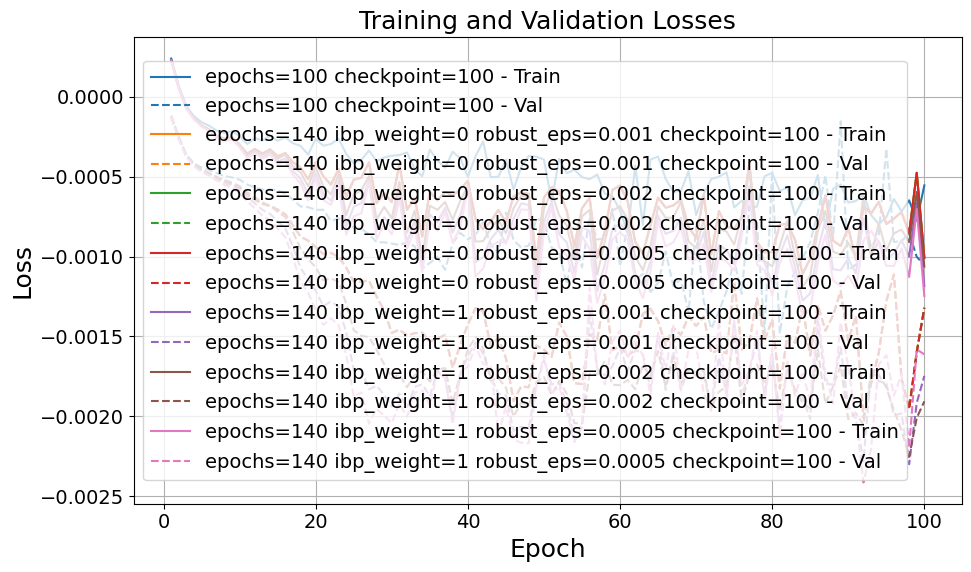

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_2762574/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return  \
epochs=100 checkpoint=100                                     7.72   
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...            10.7   
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...            10.7   
epochs=140 ibp_weight=0 robust_eps=0.0005 check...            10.7   
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...            9.46   
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...            7.79   
epochs=140 ibp_weight=1 robust_eps=0.0005 check...            10.4   

                                                   sharpe_ratio max_drawdown  \
epochs=100 checkpoint=100                                0.0788         0.39   
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...       0.0798        0.425   
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...       0.0798        0.425   
epochs=140 ibp_weight=0 robust_eps=0.0005 check...       0.0798        0.425   
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...       0.0761        0.413   
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...       0.0737        0.397   
epochs=140 ibp_weight=1 robust_eps=0.0005 check...       0.0783        0.421   

                                                   mean_entropy mean_return  \
epochs=100 checkpoint=100                                 0.604     0.00409   
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...        0.464     0.00494   
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...        0.464     0.00494   
epochs=140 ibp_weight=0 robust_eps=0.0005 check...        0.464     0.00494   
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...        0.469      0.0047   
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...        0.542     0.00425   
epochs=140 ibp_weight=1 robust_eps=0.0005 check...        0.427     0.00498   

                                                   std_return  
epochs=100 checkpoint=100                              0.0519  
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...     0.0619  
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...     0.0619  
epochs=140 ibp_weight=0 robust_eps=0.0005 check...     0.0619  
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...     0.0618  
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...     0.0577  
epochs=140 ibp_weight=1 robust_eps=0.0005 check...     0.0635

(701,)
(701,)
(701,)
(701,)
(701,)
(701,)
(701,)


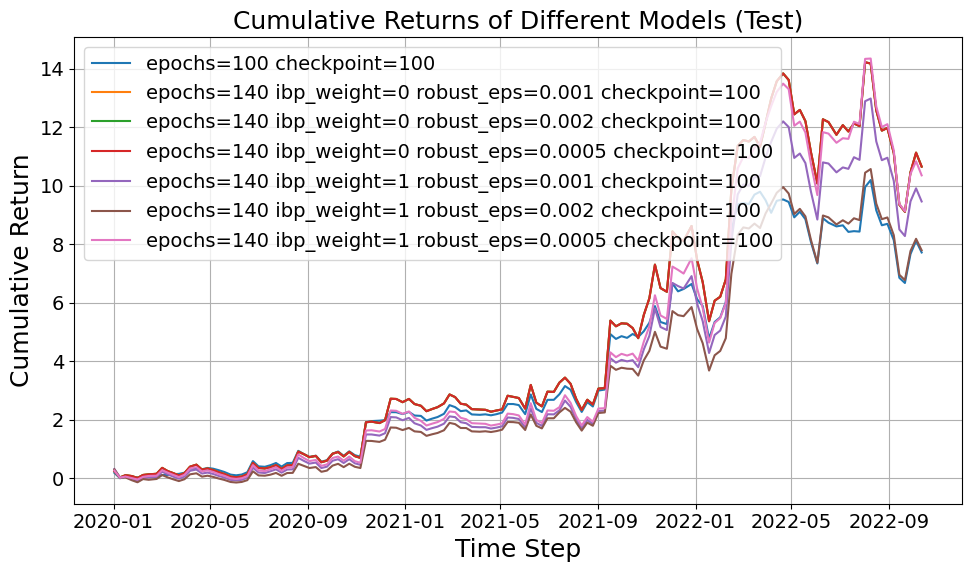

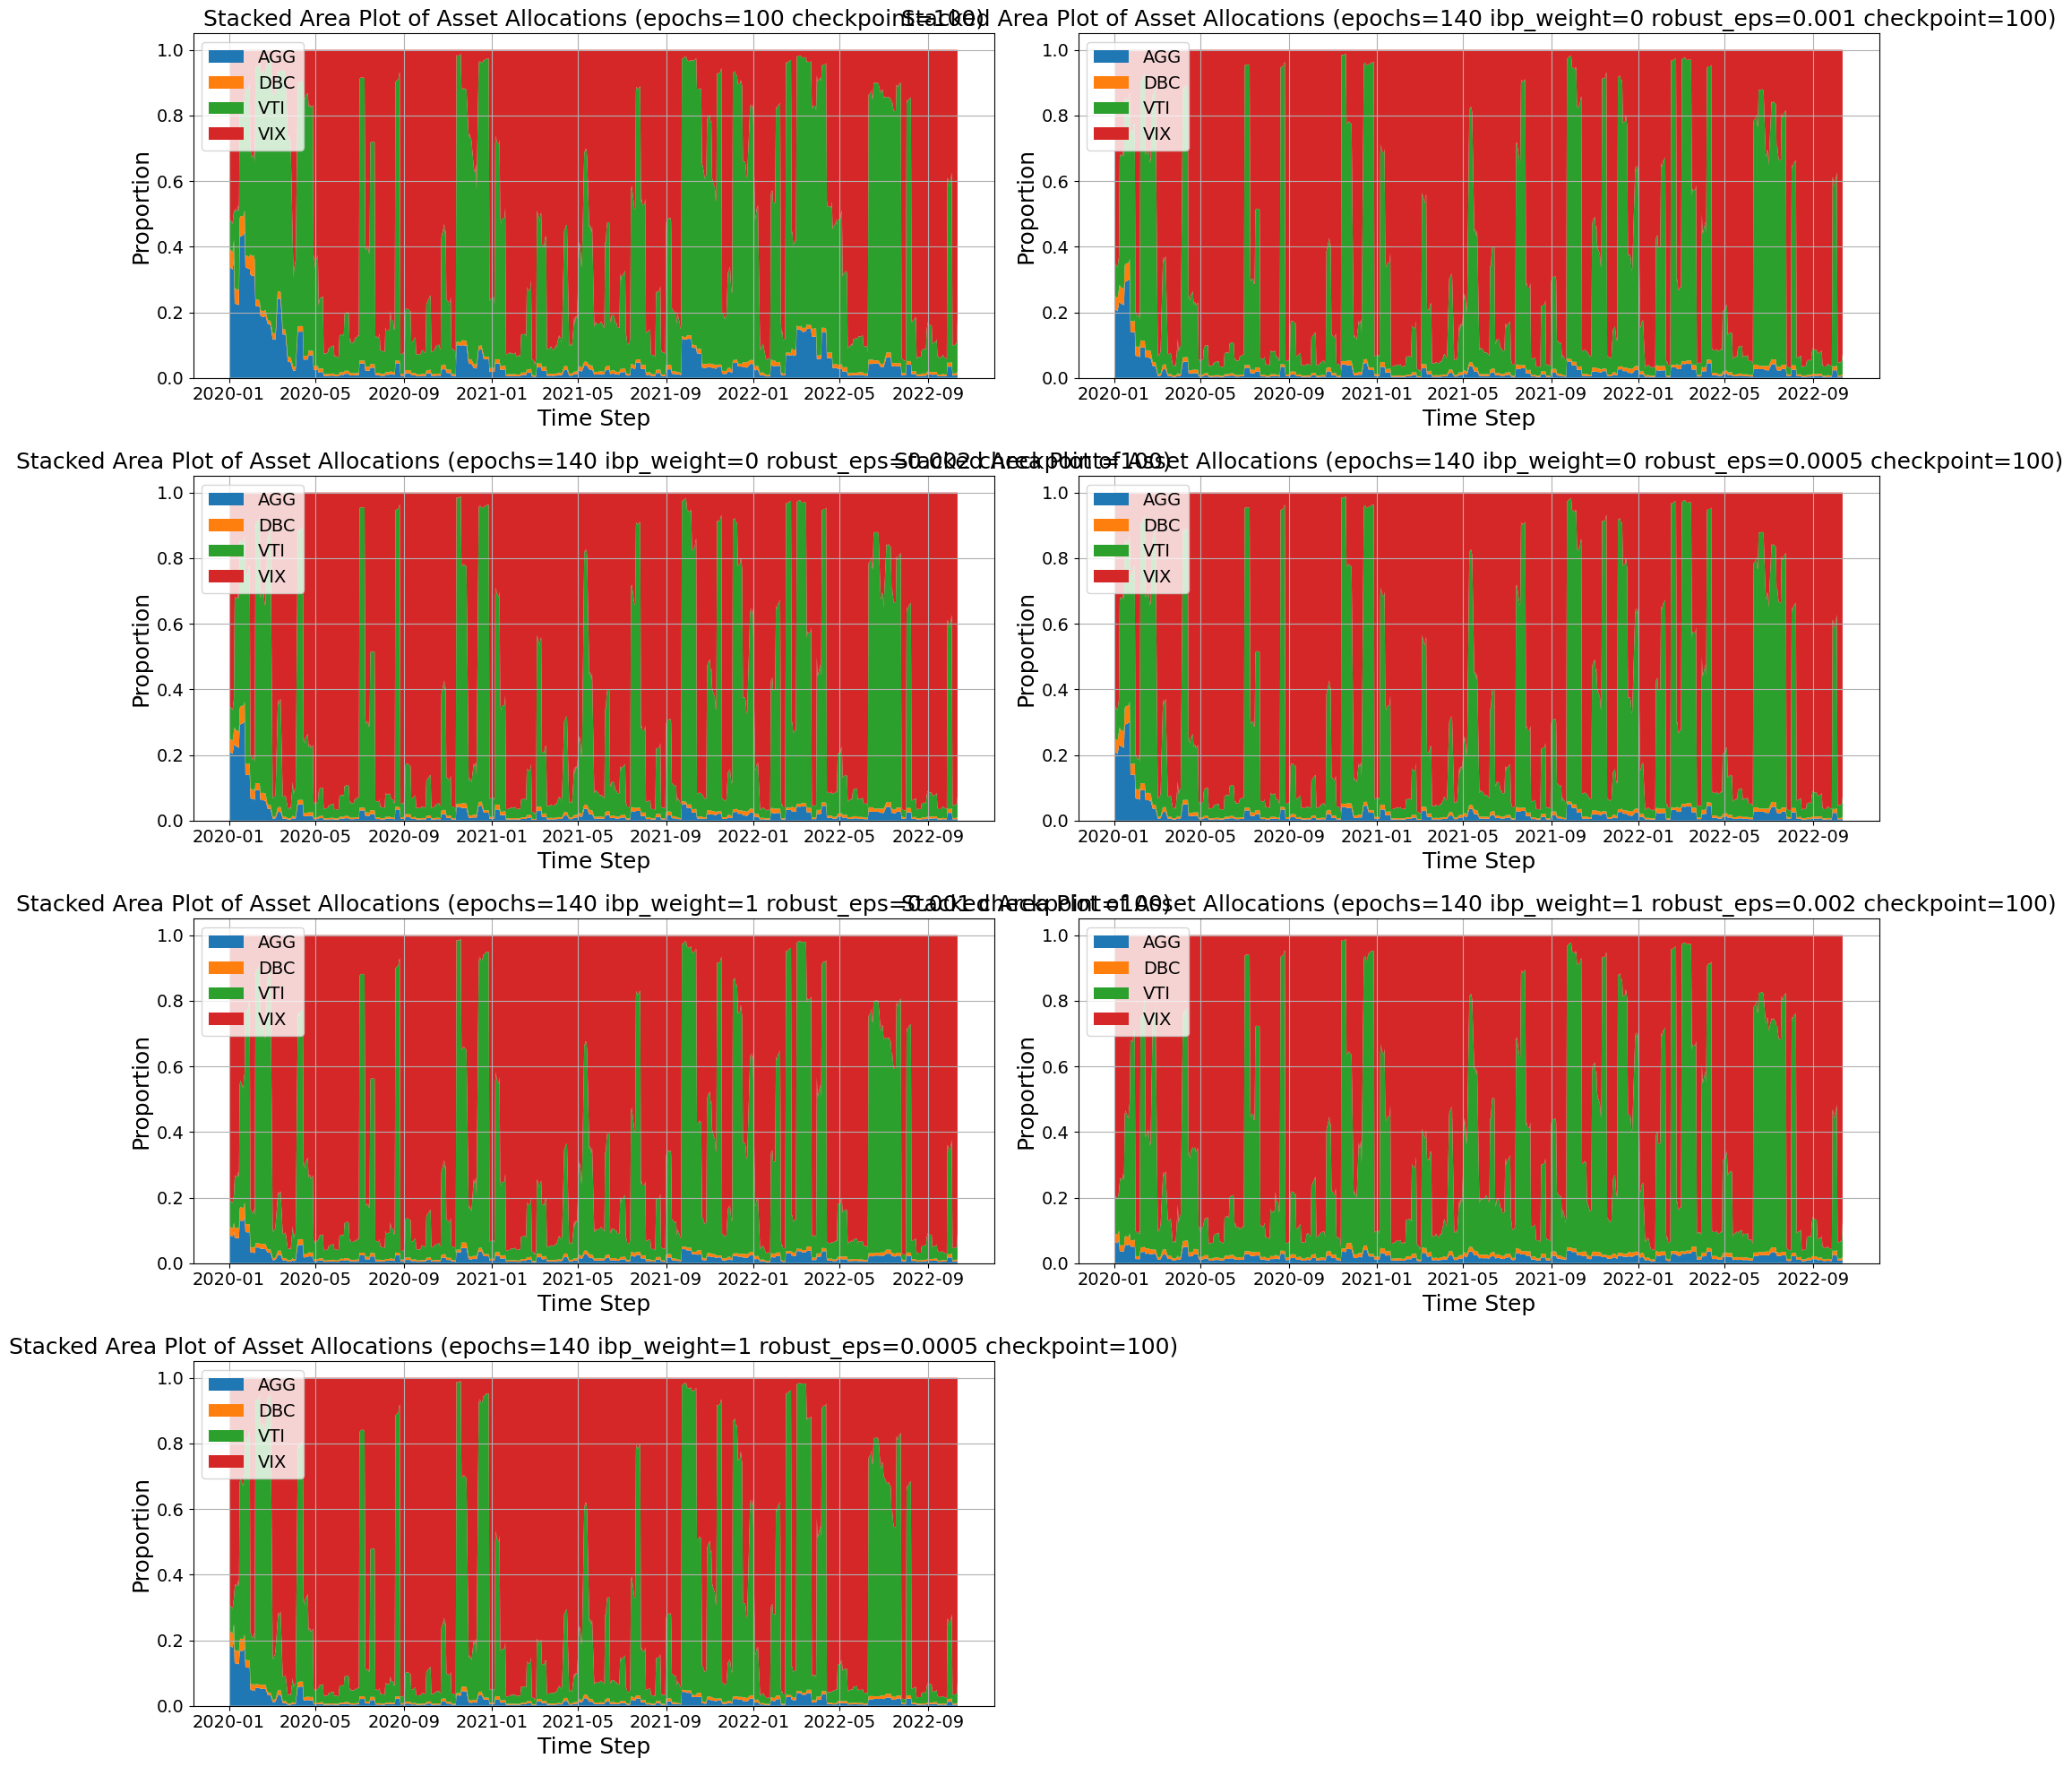

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_2762574/3805463404.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


expected_return  \
epochs=100 checkpoint=100                                      5.8   
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...            5.68   
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...            5.68   
epochs=140 ibp_weight=0 robust_eps=0.0005 check...            5.68   
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...            6.97   
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...             7.4   
epochs=140 ibp_weight=1 robust_eps=0.0005 check...            6.49   

                                                   sharpe_ratio max_drawdown  \
epochs=100 checkpoint=100                                0.0794        0.356   
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...       0.0761        0.401   
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...       0.0761        0.401   
epochs=140 ibp_weight=0 robust_eps=0.0005 check...       0.0761        0.401   
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...       0.0797        0.389   
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...       0.0847        0.322   
epochs=140 ibp_weight=1 robust_eps=0.0005 check...       0.0771         0.44   

                                                   mean_entropy mean_return  \
epochs=100 checkpoint=100                                 0.531     0.00444   
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...        0.392     0.00477   
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...        0.392     0.00477   
epochs=140 ibp_weight=0 robust_eps=0.0005 check...        0.392     0.00477   
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...        0.427      0.0051   
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...        0.523     0.00482   
epochs=140 ibp_weight=1 robust_eps=0.0005 check...         0.37     0.00518   

                                                   std_return  
epochs=100 checkpoint=100                              0.0559  
epochs=140 ibp_weight=0 robust_eps=0.001 checkp...     0.0627  
epochs=140 ibp_weight=0 robust_eps=0.002 checkp...     0.0627  
epochs=140 ibp_weight=0 robust_eps=0.0005 check...     0.0627  
epochs=140 ibp_weight=1 robust_eps=0.001 checkp...      0.064  
epochs=140 ibp_weight=1 robust_eps=0.002 checkp...     0.0569  
epochs=140 ibp_weight=1 robust_eps=0.0005 check...     0.0672

(637,)
(637,)
(637,)
(637,)
(637,)
(637,)
(637,)


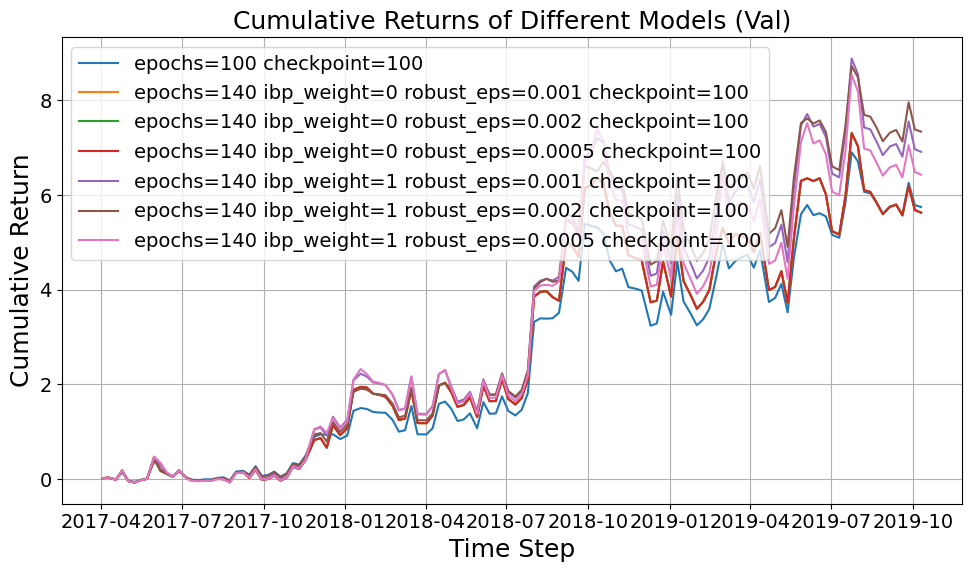

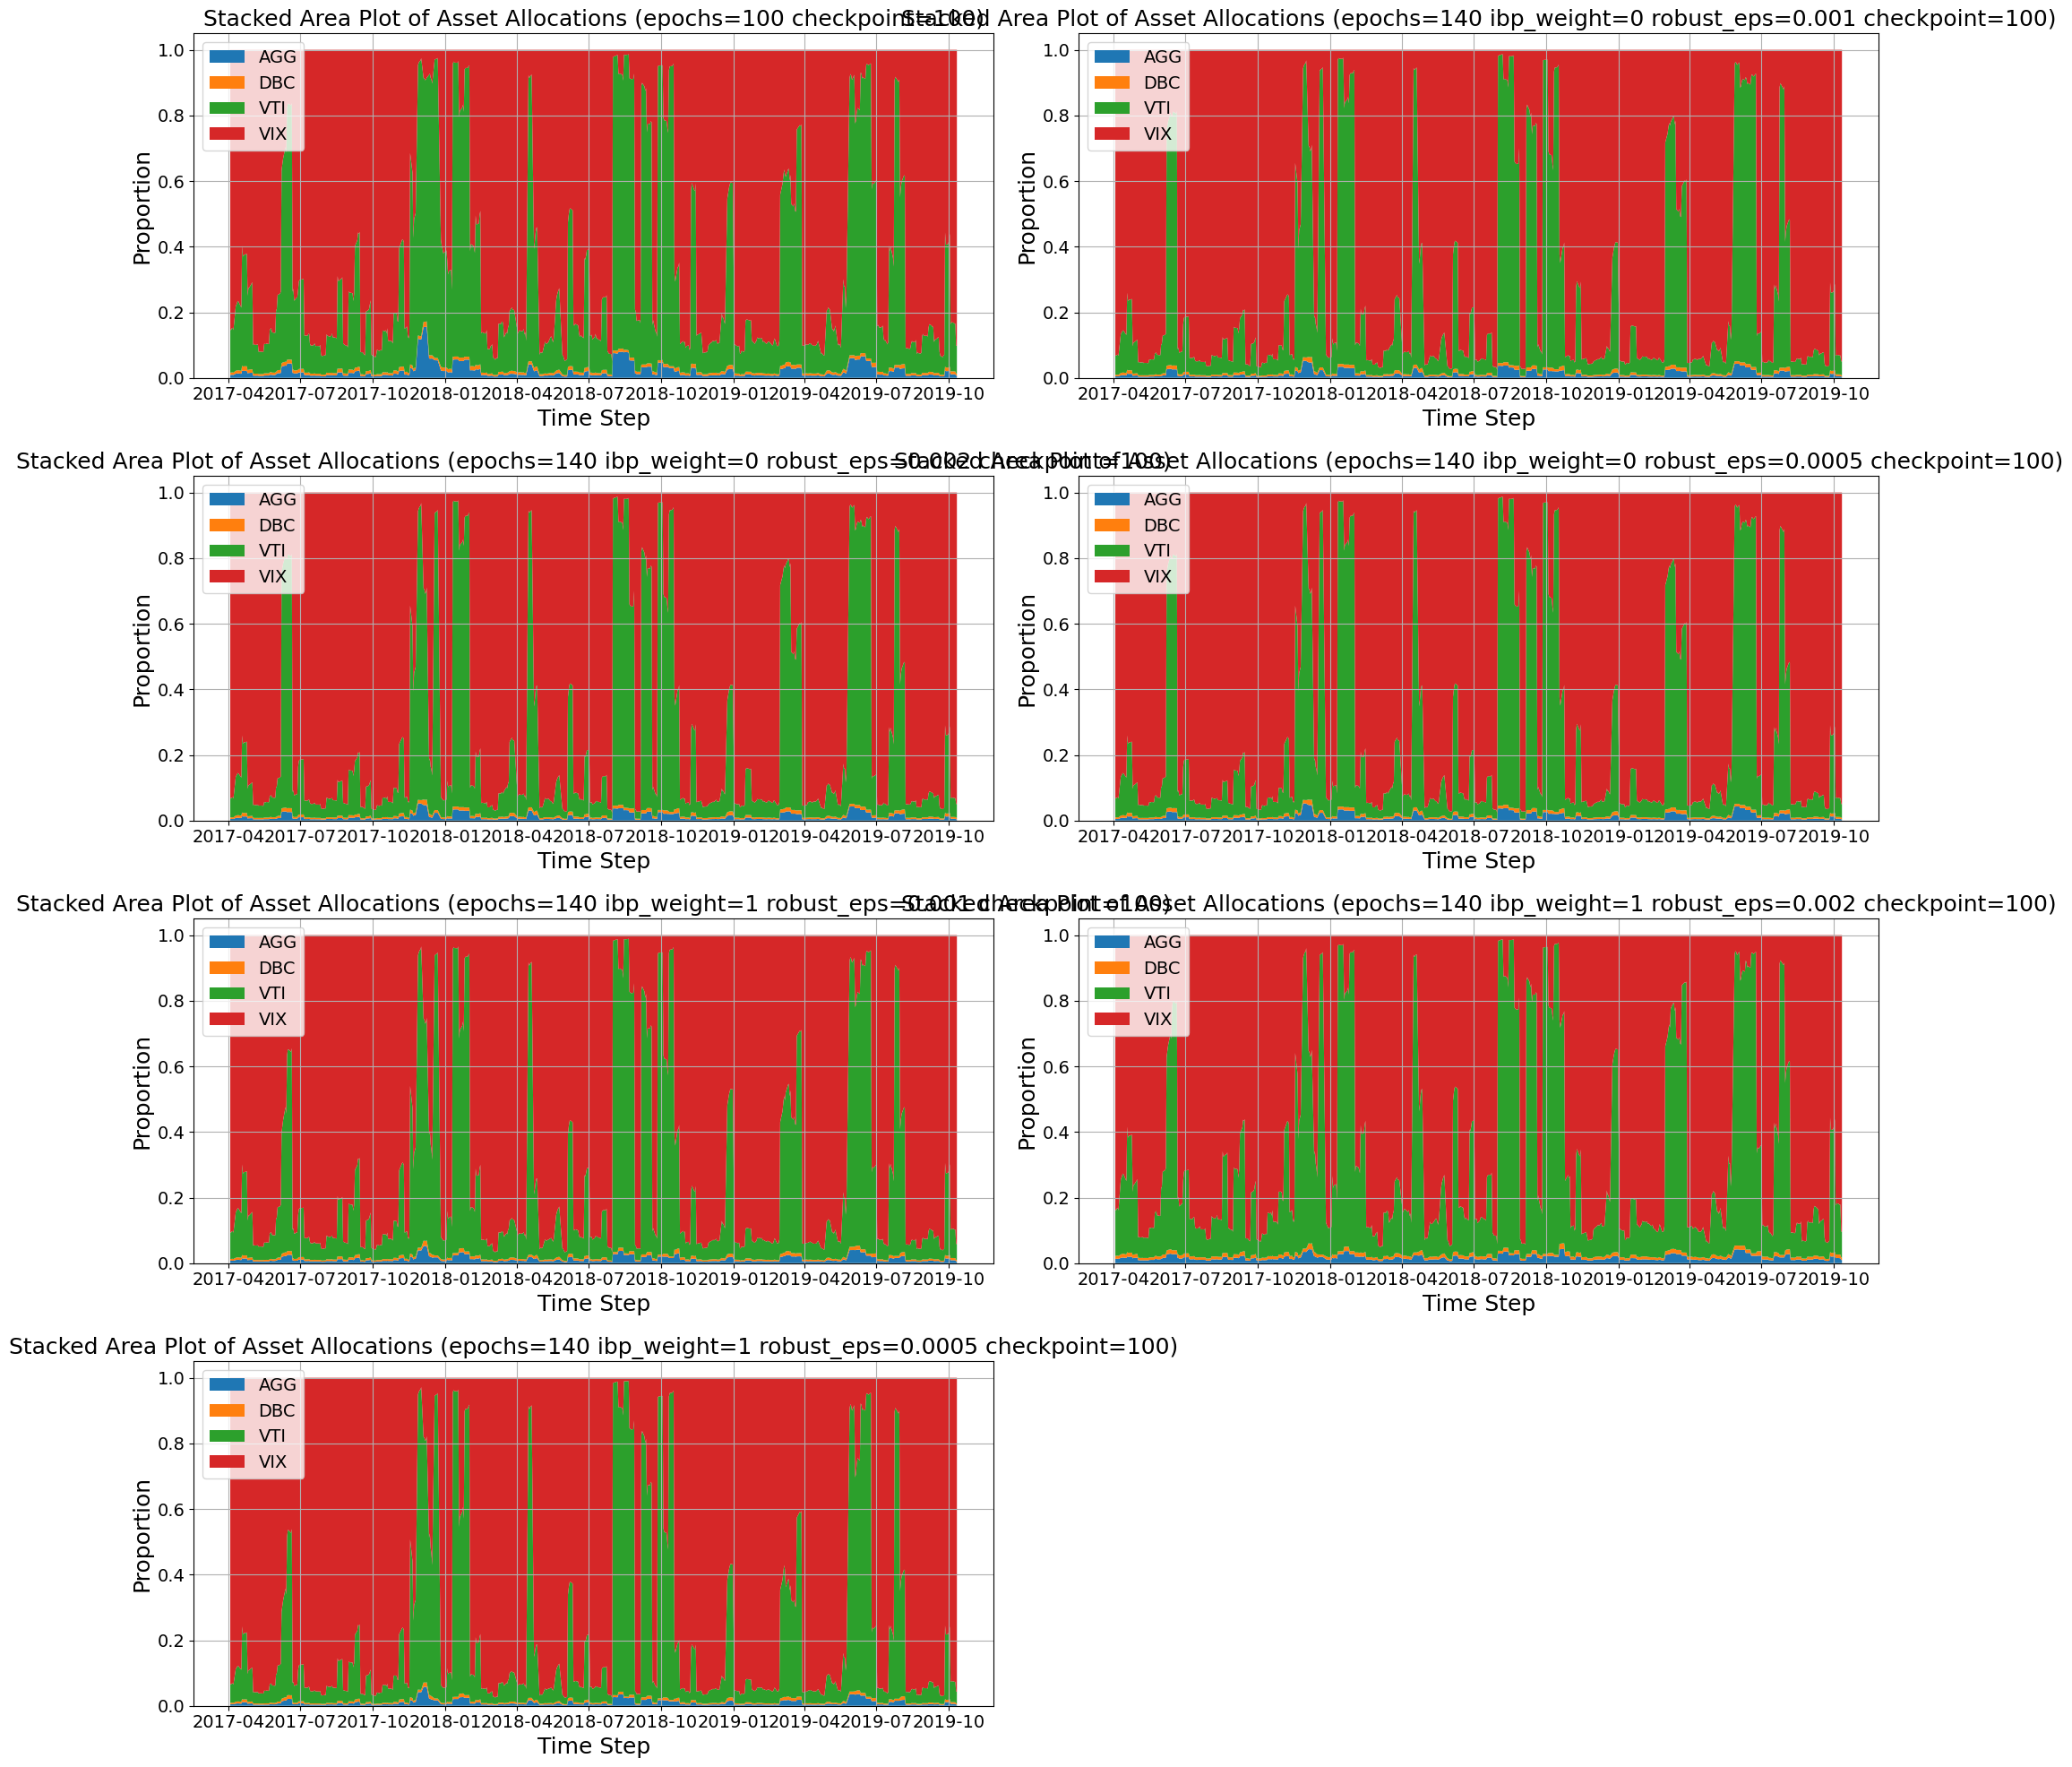

In [76]:
# ments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
display_train_results(experiments)
# filtered_experiements = experiments
for dataset_key, dataset_idx in zip(["test", "val", ], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

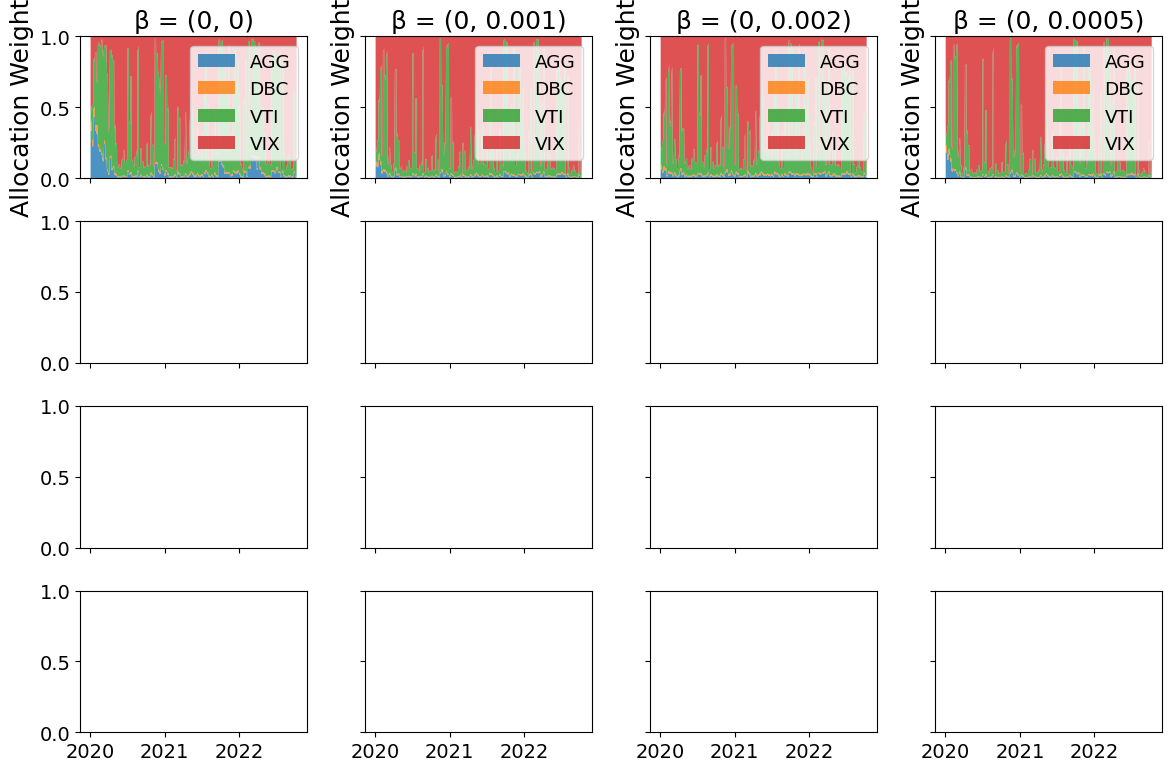

In [77]:

robust_weights = { (e["params"].get("epsilon", 0), e["params"].get("robust_eps", 0)): e["results"]["test"]["raw"]["weights"] for ek,e in experiments.items() }


weights_dict = robust_weights


asset_labels = asset_names
time_points = test_indices[:-55]  # 1 to 151 periods


fig, axes = plt.subplots(4, 4, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()


for ax, (label, weights) in zip(axes, weights_dict.items()):
   # Create a stackplot: weights[:,0], weights[:,1], weights[:,2], weights[:,3]
   ax.stackplot(time_points,
                weights[:, 0],
                weights[:, 1],
                weights[:, 2],
           weights[:, 3],
                labels=asset_labels,
                alpha=0.8)
   ax.set_title(f"β = {label}")
   # ax.set_xlabel("Date")
   ax.set_ylabel("Allocation Weight")
   ax.set_ylim(0, 1)
   ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=1, maxticks=6))
   ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
   ax.legend(loc='upper right', fontsize='small')


fig.tight_layout()
plt.show()


/tmp/ipykernel_2762574/3805463404.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


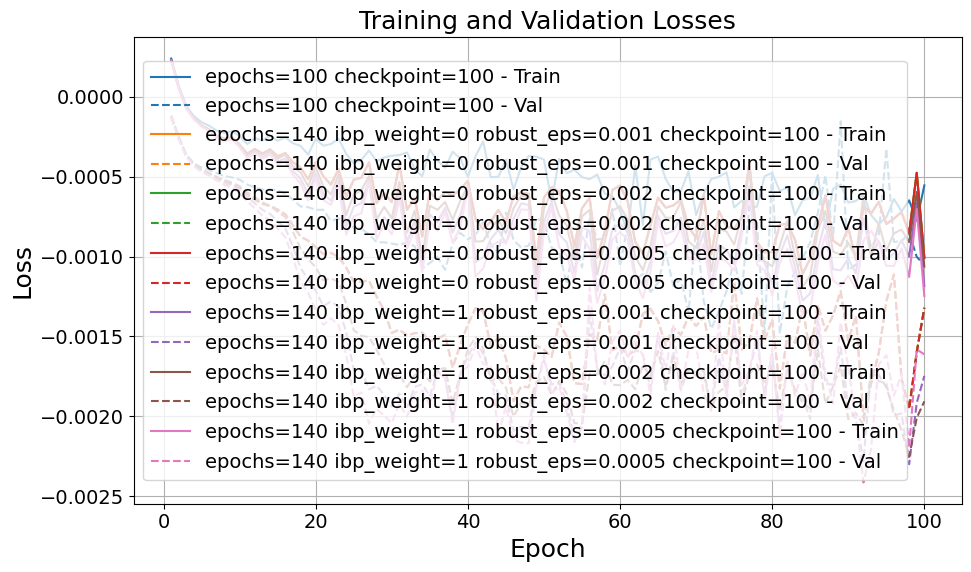

In [78]:
display_train_results(experiments)

test 5


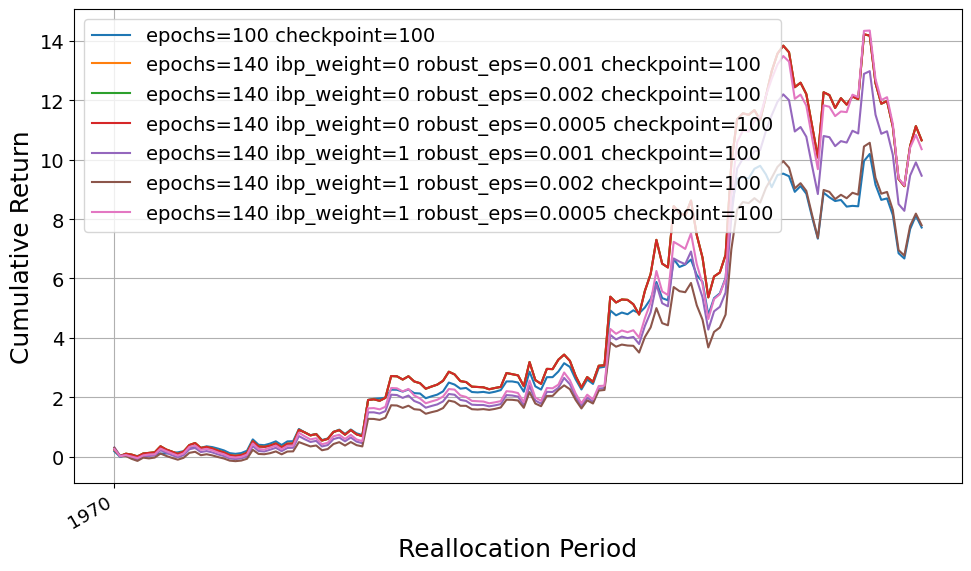

val 5


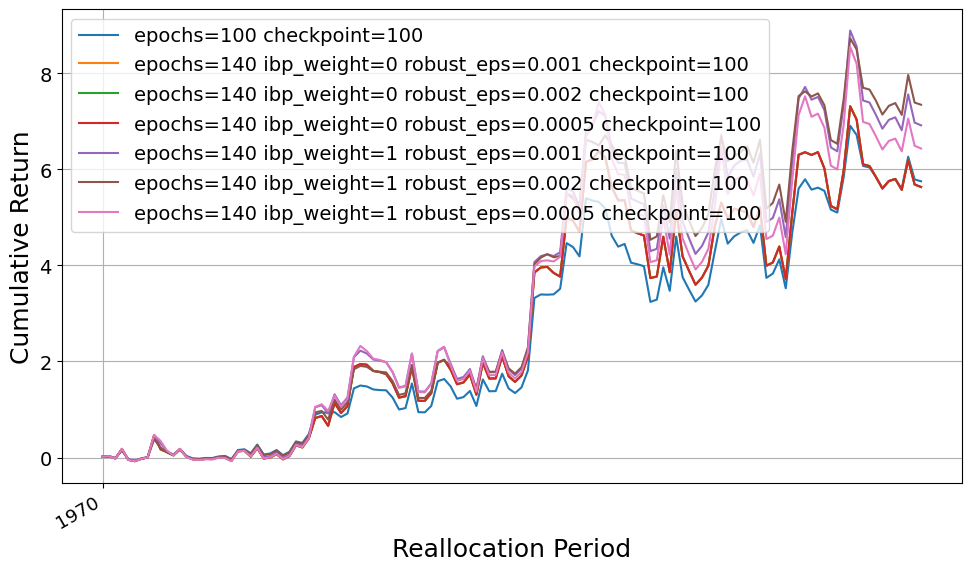

In [79]:
import matplotlib.pyplot as plt
import numpy as np

for dataset in ["test", "val"]:
    print(dataset, seed)
    crs = { ek : e["results"][dataset]["raw"]["cum_returns"][::5] for ek, e in experiments.items() if e["params"]["checkpoint"] > 60}

    cumulative_returns_dict = crs

    time_points = test_indices[50:-5][::5]#range(1, len(next(iter(cumulative_returns_dict.values()))) + 1)

    plt.figure(figsize=(10, 6))
    for label, cum_returns in cumulative_returns_dict.items():
        plt.plot(range(len(cum_returns)), cum_returns, label=label)

    plt.xlabel("Reallocation Period")
    plt.ylabel("Cumulative Return")
    # plt.ylim(bottom=0)  # Ensure returns start at zero or above
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(plt.gca().get_xticklabels(), rotation=30, ha="right", fontsize='small')

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [89]:
standard_lstm = experiments["epochs=100 checkpoint=100"]
robust_lstm = experiments["epochs=140 ibp_weight=1 robust_eps=0.002 checkpoint=100"]

filtered = { "Standard LSTM": standard_lstm, "robust_lstm": robust_lstm}

In [87]:
robustness = get_robustness(filtered, [0.1], [0.1], extra_args={"no_incomplete": "", "model": '\'Customized(\"custom_model_data\", \"lstm_model\")\''})

loading results
loading results


In [88]:
pd.DataFrame(robustness)

model_path  eps  delta    cp  band_width      fake      true  \
0           0  0.1    0.1 -0.42    1.384857  4.503857  7.792153   
1           0  0.1    0.1  0.08    0.227662  8.311371  7.717197   

                                        fake_returns  \
0  [0.29899466, 0.21669912, 0.21152425, 0.1580749...   
1  [0.18027174, 0.1222136, 0.10405612, 0.08007324...   

                                        true_returns  \
0  [0.29899466, 0.21669912, 0.21152425, 0.1580749...   
1  [0.18027174, 0.1222136, 0.10405612, 0.08007324...   

                                             summary  ... lstm_hidden_size  \
0  {'unknown': [0, 1, 4, 8, 11, 12, 13, 16, 17, 1...  ...                8   
1  {'unknown': [0, 1, 2, 3, 4, 5, 6, 7, 13, 20, 2...  ...                8   

   learning_rate  rebalance_freq      loss  jitter  checkpoint_freq  \
0          0.001               5  Standard     1.5             20.0   
1          0.001               5  Standard     1.5              NaN   

  robust_loss_weight  ibp_weight  robust_eps  checkpoint  
0               0.25         1.0       0.002         100  
1                NaN         NaN         NaN         100  

[2 rows x 28 columns]